# Residual value model

## Imports

In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from pandas.plotting import scatter_matrix
import plotly as py
py.offline.init_notebook_mode() 
import plotly.figure_factory as ff
%matplotlib inline

## 1.- Data extraction

La fase de estracción de datos se ha realizado haciendo uso de la técnica de web scraping. Los datos se han obtenido de la página web [Cars.com](https://www.cars.com/) entre los días 22/03/2025 y 28/03/2025. El código utilizado está disponible [aquí](https://github.com/jcllanu/residual-value/blob/main/web_scraping.py). En esta fase, procedemos a realizar la carga de los datos.

The data extraction process has been done making use of web scraping techniques. Data has been obtained from the website [Cars.com](https://www.cars.com/) between the dates 03/22/2025 and 03/28/2025. The code used is available [here](https://github.com/jcllanu/residual-value/blob/main/web_scraping.py). In this step, the information is loaded.

In [2]:
makes=["acura","audi","bmw","buick","cadillac","chevrolet","chrysler","dodge","ford","gmc","honda","hyundai","infiniti","jeep","kia","land_rover","lexus",
     "lincoln","mazda","mercedes_benz","mini","mitsubishi","nissan","porsche","ram","subaru","tesla","toyota","volkswagen","volvo"]
df_list=[]
for make in makes:
    for batch in range(1,26):
        path='cars\\'+make+'\\cars_'+make+'_'+str(batch)+'.json'
        if os.path.exists(path):
            df_list.append(pd.read_json(path))

df=pd.concat(df_list, ignore_index=True,axis=0)
df.head()

year_manufacture  years   make  \
0              2006     19  acura   
1              2021      4  acura   
2              2017      8  acura   
3              2024      1  acura   
4              2017      8  acura   

                                            model  mileage stock_type  \
0                                  Acura TSX Base    76497       Used   
1                    Acura RDX Technology Package    54931       Used   
2             Acura MDX 3.5L w/Technology Package   103720       Used   
3                            Acura Integra A-SPEC    17309       Used   
4  Acura RDX Technology & AcuraWatch Plus Package    66552       Used   

  interior_color         exterior_color        drive_train  \
0          Biege            Green Pearl  Front-wheel Drive   
1       Espresso   Majestic Black Pearl    All-wheel Drive   
2          Ebony  Modern Steel Metallic    All-wheel Drive   
3          Ebony   Platinum White Pearl  Front-wheel Drive   
4          Ebony    White Diamond Pearl    All-wheel Drive   

                                                 mpg fuel_type  \
0  22–31 Based on EPA mileage ratings. Use for co...  Gasoline   
1  21–27 Based on EPA mileage ratings. Use for co...  Gasoline   
2  18–26 Based on EPA mileage ratings. Use for co...  Gasoline   
3  29–36 Based on EPA mileage ratings. Use for co...  Gasoline   
4  19–27 Based on EPA mileage ratings. Use for co...  Gasoline   

         transmission                                             engine  \
0           Automatic  2.4L I-4 DOHC, i-VTEC variable valve control, ...   
1  10-Speed Automatic  2L I-4 gasoline direct injection, DOHC, VTEC v...   
2           Automatic  3.5L V-6 gasoline direct injection, i-VTEC var...   
3           Automatic  1.5L I-4 gasoline direct injection, DOHC, VTEC...   
4           Automatic  3.5L V-6 i-VTEC variable valve control, premiu...   

   price_USD                                                url  
0    10995.0  https://cars.com/vehicledetail/d6115b1a-3830-4...  
1    27985.0  https://cars.com/vehicledetail/f9548b93-31b2-4...  
2    17981.0  https://cars.com/vehicledetail/06e7a2fc-13ec-4...  
3    30049.0  https://cars.com/vehicledetail/658c133c-dc51-4...  
4    18950.0  https://cars.com/vehicledetail/79565df9-1fba-4...

## 2.- Data preprocesing

### 2.1.- Removing duplicates
Durante el proceso de extracción de datos, pueden surgir duplicidades. Se verifica su existencia y, en caso afirmativo, se eliminan las filas duplicadas del DataFrame.<br> <br>
During the data extraction process, duplicates may arise. Their presence is verified, and if detected, duplicate rows are removed from the DataFrame.

In [3]:
num_duplicated_rows=sum(df.duplicated())
print(f'The number of duplicated rows is {num_duplicated_rows}')

The number of duplicated rows is 8982


In [4]:
df = df.drop_duplicates()
num_duplicated_rows=sum(df.duplicated())
print(f'The number of duplicated rows is now {num_duplicated_rows}')

The number of duplicated rows is now 0


### 2.2.- High level variable description

A continuación, se realiza un primer análisis a muy alto nivel de las variables disponibles, utilizando un diccionario de datos y evaluando la cantidad de valores ausentes, valores atípicos o categorías.

#### Diccionario de datos
- **year_manufacture**: Año de fabricación del vehículo, que generalmente coincide con el año de compra.
- **years**: Antigüedad del vehículo en años, calculada en 2025. Se obtiene como la diferencia entre el año 2025 y el año de fabricación.
- **make**: Marca del vehículo.
- **model**: Modelo del vehículo.
- **mileage**: Kilometraje del vehículo, expresado en millas.
- **stock_type**: Indicador de si el vehículo es nuevo o usado.
- **interior_color**: Color del interior del vehículo, expresado en lenguaje natural.
- **exterior_color**: Color del exterior del vehículo, expresado en lenguaje natural.
- **drive_train**: Tipo de tracción del vehículo (delantera, trasera, a las cuatro ruedas).
- **mpg**: Consumo de combustible, expresado en millas por galón. Puede incluir información sobre la diferencia entre el consumo en ciudad y en carretera.
- **fuel_type**: Tipo de motorización (diésel, gasolina, híbrido, eléctrico, etc.).
- **transmission**: Tipo de transmisión. Cadena de texto que indica si es manual o automática y el número de marchas.
- **engine**: Cadena de caracteres que describe el motor en lenguaje natural. Puede incluir información sobre la cilindrada, el volumen o los caballos.
- **price_USD**: Precio de venta del vehículo a la fecha de extracción de datos, expresado en dólares estadounidenses.
- **url**: Dirección web de donde se ha extraído la información.

Next, a high-level analysis of the available variables is conducted using a data dictionary and assessing the number of missing values, outliers, or categories.
#### Data dictionary
- **year_manufacture**: Year of vehicle manufacture, which generally corresponds to the year of purchase.
- **years**: Vehicle age in years, calculated in 2025. It is obtained as the difference between the year 2025 and the year of manufacture.
- **make**: Vehicle make.
- **model**: Vehicle model.
- **mileage**: Vehicle mileage, expressed in miles.
- **stock_type**: Indicator of whether the vehicle is new or used.
- **interior_color**: Interior color of the vehicle, expressed in natural language.
- **exterior_color**: Exterior color of the vehicle, expressed in natural language.
- **drive_train**: Vehicle drivetrain type (front, rear, all-wheel drive).
- **mpg**: Fuel consumption, expressed in miles per gallon. It may include information about the difference between city and highway consumption.
- **fuel_type**: Engine type (diesel, gasoline, hybrid, electric, etc.).
- **transmission**: Transmission type. Text string indicating whether it is manual or automatic and the number of gears.
- **engine**: Text string that describes the engine in natural language. It may include information about the engine displacement and volume.
- **price_USD**: Vehicle sale price at the data extraction date, expressed in US dollars.
- **url**: Web address from which the information was extracted.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141185 entries, 0 to 150166
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   year_manufacture  141185 non-null  int64  
 1   years             141185 non-null  int64  
 2   make              141185 non-null  object 
 3   model             141185 non-null  object 
 4   mileage           141185 non-null  int64  
 5   stock_type        141185 non-null  object 
 6   interior_color    141185 non-null  object 
 7   exterior_color    141185 non-null  object 
 8   drive_train       141185 non-null  object 
 9   mpg               131855 non-null  object 
 10  fuel_type         133860 non-null  object 
 11  transmission      141185 non-null  object 
 12  engine            141185 non-null  object 
 13  price_USD         141181 non-null  float64
 14  url               141185 non-null  object 
dtypes: float64(1), int64(3), object(11)
memory usage: 17.2+ MB


#### Check the Categorical and Numerical Columns

In [6]:
# Categorical variables
cat_col = [col for col in df.columns if df[col].dtype == 'object']
print('Categorical variables:',cat_col)
# Numerical variables
num_col = [col for col in df.columns if df[col].dtype != 'object']
print('Numerical variables:',num_col)

Categorical variables: ['make', 'model', 'stock_type', 'interior_color', 'exterior_color', 'drive_train', 'mpg', 'fuel_type', 'transmission', 'engine', 'url']
Numerical variables: ['year_manufacture', 'years', 'mileage', 'price_USD']


In [7]:
#Number of unique values for categorical variables
df[cat_col].nunique()

make                  30
model               9201
stock_type            26
interior_color      4507
exterior_color      5674
drive_train           17
mpg                  931
fuel_type             29
transmission        1019
engine              5278
url               141027
dtype: int64

Se observa que algunas variables categóricas presentan una gran variedad de valores distintos, lo cual se debe a que están expresadas en lenguaje natural. Será necesario aplicar un procesamiento de datos riguroso para tratarlas adecuadamente.

It is observed that some categorical variables exhibit a wide range of distinct values, which is due to their expression in natural language. A thorough data processing approach will be required to handle them appropriately.

In [8]:
for col in cat_col:
    print('Variable:',col)
    print('Sample of some unique values:', df[col].unique()[:20],'\n')

Variable: make
Sample of some unique values: ['acura' 'audi' 'bmw' 'buick' 'cadillac' 'chevrolet' 'chrysler' 'dodge'
 'ford' 'gmc' 'honda' 'hyundai' 'infiniti' 'jeep' 'kia' 'land_rover'
 'lexus' 'lincoln' 'mazda' 'mercedes_benz'] 

Variable: model
Sample of some unique values: ['Acura TSX Base' 'Acura RDX Technology Package'
 'Acura MDX 3.5L w/Technology Package' 'Acura Integra A-SPEC'
 'Acura RDX Technology & AcuraWatch Plus Package' 'Acura TLX V6 Tech'
 'Acura Integra A-SPEC w/ Technology' 'Acura TLX V6' 'Acura ZDX A-SPEC'
 'Acura MDX Sport Hybrid SH-AWD Sport Hybrid w/Technology Pkg'
 'Acura RLX Technology Package' 'Acura MDX SH-AWD Technology'
 'Acura TLX Base' 'Acura MDX SH-AWD' 'Acura ZDX A-Spec'
 'Acura RDX SH-AWD Technology' 'Acura MDX Sport Hybrid Technology Package'
 'Acura TSX Technology' 'Acura ILX Base' 'Acura MDX 3.5L'] 

Variable: stock_type
Sample of some unique values: ['Used' 'Acura Certified' 'Certified' 'Audi Certified' 'BMW Certified'
 'Buick Certified' 'Cadillac C

### 2.2.- Data cleansing and feature engineering

En esta fase, el objetivo es identificar y corregir errores o imprecisiones en los datoas así como transformar los datos en bruto en un conjunto de entradas más efectivas de cara a un modelo de machine learning. Realizamos el proceso variable a variable.

In this phase, the focus will be on identifying and correcting inaccurate or incorrect records as well as transforming the raw data into a more effective set of inputs. This process is done for each variable

##### MPG

Se puede observar que este campo está compuesto por un par de valores numéricos separados por un guion, seguidos de una nota informativa: 'Based on EPA mileage ratings. Use for comparison purposes only. Actual mileage will vary depending on driving conditions, driving habits, vehicle maintenance, and other factors.' Asumiremos que, en producción, se contará con los 'EPA mileage ratings' de los vehículos, por lo que esta variable puede seguir siendo útil. De ella, obtendremos los valores de consumo en ciudad y carretera si están disponibles.

It can be observed that this field consists of a pair of numerical values separated by a hyphen, followed by an informational note: 'Based on EPA mileage ratings. Use for comparison purposes only. Actual mileage will vary depending on driving conditions, driving habits, vehicle maintenance, and other factors.' We will assume that, in production, the 'EPA mileage ratings' of the vehicles will be available, so this variable may still be useful. From it, we will obtain the values for city and highway consumption if available.

In [9]:
def keep_numbers_and_en_dash(text):
    if text is None:
        return None  # Return None if the value is None
    return re.sub(r'[^0-9–]', '', text)  # Keep numbers and en dash (–)

def get_mpg_city(text):
    if text is None:
        return None  # Return None if the value is None
    if text == "–":
        return None # No information available
    if "–" not in text:
        return float(text) if text.replace('.', '', 1).isdigit() and text.count('.') < 2 \
            else None # If the text is a decimal number, return the number
    return float(text.split('–')[0]) if text.split('–')[0].replace('.', '', 1).isdigit() \
        and text.split('–')[0].count('.') < 2 else None # Since the text contains an hyphen, 
                                                        # return what's on the left-hand
                                                        # side if it is a decimal number

def get_mpg_highway(text):
    if text is None:
        return None  # Return None if the value is None
    if text == "–":
        return None # No information available
    if "–" not in text:
        return float(text) if text.replace('.', '', 1).isdigit() and text.count('.') < 2 \
            else None # If the text is a decimal number, return the number
    return float(text.split('–')[1]) if text.split('–')[1].replace('.', '', 1).isdigit() \
        and text.split('–')[1].count('.') < 2 else None # Since the text contains an hyphen, 
                                                        # return what's on the right-hand
                                                        # side if it is a decimal number

df.loc[df['mpg'].apply(lambda x: isinstance(x, float) and np.isnan(x)),'mpg']=None # substitue NaN for None
df['auxiliar'] = df['mpg'].apply(keep_numbers_and_en_dash)
df['mpg_city'] = df['auxiliar'].apply(get_mpg_city)
df['mpg_highway'] = df['auxiliar'].apply(get_mpg_highway)

In [10]:
# Check nulls in mpg_city: All null values in mpg_city are due to the fact that mpg is None or '–'
df[df['mpg_city'].isnull()]['mpg'].unique()

array([None, '–'], dtype=object)

In [11]:
# Check nulls in mpg_highway: All null values in mpg_highway are due to the fact that mpg is None or '–'
df[df['mpg_highway'].isnull()]['mpg'].unique()

array([None, '–'], dtype=object)

In [12]:
# Remove useless colums and display the df
df.drop(columns=['mpg', 'auxiliar'], inplace=True)
df.head()

year_manufacture  years   make  \
0              2006     19  acura   
1              2021      4  acura   
2              2017      8  acura   
3              2024      1  acura   
4              2017      8  acura   

                                            model  mileage stock_type  \
0                                  Acura TSX Base    76497       Used   
1                    Acura RDX Technology Package    54931       Used   
2             Acura MDX 3.5L w/Technology Package   103720       Used   
3                            Acura Integra A-SPEC    17309       Used   
4  Acura RDX Technology & AcuraWatch Plus Package    66552       Used   

  interior_color         exterior_color        drive_train fuel_type  \
0          Biege            Green Pearl  Front-wheel Drive  Gasoline   
1       Espresso   Majestic Black Pearl    All-wheel Drive  Gasoline   
2          Ebony  Modern Steel Metallic    All-wheel Drive  Gasoline   
3          Ebony   Platinum White Pearl  Front-wheel Drive  Gasoline   
4          Ebony    White Diamond Pearl    All-wheel Drive  Gasoline   

         transmission                                             engine  \
0           Automatic  2.4L I-4 DOHC, i-VTEC variable valve control, ...   
1  10-Speed Automatic  2L I-4 gasoline direct injection, DOHC, VTEC v...   
2           Automatic  3.5L V-6 gasoline direct injection, i-VTEC var...   
3           Automatic  1.5L I-4 gasoline direct injection, DOHC, VTEC...   
4           Automatic  3.5L V-6 i-VTEC variable valve control, premiu...   

   price_USD                                                url  mpg_city  \
0    10995.0  https://cars.com/vehicledetail/d6115b1a-3830-4...      22.0   
1    27985.0  https://cars.com/vehicledetail/f9548b93-31b2-4...      21.0   
2    17981.0  https://cars.com/vehicledetail/06e7a2fc-13ec-4...      18.0   
3    30049.0  https://cars.com/vehicledetail/658c133c-dc51-4...      29.0   
4    18950.0  https://cars.com/vehicledetail/79565df9-1fba-4...      19.0   

   mpg_highway  
0         31.0  
1         27.0  
2         26.0  
3         36.0  
4         27.0

#### Transmission

De esta columna, queremos derivar otras dos columna: una que nos indique el tipo de transmisión (automática, manual, [manumática](https://es.wikipedia.org/wiki/Transmisi%C3%B3n_manum%C3%A1tica), [variable](https://es.wikipedia.org/wiki/Transmisi%C3%B3n_variable_continua) o [dual-clutch](https://es.wikipedia.org/wiki/Caja_de_cambios_de_doble_embrague) ), y otra que nos indique el número de marchas del vehículo.

From this column, we want to derive two other columns: one indicating the type of transmission (automatic, manual, [manumatic](https://en.wikipedia.org/wiki/Manumatic), [variable](https://en.wikipedia.org/wiki/Continuously_variable_transmission), or [dual-clutch](https://en.wikipedia.org/wiki/Dual-clutch_transmission)), and another indicating the number of gears/speeds of the vehicle.

In [13]:
def get_speeds_of_transmission(text):
    if text is None:
        return None  # Return None if the value is None
    
    # Check some particular cases individually
    if "SINGLE" in text.upper():
        return 1
    if "TWO" in text.upper():
        return 1
    if text in ('4L80E', '4l60e'):
        return 4
    if text in ('TH400', 'TH350', 'TH 400'):
        return 3
    if text == '6L70E':
      return 6

    # The general logic of the strings is that the first 
    # number of the string identifies the number of speeds
    substring = re.sub(r'[^0-9]', '', text) #Obtain the numbers in the text
    if substring=="":
        return None # Unable to identify the number of speeds
    if len(substring)==1:
        return int(substring) # return the number if it has 1 digit
    if len(substring)>=2:
        if substring[0]=="1":
            if int(substring)==10006: # The general doesn't apply for 'Allison 1000 6-Speed Automatic' 
                return 6
            if int(substring)==1503: # nor 'Borg-Warner T150 3 Speed Manual'
                return 3
            return int(substring) # Surprisingly, there are cars with 10 or more speeds
        else:
            return int(substring[0]) #If there are more than 2 digits, return the first one
    return None

def keep_letters(text):
    return re.sub(r'[^a-zA-Z]', '', text) #Auxiliar function to obtain just the letters of a string

def get_transmission_type(text):
    # General cases in which the transmission type is explicitly stated combined with
    # particular cases in which it has to be derived from the commercial name of the 
    # transmission 

    if "MANUAL" in text.upper() or "M/T" in text.upper() or "SMG" in text.upper(): # SMG for bmw
        return "Manual"
    
    if "AUTO" in text.upper() or "A/T" in text.upper() \
    or keep_letters(text).upper()=='A' or "AU" in text.upper() or "AT" in text.upper()\
    or '6L80' in text.upper() or " A" in text.upper() or "ZF" in text.upper() \
    or 'ECT' in text.upper() or text in ('4L80E','TH400', 'TH350', 'TH 400', \
    '4l60e', '6L70E', 'EFLITE SI-EVT', 'E4OD 4R100', '8HP75'): #ZF and 8HP75 for bmw, ECT for toyota, 4L80E, 
    # 6L70E,6L80, 4l60e for GM group, TH350 and TH400 for chevrolet and buick, EFLITE SI-EVT chrysler
        return "Automatic"
    
    if "VARIABLE" in text.upper() or "CVT" in text.upper() or text in ('i-VT', 'IVT'): 
        #Continuously Variable Transmission, ivt for hyundai
        return "Variable"
    
    if "DUAL" in text.upper() or "DOUBLE" in text.upper() or "DC" in text.upper() \
        or "S TRONIC" in text.upper() or "S-TRONIC" in text.upper() \
        or "PDK" in text.upper(): # Dual-Clutch Transmission (DCT), stronic for audi, PDK for Porsche
        return "Dual-clutch"
    
    if "GEARTRONIC" in text.upper() or "SHIFTRONIC" in text.upper() \
    or "STEPTRONIC" in text.upper() or "TRIPTONIC" in text.upper() \
    or "TIPTRONIC" in text.upper() or "SPORTRONIC" in text.upper(): 
        #Geartronic for volvo, steptronic for bmw, Tiptronic for 
        # volkswagen group, sportronic for Mitsubishi
        return "Manumatic"
    return None

df['num_speeds']=df['transmission'].apply(get_speeds_of_transmission)
df['transmission_type']=df['transmission'].apply(get_transmission_type)

In [14]:
# Check nulls in transmission_type: All null values in transmission_type are due to the fact that transmission variable doesn't give any clue of the transmission type
df[df['transmission_type'].isnull()]['transmission'].unique()

array(['Not Specified', '9-Speed', 'Single-speed transmission', '7 speed',
       '–', '6-Speed', '5-Speed', 'Single Speed', '3-Speed',
       'Transmission Overdrive Switch', 'Single-Speed Fixed Gear',
       'Single Reduction Gear', 'Unspecified', '10 Speed', 'Sequential',
       'SINGLE-SPEED TRANSMISSION', '10-SPEED TRANSMISSION',
       'NOT SPECIFIED', '448', '8', 'Standard', '8-Speed',
       'Single-Speed Reduction Gear', 'DFT', 'Single-Speed Fi', 'Other',
       '15S', 'MOD HYBRID TRANSMISSION', 'N/A',
       '6-Spd Sport Transmission', '5SP', '5 Speed',
       'Continuously Variabl', '9SP', 'Single Speed Reducer', '5M',
       '7-Speed', 'standard', '6 Speed', 'Single Speed Transmission', 'C',
       'SINGLE-SPEED FIXED GEAR', 'Single-Speed Fixed Gear Transmission',
       '4 Speed Transmission', '1-SPEED G', 'AWD', 'FWD', 'Drivetrai'],
      dtype=object)

In [15]:
# Check nulls in num_speeds: All null values in num_speeds are due to the fact that transmission variable doesn't explicitly indicate the number of gears/speeds
df[df['num_speeds'].isnull()]['transmission'].unique()

array(['Automatic', 'CVT', 'Manual', 'Variable', 'A/T',
       'Transmission w/Dual Shift Mode', 'Automatic CVT',
       'Continuously Variable Transmission', 'Not Specified',
       'Automatic w/OD', 'Auto-Shift Manual', 'CVT Transmission',
       'Continuously Variable', 'Transmission-Auto', 'AUTO',
       'Automatic with Tiptronic', 'quattroa? s tronica?', 'M/T',
       'quattroA? S tronicA?', 'quattroA? TiptronicA?', 'A', 'AUTOMATIC',
       'quattro, s-tronic', 'Automatic w/Tiptronic', '–',
       'quattro S tronic', 'CVT with Multitronic', 'FWD, s-tronic',
       'Auto, CVT Multitronic', 'Auto', 'Automatic w/Steptronic', 'auto',
       'Steptronic', 'Automatic w/Manual Shift', 'DCT',
       'STEPTRONIC AUTOMATIC', 'automatic', 'Automatic Automatic',
       'Dynaflow  Automatic', 'Automatic, CVT', 'AT',
       'Continuously Variable (CVT)', 'CONTINUOUSLY VARIABLE (CVT)',
       'AUTO Automatic', 'Transmission Overdrive Switch', 'CVT Automatic',
       'manual', 'Unspecified', 'CVT

In [16]:
df.drop(columns=['transmission'], inplace=True)
df.head()

year_manufacture  years   make  \
0              2006     19  acura   
1              2021      4  acura   
2              2017      8  acura   
3              2024      1  acura   
4              2017      8  acura   

                                            model  mileage stock_type  \
0                                  Acura TSX Base    76497       Used   
1                    Acura RDX Technology Package    54931       Used   
2             Acura MDX 3.5L w/Technology Package   103720       Used   
3                            Acura Integra A-SPEC    17309       Used   
4  Acura RDX Technology & AcuraWatch Plus Package    66552       Used   

  interior_color         exterior_color        drive_train fuel_type  \
0          Biege            Green Pearl  Front-wheel Drive  Gasoline   
1       Espresso   Majestic Black Pearl    All-wheel Drive  Gasoline   
2          Ebony  Modern Steel Metallic    All-wheel Drive  Gasoline   
3          Ebony   Platinum White Pearl  Front-wheel Drive  Gasoline   
4          Ebony    White Diamond Pearl    All-wheel Drive  Gasoline   

                                              engine  price_USD  \
0  2.4L I-4 DOHC, i-VTEC variable valve control, ...    10995.0   
1  2L I-4 gasoline direct injection, DOHC, VTEC v...    27985.0   
2  3.5L V-6 gasoline direct injection, i-VTEC var...    17981.0   
3  1.5L I-4 gasoline direct injection, DOHC, VTEC...    30049.0   
4  3.5L V-6 i-VTEC variable valve control, premiu...    18950.0   

                                                 url  mpg_city  mpg_highway  \
0  https://cars.com/vehicledetail/d6115b1a-3830-4...      22.0         31.0   
1  https://cars.com/vehicledetail/f9548b93-31b2-4...      21.0         27.0   
2  https://cars.com/vehicledetail/06e7a2fc-13ec-4...      18.0         26.0   
3  https://cars.com/vehicledetail/658c133c-dc51-4...      29.0         36.0   
4  https://cars.com/vehicledetail/79565df9-1fba-4...      19.0         27.0   

   num_speeds transmission_type  
0         NaN         Automatic  
1        10.0         Automatic  
2         NaN         Automatic  
3         NaN         Automatic  
4         NaN         Automatic

Más adelante se abordará el tratamiento de los valores faltantes y la imputación correspondiente. No obstante, antes de ello, se puede observar que la mayoría de los valores ausentes en la variable num_speeds se concentra en los vehículos identificados como automáticos, lo cual resulta coherente.

The treatment of missing values and the corresponding imputation will be addressed later. However, prior to that, it can be observed that most of the missing values in the num_speeds variable are concentrated in vehicles identified as automatic, which is logically consistent.

In [17]:
df.groupby(['transmission_type','num_speeds'], dropna=False).size().reset_index(name='Count')

transmission_type  num_speeds  Count
0          Automatic         1.0   2944
1          Automatic         2.0    177
2          Automatic         3.0     77
3          Automatic         4.0   1122
4          Automatic         5.0   1571
5          Automatic         6.0   9985
6          Automatic         7.0   3884
7          Automatic         8.0  15761
8          Automatic         9.0   6306
9          Automatic        10.0   4438
10         Automatic         NaN  83465
11       Dual-clutch         6.0     50
12       Dual-clutch         7.0    244
13       Dual-clutch         8.0    203
14       Dual-clutch         NaN    262
15            Manual         2.0      1
16            Manual         3.0     21
17            Manual         4.0    104
18            Manual         5.0    432
19            Manual         6.0   1895
20            Manual         7.0    111
21            Manual         8.0     41
22            Manual         NaN   3032
23         Manumatic         5.0      1
24         Manumatic         6.0      1
25         Manumatic         8.0      6
26         Manumatic         NaN     43
27          Variable         0.0      1
28          Variable         1.0     25
29          Variable         4.0      1
30          Variable         6.0     30
31          Variable         7.0     43
32          Variable         8.0     57
33          Variable        10.0      1
34          Variable         NaN   4189
35               NaN         1.0     94
36               NaN         3.0      1
37               NaN         4.0      2
38               NaN         5.0     18
39               NaN         6.0     66
40               NaN         7.0     29
41               NaN         8.0      3
42               NaN         9.0      4
43               NaN        10.0      3
44               NaN        15.0      1
45               NaN         NaN    440

#### Drive train

El tratamiento propuesto para esta variable consiste en reducir el conjunto de posibles valores a tres categorías: tracción delantera, tracción trasera y tracción a las cuatro ruedas.

The proposed treatment for this variable involves reducing the range of possible values to three categories: front-wheel drive, rear-wheel drive, and all-wheel drive.

In [18]:
def get_drive_train(text):
    if "FRONT" in text.upper() or 'FWD' == text:
        return "Front-wheel Drive"
    if "ALL" in text.upper() or "FOUR" in text.upper() or '4' in text or 'AWD'==text:
        return "All-wheel Drive"
    if "REAR" in text.upper() or 'RWD'==text:
        return "Rear-wheel Drive"
    return None
df['drive_train_v2']=df['drive_train'].apply(get_drive_train)


In [19]:
# Check nulls in drive_train_v2: All null values in drive_train_v2 are due to the fact that drive_train variable doesn't provide the information
df[df['drive_train_v2'].isnull()]['drive_train'].unique()

array(['–', '2WD', 'Unknown'], dtype=object)

In [20]:
# We remove the original variable and substitute it for the processed one
df.drop(columns=['drive_train'], inplace=True)
df.rename(columns={'drive_train_v2': 'drive_train'}, inplace=True)
df.head()

year_manufacture  years   make  \
0              2006     19  acura   
1              2021      4  acura   
2              2017      8  acura   
3              2024      1  acura   
4              2017      8  acura   

                                            model  mileage stock_type  \
0                                  Acura TSX Base    76497       Used   
1                    Acura RDX Technology Package    54931       Used   
2             Acura MDX 3.5L w/Technology Package   103720       Used   
3                            Acura Integra A-SPEC    17309       Used   
4  Acura RDX Technology & AcuraWatch Plus Package    66552       Used   

  interior_color         exterior_color fuel_type  \
0          Biege            Green Pearl  Gasoline   
1       Espresso   Majestic Black Pearl  Gasoline   
2          Ebony  Modern Steel Metallic  Gasoline   
3          Ebony   Platinum White Pearl  Gasoline   
4          Ebony    White Diamond Pearl  Gasoline   

                                              engine  price_USD  \
0  2.4L I-4 DOHC, i-VTEC variable valve control, ...    10995.0   
1  2L I-4 gasoline direct injection, DOHC, VTEC v...    27985.0   
2  3.5L V-6 gasoline direct injection, i-VTEC var...    17981.0   
3  1.5L I-4 gasoline direct injection, DOHC, VTEC...    30049.0   
4  3.5L V-6 i-VTEC variable valve control, premiu...    18950.0   

                                                 url  mpg_city  mpg_highway  \
0  https://cars.com/vehicledetail/d6115b1a-3830-4...      22.0         31.0   
1  https://cars.com/vehicledetail/f9548b93-31b2-4...      21.0         27.0   
2  https://cars.com/vehicledetail/06e7a2fc-13ec-4...      18.0         26.0   
3  https://cars.com/vehicledetail/658c133c-dc51-4...      29.0         36.0   
4  https://cars.com/vehicledetail/79565df9-1fba-4...      19.0         27.0   

   num_speeds transmission_type        drive_train  
0         NaN         Automatic  Front-wheel Drive  
1        10.0         Automatic    All-wheel Drive  
2         NaN         Automatic    All-wheel Drive  
3         NaN         Automatic  Front-wheel Drive  
4         NaN         Automatic    All-wheel Drive

#### Stock type

El tratamiento propuesto para esta variable consiste en agrupar los valores posibles en tres categorías: usado, nuevo y certificado.

1.- Inspeccionado – Ha pasado una inspección detallada de múltiples puntos (a menudo entre 100 y más de 200 elementos) realizada por el fabricante o el concesionario.

2.- Reacondicionado o restaurado – Cualquier problema encontrado durante la inspección ha sido corregido para cumplir con ciertos estándares de calidad.

3.- Respaldado por una garantía – Viene con una garantía extendida del fabricante o del concesionario, a menudo más allá de la garantía original de fábrica.

4.- Generalmente más nuevo y con menor kilometraje – Los autos certificados suelen tener una antigüedad limitada (por ejemplo, menos de 5 años) y un kilometraje restringido (por ejemplo, menos de 60,000 km).

Si bien la condición de stock no es una característica intrínseca del vehículo que pueda incluirse como variable en el modelo —ya que todos los datos de entrada corresponderán a vehículos nuevos y no es posible anticipar si, con el tiempo, pasarán a ser certificados—, no es necesario excluir los vehículos certificados del conjunto de datos históricos para la construcción del modelo.

The proposed treatment for this variable involves grouping the possible values into three categories: used, new, and certified. Certified vehicles are typically characterized by the following:

1.- Thorough inspection: They have undergone a detailed multi-point inspection (often covering 100 to over 200 items) performed by the manufacturer or dealership.

2.- Reconditioning or restoration: Any issues identified during the inspection have been addressed to meet specific quality standards.

3.- Extended warranty: They come with an additional warranty provided by the manufacturer or dealership, often extending beyond the original factory warranty.

4.- Generally newer and with lower mileage: Certified vehicles typically have limited age (e.g., less than 5 years) and mileage (e.g., under 60,000 miles).

Although stock status is not an intrinsic characteristic of the vehicle and therefore cannot be included as a model input—since all inputs will represent new vehicles, and it's not possible to know in advance whether they will later qualify as certified—it is not necessary to exclude certified vehicles from the historical dataset used to train the model.

In [21]:
def stock_type(text):
    if "CERTIFIED" in text.upper():
        return "Certified"
    if "USED" in text.upper():
        return "Used"
    if "NEW" in text.upper():
        return "New"
    return None

df['stock_type_v2']=df['stock_type'].apply(stock_type)
df['stock_type_v2'].unique()

array(['Used', 'Certified'], dtype=object)

In [22]:
# We remove the original variable and substitute it for the processed one
df.drop(columns=['stock_type'], inplace=True)
df.rename(columns={'stock_type_v2': 'stock_type'}, inplace=True)
df.head()

year_manufacture  years   make  \
0              2006     19  acura   
1              2021      4  acura   
2              2017      8  acura   
3              2024      1  acura   
4              2017      8  acura   

                                            model  mileage interior_color  \
0                                  Acura TSX Base    76497          Biege   
1                    Acura RDX Technology Package    54931       Espresso   
2             Acura MDX 3.5L w/Technology Package   103720          Ebony   
3                            Acura Integra A-SPEC    17309          Ebony   
4  Acura RDX Technology & AcuraWatch Plus Package    66552          Ebony   

          exterior_color fuel_type  \
0            Green Pearl  Gasoline   
1   Majestic Black Pearl  Gasoline   
2  Modern Steel Metallic  Gasoline   
3   Platinum White Pearl  Gasoline   
4    White Diamond Pearl  Gasoline   

                                              engine  price_USD  \
0  2.4L I-4 DOHC, i-VTEC variable valve control, ...    10995.0   
1  2L I-4 gasoline direct injection, DOHC, VTEC v...    27985.0   
2  3.5L V-6 gasoline direct injection, i-VTEC var...    17981.0   
3  1.5L I-4 gasoline direct injection, DOHC, VTEC...    30049.0   
4  3.5L V-6 i-VTEC variable valve control, premiu...    18950.0   

                                                 url  mpg_city  mpg_highway  \
0  https://cars.com/vehicledetail/d6115b1a-3830-4...      22.0         31.0   
1  https://cars.com/vehicledetail/f9548b93-31b2-4...      21.0         27.0   
2  https://cars.com/vehicledetail/06e7a2fc-13ec-4...      18.0         26.0   
3  https://cars.com/vehicledetail/658c133c-dc51-4...      29.0         36.0   
4  https://cars.com/vehicledetail/79565df9-1fba-4...      19.0         27.0   

   num_speeds transmission_type        drive_train stock_type  
0         NaN         Automatic  Front-wheel Drive       Used  
1        10.0         Automatic    All-wheel Drive       Used  
2         NaN         Automatic    All-wheel Drive       Used  
3         NaN         Automatic  Front-wheel Drive       Used  
4         NaN         Automatic    All-wheel Drive       Used

#### Vehicle model

A simple vista, se observa que el nombre de los modelos contiene un nivel de detalle excesivo, lo que puede dificultar la capacidad del modelo de aprendizaje automático para generalizar adecuadamente. Por ello, se propone reducir el conjunto de posibles valores de la variable model para cada marca a una lista elaborada con criterio experto, garantizando que todo modelo reciba una nueva clasificación. Es decir, para dos modelos como 'Acura RDX Technology Package' y 'Acura RDX Technology & AcuraWatch Plus Package', ambos, con make='Acura', se clasificarían bajo la nueva categoría model_v2 = 'RDX'. Esta simplificación tiene como objetivo mejorar la capacidad de generalización del modelo, reduciendo el número de categorías. No obstante, el número total de valores únicos para los modelos seguirá siendo elevado (alrededor de 700). Por esta razón, se propone extraer algunas características adicionales de cada modelo de vehículo. Para simplificar, en nuestro caso, se asignará un tipo de vehículo a cada modelo, como se detallará a continuación, y dicho tipo podrá tomar solo unos pocos valores: camioneta, compacto, deportivo, entre otros.

Se podría plantear la inclusión de otras variables derivadas de la variable model, como indicadores que indiquen si las cadenas de texto 'sport', 'luxury', 'technology' u otras aparecen como substrings dentro de model. Sin embargo, por simplicidad, se ha decidido prescindir de estas variables.

At first glance, it is evident that the model names contain excessive detail, which may hinder the machine learning model's ability to generalize effectively. Therefore, it is proposed to reduce the set of possible values for the model variable for each brand to a list created based on expert criteria, ensuring that all models receive a new classification. For instance, two models such as 'Acura RDX Technology Package' and 'Acura RDX Technology & AcuraWatch Plus Package', both with make='Acura', would be classified under the new category model_v2 = 'RDX'. This simplification is intended to improve the model's generalization by reducing the number of categories. However, the total number of unique model values will still be high (around 700). For this reason, it is proposed to extract additional features for each vehicle model. For simplicity, in our case, a vehicle type will be assigned to each model, as detailed below, and this type will only take a few possible values: SUV, compact, sport-car, among others.

The inclusion of additional variables derived from the model variable could be considered, such as indicators that specify whether the strings 'sport', 'luxury', 'technology', or others appear as substrings within model. However, for simplicity, it has been decided to omit these variables.

In [23]:
# Open the file containing the data
with open('model_vehicle_type.txt', 'r') as file:
    content = file.read()
models_dictionary = ast.literal_eval(content)
models_dictionary

{'acura': {'MDX': 'SUV',
  'TSX': 'Compact',
  'RDX': 'SUV',
  'TLX': 'Mid-size',
  'TL': 'Mid-size',
  'ILX': 'Compact',
  'ZDX': 'SUV',
  'RLX': 'Large',
  'RL': 'Large',
  'NSX': 'Sport-car',
  'RSX': 'Compact',
  'INTEGRA': 'Compact',
  'CL': 'Mid-size',
  'LEGEND': 'Large'},
 'audi': {'A2': 'Subcompact',
  'A3': 'Compact',
  'A4': 'Mid-size',
  'A5': 'Mid-size',
  'A6': 'Large',
  'A7': 'Large',
  'A8': 'Large',
  'Q3': 'SUV',
  'Q4': 'SUV',
  'Q5': 'SUV',
  'Q6': 'SUV',
  'Q7': 'SUV',
  'Q8': 'SUV',
  'RS': 'Sport-car',
  'TT': 'Sport-car',
  'S3': 'Compact',
  'S4': 'Mid-size',
  'S5': 'Mid-size',
  'S6': 'Large',
  'S7': 'Large',
  'S8': 'Large',
  'R8': 'Sport-car',
  'ALLROAD': 'Mid-size',
  'E-TRON': 'SUV'},
 'bmw': {'GRAN COUPE': 'Mid-size',
  'ALPINA': 'Mid-size',
  'ISETTA': 'Subcompact',
  'ACTIVEHYBRID': 'Mid-size',
  'X1': 'SUV',
  'X2': 'SUV',
  'X3': 'SUV',
  'X4': 'SUV',
  'X5': 'SUV',
  'X6': 'SUV',
  'X7': 'SUV',
  'XM': 'SUV',
  'Z3': 'Sport-car',
  'Z4': 'Sport-

In [24]:
def get_model(row):
    text=row['model'].upper()
    # For a given make, obtain all possible models from a closed list
    models =[model.upper() for model in list(models_dictionary[row['make']].keys())]
    for model in models:
        if model in text: # Check if the simplified model is contained in the
                          # original model and over-detailed text
            return model
        
    if row['make']=='buick': # Particular case
        return 'GRANSPORT'
    return None
      
df['model_v2'] = df.apply(get_model, axis=1)

In [25]:
# Check nulls in model_v2: There are not
df[(df['model_v2'].isnull())]['model'].unique()

array([], dtype=object)

In [26]:
original_num_models=len(df['model'].unique())
print(f"The original number of different car models was {original_num_models}")
num_models=len(df['model_v2'].unique())
print(f"The number of different car models considered now is {num_models}")

The original number of different car models was 9201
The number of different car models considered now is 704


##### Vehicle type

Como se anticipó, el número de modelos diferentes ha sido reducido considerablemente, de aproximadamente 9,200 a unos 700. Sin embargo, este número aún puede resultar elevado para utilizarlo como una variable final en el modelo. Por ello, se propone como alternativa incorporar las características de cada modelo como variables, siempre que sean conocidas y no puedan ser personalizadas por el comprador. Ejemplos de estas características incluyen: tipo de vehículo, altura, anchura, longitud, tonelaje, tamaño del maletero, número de asientos, entre otros. No obstante, se excluyen atributos como el color o los llamados 'extras' (llantas, lunas tintadas, asientos con ventilación...).

En nuestro caso, dada la escasez de datos, las limitaciones de tiempo y el alcance del proyecto, por simplicidad, hemos decidido derivar únicamente una variable del modelo de vehículo (y marca). Esta variable es el tipo de vehículo, que puede tomar los valores: subcompacto, compacto, mediano, grande, deportivo, SUV, furgoneta y camioneta.

Para etiquetar los datos, es decir, asignar a cada modelo de cada marca el valor de la variable vehicle_type, se ha utilizado un modelo LLM, con el objetivo de agilizar una tarea rutinaria y fácilmente automatizable. El prompt utilizado se puede encontrar [aquí](https://github.com/jcllanu/residual-value/blob/main/car_classification_prompt.txt), y el modelo LLM empleado es el 4o mini de ChatGPT. De manera manual, se ha verificado que esta clasificación es coherente para aquellos modelos de vehículos con mayor porcentaje de población, con el fin de corregir alucinaciones en caso de que existieran.

As anticipated, the number of distinct models has been significantly reduced, from approximately 9,200 to around 700. However, this number may still be too high to use as a final variable in the model. Therefore, as an alternative, it is proposed to incorporate characteristics of each model as variables, provided they are known and cannot be customized by the buyer. Examples of such characteristics include: vehicle type, height, width, length, weight, trunk size, number of seats, among others. However, attributes such as color or so called 'extras' (tinted windows, refrigerated seats, alloy wheels, etc. ) are excluded.

In our case, given the scarcity of data, time constraints, and the scope of the project, for simplicity, we have decided to derive only one variable from the vehicle model (and brand). This variable is vehicle type, which can take the following values: Subcompact, Compact, Mid-size, Large, Sport-car, SUV, Van, and Truck.

To label the data, i.e., to assign the vehicle_type value to each model of each brand, an LLM model was used to speed up a routine and easily automatable task. The prompt used can be found [here](https://github.com/jcllanu/residual-value/blob/main/car_classification_prompt.txt), and the LLM model employed is ChatGPT's 4o mini. A manual verification was performed to ensure the classification is consistent for those vehicle models with the highest population percentage, in order to correct any potential hallucinations.

In [27]:
def get_vehicle_type(row):
    # Search in the labeled data the type of vehicle for each model and make
    return models_dictionary[row['make']][row['model_v2']] 
      
df['vehicle_type'] = df.apply(get_vehicle_type, axis=1)

In [28]:
# Save the information in an excel file to check for possible hallucinations
df.groupby(['make','model_v2','vehicle_type'], dropna=False).size().reset_index(name='Count').to_excel('vehicle_types.xlsx', index=False)

In [29]:
# Most populated models with their vehicle type assignation
df.groupby(['make','model_v2','vehicle_type'], dropna=False).size().reset_index(name='Count').sort_values(by='Count', ascending=False).head(50)

make        model_v2 vehicle_type  Count
573     mitsubishi       OUTLANDER          SUV   2754
619            ram            1500        Truck   2600
219       chrysler        PACIFICA          SUV   2161
455     land_rover     RANGE ROVER          SUV   2115
561           mini         HARDTOP      Compact   1762
559           mini      COUNTRYMAN          SUV   1726
103          buick          ENCORE          SUV   1687
501          mazda            CX-5          SUV   1687
4            acura             MDX          SUV   1578
427           jeep        WRANGLER          SUV   1491
642          tesla         MODEL Y          SUV   1485
719          volvo            XC60          SUV   1483
639          tesla         MODEL 3      Compact   1482
720          volvo            XC90          SUV   1427
332            gmc     SIERRA 1500        Truck   1328
137       cadillac        ESCALADE          SUV   1316
633         subaru         OUTBACK          SUV   1117
538  mercedes_benz             AMG    Sport-car   1104
6            acura             RDX          SUV   1099
603        porsche             911    Sport-car   1097
418           jeep  GRAND CHEROKEE          SUV   1088
102          buick         ENCLAVE          SUV   1054
629         subaru       CROSSTREK          SUV   1043
616        porsche           MACAN          SUV   1030
614        porsche         CAYENNE          SUV   1024
542  mercedes_benz             CLA      Compact   1017
233          dodge         CHARGER        Large   1011
571     mitsubishi          MIRAGE   Subcompact    997
407       infiniti            QX60          SUV    984
24            audi              Q5          SUV    979
409       infiniti            QX80          SUV    972
630         subaru        FORESTER          SUV    937
674     volkswagen           ATLAS          SUV    929
471          lexus              RX          SUV    917
595         nissan           ROGUE          SUV    917
620            ram            2500        Truck    903
451     land_rover       DISCOVERY          SUV    895
343          honda            CR-V          SUV    892
340          honda          ACCORD     Mid-size    884
241          dodge         DURANGO          SUV    879
490        lincoln       NAVIGATOR          SUV    879
373        hyundai          TUCSON          SUV    839
480        lincoln         CORSAIR          SUV    839
339            gmc           YUKON          SUV    831
341          honda           CIVIC      Compact    825
370        hyundai        SANTA FE          SUV    823
193      chevrolet       SILVERADO        Truck    819
489        lincoln        NAUTILUS          SUV    808
232          dodge      CHALLENGER    Sport-car    803
149       cadillac             XT5          SUV    799

In [30]:
# We remove the original variable and substitute it for the processed one
df.drop(columns=['model'], inplace=True)
df.rename(columns={'model_v2': 'model'}, inplace=True)
df.head()

year_manufacture  years   make  mileage interior_color  \
0              2006     19  acura    76497          Biege   
1              2021      4  acura    54931       Espresso   
2              2017      8  acura   103720          Ebony   
3              2024      1  acura    17309          Ebony   
4              2017      8  acura    66552          Ebony   

          exterior_color fuel_type  \
0            Green Pearl  Gasoline   
1   Majestic Black Pearl  Gasoline   
2  Modern Steel Metallic  Gasoline   
3   Platinum White Pearl  Gasoline   
4    White Diamond Pearl  Gasoline   

                                              engine  price_USD  \
0  2.4L I-4 DOHC, i-VTEC variable valve control, ...    10995.0   
1  2L I-4 gasoline direct injection, DOHC, VTEC v...    27985.0   
2  3.5L V-6 gasoline direct injection, i-VTEC var...    17981.0   
3  1.5L I-4 gasoline direct injection, DOHC, VTEC...    30049.0   
4  3.5L V-6 i-VTEC variable valve control, premiu...    18950.0   

                                                 url  mpg_city  mpg_highway  \
0  https://cars.com/vehicledetail/d6115b1a-3830-4...      22.0         31.0   
1  https://cars.com/vehicledetail/f9548b93-31b2-4...      21.0         27.0   
2  https://cars.com/vehicledetail/06e7a2fc-13ec-4...      18.0         26.0   
3  https://cars.com/vehicledetail/658c133c-dc51-4...      29.0         36.0   
4  https://cars.com/vehicledetail/79565df9-1fba-4...      19.0         27.0   

   num_speeds transmission_type        drive_train stock_type    model  \
0         NaN         Automatic  Front-wheel Drive       Used      TSX   
1        10.0         Automatic    All-wheel Drive       Used      RDX   
2         NaN         Automatic    All-wheel Drive       Used      MDX   
3         NaN         Automatic  Front-wheel Drive       Used  INTEGRA   
4         NaN         Automatic    All-wheel Drive       Used      RDX   

  vehicle_type  
0      Compact  
1          SUV  
2          SUV  
3      Compact  
4          SUV

#### Engine

De la variable engine, que está expresada en lenguaje natural, se pretende extraer tres variables que están disponibles en algunos de los casos: la cilindrada, el número de cilindros y la potencia en caballos de fuerza.

From the engine variable, which is expressed in natural language, the goal is to extract three variables that are provided in some cases: engine displacement, the number of cylinders, and horsepower.

In [31]:
df['engine'].unique()[:50]

array(['2.4L I-4 DOHC, i-VTEC variable valve control, premium unleaded,',
       '2L I-4 gasoline direct injection, DOHC, VTEC variable valve cont',
       '3.5L V-6 gasoline direct injection, i-VTEC variable valve contro',
       '1.5L I-4 gasoline direct injection, DOHC, VTEC variable valve co',
       '3.5L V-6 i-VTEC variable valve control, premium unleaded, engine',
       '2.4L I4', '3.5L V6 24V GDI SOHC',
       '3.5L V-6 gasoline direct injection, variable valve control, prem',
       'Electric ZEV 490hp',
       '3.0L PGM-FI 24V SOHC i-VTEC V6 -inc: Variable Cylinder Managemen',
       'Gas', '2.0L I4 16V GDI DOHC Turbo', '3.5L V6 SOHC 24V',
       'Electric', 'Turbo Gas',
       '3L V-6 i-VTEC variable valve control, premium unleaded, engine w',
       '2.4L I-4 gasoline direct injection, DOHC, i-VTEC variable valve',
       '3.5L V6 24V MPFI SOHC',
       '3.2L V-6 variable valve control, premium unleaded, engine with 2',
       '3.5L V-6 variable valve control, premium unle

##### Engine displacement

La cilindrada (o desplazamiento del motor) es el volumen total de los pistones dentro de los cilindros del motor, expresado en litros. En la variable engine, esta información puede estar expresada en diferentes unidades: litros, centímetros cúbicos, pulgadas cúbicas, entre otras. Para extraer la información, se aplicará una lógica específica basada en expresiones regulares.

Engine displacement is the total volume of the pistons within the engine cylinders, expressed in liters. In the engine variable, this information may be expressed in different units: liters, cubic centimeters, cubic inches, among others. A specific logic based on regular expressions will be applied to extract the information.

In [32]:
def get_left_hand_side_engine_displacement(text):
    # Get the number on the left hand-side of the text if any
    text=text.replace(',','')
    result=""
    already_found_dot=False
    for char in text[::-1]: #iterate in the reversed list
        if char.isdigit():
            result = char + result
        elif char == '.' and not already_found_dot:
            result = char + result
            already_found_dot=True   
        else:
            break  # Stop when we encounter a non-number, non-dot character, or a second dot
    return result

def get_engine_displacement(text):
    if text.replace('.', '', 1).isdigit() and text.count('.') < 2 and float(text)<10:
        return float(text)
    possible_splitters=['CC', 'cc', '-liter', 'liter', 'T','I','CI', 'ci','c.i.', '/','L ','L', 'l ', ' ']
    for splitter in possible_splitters:
        for i in range(text.count(splitter)):
            liters=get_left_hand_side_engine_displacement(text.split(splitter)[i].strip())
            if liters.replace('.', '', 1).isdigit() and liters.count('.')< 2:
                if splitter in ('CC', 'cc'):
                    return float(liters)/1000 # Convert CC into liters
                elif splitter in ('CI', 'ci', 'c.i.'):
                    return float(liters)/61.024 # Convert CI into liters
                elif splitter == ' ':
                    if '.' in liters and float(liters) < 10: #Check that the engine displacement makes business sense
                        return float(liters)
                elif splitter in ('T', 'I', '/'):
                    if float(liters) < 10: #Check that the engine displacement makes business sense
                        return float(liters)
                else:
                    if float(liters) < 10: #Check that the engine displacement makes business sense
                        return float(liters)
    return None
df['engine_displacement']=df['engine'].apply(get_engine_displacement)

In [33]:
# Check nulls in engine_displacement: All null values in engine_displacement are due to the fact that engine variable doesn't provide that information
df[df['engine_displacement'].isnull()]['engine'].unique()

array(['Electric ZEV 490hp', 'Gas', 'Electric', 'Turbo Gas',
       '4 Cylinder Engine', '–', '4 Cylinder', 'Electric ZEV 358hp',
       '6 Cylinder', 'Electric ZEV 499hp', 'Electric Motor', 'V6', 'I4',
       'Engine: Dual Motor -inc: start/stop pushbutton', 'I-4 cyl',
       'V6 Cylinder Engine', 'Electric ZEV', 'Supercharged Gas',
       '355.0HP Electric Motor Electric Fuel System',
       'Electric 402hp 490ft. lbs.',
       'Dual Synchronous Electric Motors Engine', 'L Electric Motor',
       'L 4-Cyl Engine', '0 Cylinders',
       'Dual Asynchronous Electric Motors Engine',
       'Dual AC Electric Motors', 'Plug-in Hybrid', 'Not Specified', 'V8',
       'I6', 'Range-Extended Electric 168hp 184ft. lbs.',
       'Straight 6 Cylinder Engine', 'Electric LEV3-SULEV30 170hp',
       'ELECTRIC', '8 Cylinder Engine', 'AC Electric Motor',
       'Turbo Diesel', '39.5L Electric Motor', '8 Cylinder',
       'ELECTRIC MOTOR', 'Electric 536hp 549ft. lbs.',
       ': 5th Generation Electric 

##### Engine cylinders

Para extraer la información de la variable engine, se aplicará una lógica específica basada en expresiones regulares. Los pistones pueden estar organizados de diferentes formas: en línea, en V, en W, en H, entre otras. Esta topología del motor podría ser utilizada como una variable adicional, pero, por simplicidad, se ha decidido prescindir de ella.

To extract the information from the engine variable, a specific logic based on regular expressions will be applied. The pistons can be arranged in different configurations: inline, V, W, H, among others. This engine topology could also be used as an additional variable, but for the sake of simplicity, it has been decided to exclude it.

In [34]:
def get_right_hand_side_cylinders(text):
    # Get the number on the right hand-side of the text if any
    result=""
    for char in text:
        if char.isdigit():
            result += char
        elif char =='.':
            return "" #This number has nothing to do with cylinders
        elif char =='V':
            return "" #This is the number of valves
        else:
            break  # Stop when we encounter a non-number, non-dot character, or a second dot
    return result

def get_left_hand_side_cylinders(text):
    # Get the number on the left hand-side of the text if any
    result=""
    for char in text[::-1]:
        if char.isdigit():
            result = char + result
        elif char =='.':
            return "" #This number has nothing to do with cylinders
        else:
            break  # Stop when we encounter a non-number, non-dot character, or a second dot
    return result

def get_engine_cylinders(text):
    possible_splitters=['Inline-','Flat-', 'Inline','Flat','Transverse','I-', 'V-', 
                        'W-', 'H-', 'L-', 'l-', 'IC', 'VR', 'I', 'H', 'V',  'T', 'L', 'F']
    for splitter in possible_splitters:
        for i in range(text.count(splitter)):
            #Evaluate if there is a number in the right hand side of the splitters associated to cylinders
            cylinders=get_right_hand_side_cylinders(text.split(splitter)[i+1].strip()) 

            if cylinders.isdigit() and 0<=int(cylinders)<=16 and \
                "VALVE" not in text.split(splitter)[i+1].upper()[:9]:
                # Check that the number of cylinders makes business sense
                # and it is not the number of valves
                return int(cylinders)
            
    possible_splitters=['-CYL', 'CYL']
    for splitter in possible_splitters:
        for i in range(text.upper().count(splitter)):
            #Evaluate if there is a number in the left hand side of the splitters associated to cylinders
            cylinders=get_left_hand_side_cylinders(text.upper().split(splitter)[i].strip())
            if cylinders.isdigit() and 0<=int(cylinders)<=16:
                # Check that the number of cylinders makes business sense
                return int(cylinders) 
    return None
df['engine_cylinders']=df['engine'].apply(get_engine_cylinders)

Hay muchos valores de la variable model que no tienen información sobre el número de cilindros

There are many values in the model variable that do not contain information about the number of cylinders.

In [35]:
# Count of cars by number of cylinders
df.groupby(['engine_cylinders'], dropna=False).size().reset_index(name='Count')

engine_cylinders  Count
0               0.0     36
1               2.0      3
2               3.0   3397
3               4.0  62092
4               5.0    589
5               6.0  41684
6               8.0  17054
7              10.0    239
8              12.0     83
9               NaN  16008

In [36]:
print("There are",str(len(df[df['engine_cylinders'].isnull()]['engine'])), "cars in which the number of cylinders hasn't been obtained")

df[df['engine_cylinders'].isnull()]['engine'].unique()

There are 16008 cars in which the number of cylinders hasn't been obtained


array(['Electric ZEV 490hp', 'Gas', 'Electric', 'Turbo Gas', '–',
       '2.4L DOHC 16V', 'Electric ZEV 358hp', '2.0L 16V DOHC', '2.4L',
       '3.5L', '3.7L', 'Electric ZEV 499hp', 'Electric Motor',
       '2.0L 16-Valve DOHC VTEC Turbo Engine', '2.0 L', '2.0L DOHC',
       'Engine: Dual Motor -inc: start/stop pushbutton', '3.5 L',
       '3.7 Liter', '3.5', '3.5L 273.0hp', '3.5L 290.0hp', '3.7',
       '3.0L TFSI', 'Electric ZEV', '2.0 Liter Turbo', '2.0L', '1.8L',
       '3.0L', '0.0', '2.9L', 'Supercharged Gas', '0.0L', '5.2L', '2.5L',
       '355.0HP Electric Motor Electric Fuel System',
       'Electric 402hp 490ft. lbs.', '2.0L Turbocharged',
       'Dual Synchronous Electric Motors Engine', 'L Electric Motor',
       '3.0L Supercharged', 'Dual Asynchronous Electric Motors Engine',
       '2.0L TFSI', 'Dual AC Electric Motors', '4.0L', 'Plug-in Hybrid',
       'Not Specified', '2.0-liter TFSI four-cylinder engine',
       '2.0L 252.0hp', '4.2L',
       'Range-Extended Electric 1

The majority of the above listed are electric or hybrid engines

In [37]:
df[df['engine_cylinders'].isnull()].groupby(['engine'], dropna=False).size().reset_index(name='Count').sort_values(by='Count', ascending=False).head(50)

engine  Count
513                                                Gas   3382
412                                           Electric   3195
558                                          Turbo Gas   2716
471                                     Electric Motor   2695
578                                                  –   1115
517                                             Hybrid    293
539                                     Plug-in Hybrid    149
409                                     ELECTRIC MOTOR    128
520                                   L Electric Motor     74
387                            Dual AC Electric Motors     66
86                                                2.0L     64
408                                           ELECTRIC     59
560                                 Turbo Supercharged     57
371                                  AC Electric Motor     54
117                                  2.0L Turbocharged     54
469                                Electric Drive Unit     53
1                                                  0.0     50
141                                               2.5L     41
557                                       Turbo Diesel     40
535                                      Not Specified     39
219                                               3.6L     38
559                                       Turbo Hybrid     37
3                                                 0.0L     35
186                                               3.0L     34
90                                       2.0L 16V DOHC     33
207                                               3.5L     31
298        425.0HP Electric Motor Electric Fuel System     28
99                                           2.0L DOHC     25
392                               Dual Electric Motors     23
383  DUAL MOTOR FR AC INDUCTION/RR AC PERMANENT MAGNET     23
551                                   Supercharged Gas     20
438                         Electric 346hp 389ft. lbs.     20
83                                               2.0 L     18
174        271.0HP Electric Motor Electric Fuel System     18
395  Dual Motor: Fr AC Induction/Rr AC Permanent Ma...     18
114                                      2.0L TSI DOHC     17
330        518.0HP Electric Motor Electric Fuel System     17
93                            2.0L 16V TwinPower Turbo     16
304        455.0HP Electric Motor Electric Fuel System     15
404                                  ECOTEC 1.3L Turbo     15
264                                                  4     15
137                                                2.5     14
38                                                1.6L     14
82                                                 2.0     14
562                                  Turbocharged 1.3/     14
29                                           1.5L DOHC     13
199                                               3.3L     11
217                                              3.6 L     11
478                                       Electric ZEV     11
26                                                1.5L     10

##### Engine Horse Power

En algunos vehículos, se encuentra información sobre los caballos de fuerza, medidos en HP o kW.

Some vehicles provide information about horsepower, measured in HP or kW.

In [38]:
def get_left_hand_side_hp(text):
    # Get the number on the left hand-side of the text if any
    text=text.replace(',','')
    result=""
    already_found_dot=False
    for char in text[::-1]:
        if char.isdigit():
            result = char + result
        elif char == '.' and not already_found_dot:
            result = char + result
            already_found_dot=True   
        else:
            break  # Stop when we encounter a non-number, non-dot character, or a second dot
    return result


def get_engine_HP(text):
    possible_splitters=['HP', 'KW']
    for splitter in possible_splitters:
        for i in range(text.upper().count(splitter)):
            #Evaluate if there is a number in the left hand side of the splitters associated to horse power
            horse_power=get_left_hand_side_hp(text.upper().split(splitter)[i].strip())
            if horse_power.replace('.', '', 1).isdigit() and horse_power.count('.')< 2:
                if splitter=='KW':
                    return float(horse_power)*1.34102 # Convert KW to HP
                else: 
                    return float(horse_power)
                
    # Find all the numbers (including decimals) in the string
    numbers = re.findall(r'\d+\.?\d*', text)
    numbers = [float(num) if '.' in num else int(num) for num in numbers]
    sorted_numbers = sorted(numbers, reverse=True)
    for number in sorted_numbers: 
        # We assume that the HP is the greatest number between 60 and 1200
        # that is not surrounded by a volume unit
        if 60<=number<=500:
            i=text.find(str(number))
            j=i+len(str(number))
            is_HP=True
            possible_other_units = ['CI', 'ci','c.i.','CC', 'cc']
            for unit in possible_other_units:
                if unit in text[j:j+6]:
                    is_HP=False
                    break
                if unit in text[i-6:i]:
                    is_HP=False
                    break
            if is_HP:
                return number
    return None

df['engine_HP']=df['engine'].apply(get_engine_HP)


In [39]:
# Check nulls in engine_HP: Taking a sample of the null values, it seams that non of them have information about the power of the car
df[df['engine_HP'].isnull()]['engine'].unique()[:60]

array(['2.4L I-4 DOHC, i-VTEC variable valve control, premium unleaded,',
       '2L I-4 gasoline direct injection, DOHC, VTEC variable valve cont',
       '3.5L V-6 gasoline direct injection, i-VTEC variable valve contro',
       '1.5L I-4 gasoline direct injection, DOHC, VTEC variable valve co',
       '3.5L V-6 i-VTEC variable valve control, premium unleaded, engine',
       '2.4L I4', '3.5L V6 24V GDI SOHC',
       '3.5L V-6 gasoline direct injection, variable valve control, prem',
       '3.0L PGM-FI 24V SOHC i-VTEC V6 -inc: Variable Cylinder Managemen',
       'Gas', '2.0L I4 16V GDI DOHC Turbo', '3.5L V6 SOHC 24V',
       'Electric', 'Turbo Gas',
       '3L V-6 i-VTEC variable valve control, premium unleaded, engine w',
       '2.4L I-4 gasoline direct injection, DOHC, i-VTEC variable valve',
       '3.5L V6 24V MPFI SOHC',
       '3.2L V-6 variable valve control, premium unleaded, engine with 2',
       '3.5L V-6 variable valve control, premium unleaded, engine with 2',
       

In [40]:
#The number of missing values is really high
df.groupby(['engine_HP'], dropna=False).size().reset_index(name='Count')

engine_HP   Count
0         60.0       1
1         61.0       1
2         62.0      10
3         63.0       1
4         70.0      22
..         ...     ...
397      834.0       7
398      845.0       5
399     1000.0       1
400     1020.0      11
401        NaN  133814

[402 rows x 2 columns]

In [41]:
# We remove the original variable
df.drop(columns=['engine'], inplace=True)
df.head()

year_manufacture  years   make  mileage interior_color  \
0              2006     19  acura    76497          Biege   
1              2021      4  acura    54931       Espresso   
2              2017      8  acura   103720          Ebony   
3              2024      1  acura    17309          Ebony   
4              2017      8  acura    66552          Ebony   

          exterior_color fuel_type  price_USD  \
0            Green Pearl  Gasoline    10995.0   
1   Majestic Black Pearl  Gasoline    27985.0   
2  Modern Steel Metallic  Gasoline    17981.0   
3   Platinum White Pearl  Gasoline    30049.0   
4    White Diamond Pearl  Gasoline    18950.0   

                                                 url  mpg_city  mpg_highway  \
0  https://cars.com/vehicledetail/d6115b1a-3830-4...      22.0         31.0   
1  https://cars.com/vehicledetail/f9548b93-31b2-4...      21.0         27.0   
2  https://cars.com/vehicledetail/06e7a2fc-13ec-4...      18.0         26.0   
3  https://cars.com/vehicledetail/658c133c-dc51-4...      29.0         36.0   
4  https://cars.com/vehicledetail/79565df9-1fba-4...      19.0         27.0   

   num_speeds transmission_type        drive_train stock_type    model  \
0         NaN         Automatic  Front-wheel Drive       Used      TSX   
1        10.0         Automatic    All-wheel Drive       Used      RDX   
2         NaN         Automatic    All-wheel Drive       Used      MDX   
3         NaN         Automatic  Front-wheel Drive       Used  INTEGRA   
4         NaN         Automatic    All-wheel Drive       Used      RDX   

  vehicle_type  engine_displacement  engine_cylinders  engine_HP  
0      Compact                  2.4               4.0        NaN  
1          SUV                  2.0               4.0        NaN  
2          SUV                  3.5               6.0        NaN  
3      Compact                  1.5               4.0        NaN  
4          SUV                  3.5               6.0        NaN

#### Fuel type

En aras de la simplicidad, consideramos que hay solo cinco categorías de tipo de motorización: eléctrico (cuando el tipo de combustible no está informado), gasolina, diesel, híbrido y gas (incluye E85 y gas natural)

For the sake of simplicity, we only consider 5 categories: Electric (fuel type not informed), Gasoline, Diesel, Hybrid and Gas (includes E85 and natural gas)

In [42]:
df.loc[df['fuel_type'].apply(lambda x: isinstance(x, float) and np.isnan(x)),'fuel_type']=None # substitue NaN for None
df.loc[df['fuel_type'] == '–', 'fuel_type'] = None


def get_fuel_type(text):
    if text is None:
        return 'Electric'
    if "HYBRI" in text.upper():
        return "Hybrid"
    if "GASOL" in text.upper() or "UNLEADED" in text.upper():
        return "Gasoline"
    if "DIESEL" in text.upper():
        return "Diesel"
    if "GAS" in text.upper() or 'E85' in text.upper():
        return "Gas"
    return None

df['fuel_type_v2']=df['fuel_type'].apply(get_fuel_type)
df['fuel_type'].unique()

array(['Gasoline', None, 'Hybrid', 'E85 Flex Fuel', 'Gas',
       'Plug-In Hybrid', 'Diesel', 'Flexible Fuel',
       'Gasoline / Natural Gas', 'Gasoline fuel type',
       'Gasoline/Mild Electric Hybrid', 'Plug-in Gas/Electric Hybrid',
       'Other', 'Diesel (B20 capable)', 'Unspecified', 'Gaseous', 'Flex',
       'Plug-In Hybrid Fuel', 'Regular Unleaded',
       'Compressed Natural Gas', 'Natural Gas', 'Gasoline Fuel',
       'Premium Unleaded', 'Plug-in Hybrid Electric (PHEV)',
       'PHEV (plug-in hybrid electric vehicle)', 'PHEV Hybrid Fuel',
       'mild', 'MHEV (mild hybrid electric vehicle)',
       'Gasoline/Mild Electric Hybri'], dtype=object)

In [43]:
# Check nulls in fuel_type_v2: All null values in fuel_type_v2 are due to the fact that fuel_type variable doesn't provide the information
df[df['fuel_type_v2'].isnull()]['fuel_type'].unique()

array(['Flexible Fuel', 'Other', 'Unspecified', 'Flex', 'mild'],
      dtype=object)

En la siguiente tabla se muestra cómo se mapea el tipo de combustible, según la variable original, a la variable procesada.

The following table shows how the fuel type is mapped from the original variable to the processed variable.

In [44]:
df.groupby(['fuel_type','fuel_type_v2'], dropna=False).size().reset_index(name='Count')

fuel_type fuel_type_v2   Count
0                   Compressed Natural Gas          Gas       2
1                                   Diesel       Diesel    2880
2                     Diesel (B20 capable)       Diesel       4
3                            E85 Flex Fuel          Gas    1492
4                                     Flex          NaN       1
5                            Flexible Fuel          NaN      11
6                                      Gas          Gas      20
7                                  Gaseous          Gas       6
8                                 Gasoline     Gasoline  122148
9                   Gasoline / Natural Gas     Gasoline      27
10                           Gasoline Fuel     Gasoline       1
11                      Gasoline fuel type     Gasoline      13
12            Gasoline/Mild Electric Hybri       Hybrid       1
13           Gasoline/Mild Electric Hybrid       Hybrid      15
14                                  Hybrid       Hybrid    5593
15     MHEV (mild hybrid electric vehicle)       Hybrid       1
16                             Natural Gas          Gas       1
17                                   Other          NaN      20
18  PHEV (plug-in hybrid electric vehicle)       Hybrid       1
19                        PHEV Hybrid Fuel       Hybrid       1
20                          Plug-In Hybrid       Hybrid     197
21                     Plug-In Hybrid Fuel       Hybrid       3
22             Plug-in Gas/Electric Hybrid       Hybrid       2
23          Plug-in Hybrid Electric (PHEV)       Hybrid       1
24                        Premium Unleaded     Gasoline       5
25                        Regular Unleaded     Gasoline       6
26                             Unspecified          NaN      10
27                                    mild          NaN       1
28                                     NaN     Electric    8722

In [45]:
# We remove the original variable and substitute it for the processed one
df.drop(columns=['fuel_type'], inplace=True)
df.rename(columns={'fuel_type_v2': 'fuel_type'}, inplace=True)
df.head()

year_manufacture  years   make  mileage interior_color  \
0              2006     19  acura    76497          Biege   
1              2021      4  acura    54931       Espresso   
2              2017      8  acura   103720          Ebony   
3              2024      1  acura    17309          Ebony   
4              2017      8  acura    66552          Ebony   

          exterior_color  price_USD  \
0            Green Pearl    10995.0   
1   Majestic Black Pearl    27985.0   
2  Modern Steel Metallic    17981.0   
3   Platinum White Pearl    30049.0   
4    White Diamond Pearl    18950.0   

                                                 url  mpg_city  mpg_highway  \
0  https://cars.com/vehicledetail/d6115b1a-3830-4...      22.0         31.0   
1  https://cars.com/vehicledetail/f9548b93-31b2-4...      21.0         27.0   
2  https://cars.com/vehicledetail/06e7a2fc-13ec-4...      18.0         26.0   
3  https://cars.com/vehicledetail/658c133c-dc51-4...      29.0         36.0   
4  https://cars.com/vehicledetail/79565df9-1fba-4...      19.0         27.0   

   num_speeds transmission_type        drive_train stock_type    model  \
0         NaN         Automatic  Front-wheel Drive       Used      TSX   
1        10.0         Automatic    All-wheel Drive       Used      RDX   
2         NaN         Automatic    All-wheel Drive       Used      MDX   
3         NaN         Automatic  Front-wheel Drive       Used  INTEGRA   
4         NaN         Automatic    All-wheel Drive       Used      RDX   

  vehicle_type  engine_displacement  engine_cylinders  engine_HP fuel_type  
0      Compact                  2.4               4.0        NaN  Gasoline  
1          SUV                  2.0               4.0        NaN  Gasoline  
2          SUV                  3.5               6.0        NaN  Gasoline  
3      Compact                  1.5               4.0        NaN  Gasoline  
4          SUV                  3.5               6.0        NaN  Gasoline

#### Interior and Exterior color

En el conjunto de datos se dispone del color interior y exterior del vehículo, expresado en lenguaje natural. Sin embargo, las descripciones asociadas a estos colores son, en muchos casos, no estándar, creativas o ambiguas. Para que estas variables puedan ser utilizadas en el modelo, es imprescindible codificarlas mediante el sistema RGB, que asigna a cada color tres valores enteros entre 0 y 255, correspondientes a su composición en términos de la intensidad de los colores primarios (rojo, verde y azul).

Para un modelo de aprendizaje automático, la codificación RGB es mucho más útil que una codificación categórica en colores, dado que el número de valores posibles que puede tomar la variable categórica es muy elevado. Con la codificación RGB, se pueden cuantificar las relaciones entre las diferentes tonalidades de los colores. Por ejemplo, (100, 50, 0) es marrón oscuro, (200, 100, 0) es marrón claro y (150, 75, 0) es marrón. Mientras que medir la similitud de cadenas de texto puede ser complicado, comparar vectores en un espacio tridimensional es mucho más sencillo.

Para etiquetar los datos, es decir, asignar a cada color en lenguaje natural su codificación RGB, se ha utilizado un modelo LLM con el objetivo de agilizar una tarea rutinaria y fácilmente automatizable. El prompt utilizado se puede encontrar [aquí](https://github.com/jcllanu/residual-value/blob/main/color_codification_prompt.txt), y el modelo LLM empleado es el 3o mini de ChatGPT con la opción "Razona" activada. De manera manual, se ha verificado que esta codificación es coherente para una muestra reducida. Para ello, se ha utilizado la siguiente [macro](https://github.com/jcllanu/residual-value/blob/main/excel_color_macro.txt) de Excel, que rellena las celdas del color indicado por la codificación RGB. A pesar de la dificultad de la tarea, debido a la ambigüedad en muchas de las descripciones de los colores en lenguaje natural, los resultados obtenidos por el modelo LLM son bastante satisfactorios.

The dataset includes both the interior and exterior colors of the vehicle, expressed in natural language. However, the descriptions associated with these colors are, in many cases, non-standard, creative, or ambiguous. To make these variables usable in the model, it is essential to encode them using the RGB system, which assigns three integer values between 0 and 255 to each color, corresponding to its composition in terms of the intensity of the primary colors (red, green, and blue).

For a machine learning model, RGB encoding is much more useful than categorical color encoding, as the number of possible values the categorical variable can take is very high. With RGB encoding, the relationships between different color shades can be quantified. For example, (100, 50, 0) is dark brown, (200, 100, 0) is light brown, and (150, 75, 0) is brown. While measuring the similarity of text strings can be difficult, comparing vectors in a three-dimensional space is much easier.

To label the data, i.e., to assign the RGB encoding to each color in natural language, an LLM model was used to streamline a routine and easily automatable task. The prompt used can be found [here](https://github.com/jcllanu/residual-value/blob/main/color_codification_prompt.txt), and the LLM model employed is the 3o mini of ChatGPT with the "Reason" option activated. Manual verification was carried out to ensure the consistency of the encoding for a reduced sample. For this, the following Excel [macro](https://github.com/jcllanu/residual-value/blob/main/excel_color_macro.txt) was used to fill in the cells with the RGB color encoding. Despite the difficulty of the task, due to the ambiguity in many of the natural language color descriptions, the results obtained by the LLM are quite satisfactory.

In [46]:
# List of all possible interior and exterior colors
color_list=list(set((list(df['interior_color'])+list(df['exterior_color']))))
sorted_color_list=sorted(color_list)
print(len(sorted_color_list))
sorted_color_list[1000:1500]

9872


['Black Blue Vescin/Cl Tcb2',
 'Black Bordeaux Red',
 'Black CLoth',
 'Black Carbon',
 'Black Ceramique',
 'Black Chalk',
 'Black Cherry',
 'Black Cherry Metallic',
 'Black Cherry Mica',
 'Black Cherry Pearl',
 'Black Clear Coat',
 'Black Clear Coat Px8',
 'Black Clear Coat/White Gold Clear Coat',
 'Black Clearcoat',
 'Black Clearcoat / Black Cloth Top',
 'Black Clearcoat/Black Cloth Top',
 'Black Clearcoat/Black Soft Top',
 'Black Clearcoat/Bright Silver Metallic Clearcoat',
 'Black Cloth',
 'Black Cloth Interior',
 'Black Cloth with Orange Stitching',
 'Black Cloudtex & Cloth',
 'Black Cloudtex Leatherette & Cloth',
 'Black Copper',
 'Black Copper Pearl',
 'Black Currant Metallic',
 'Black DINAMICA',
 'Black DINAMICA w/Red',
 'Black Dakota',
 'Black Dakota Leather',
 'Black Dakota, leather',
 'Black Diamond',
 'Black Diamond Mica',
 'Black Diamond P',
 'Black Diamond Pearl',
 'Black Diamond Tri-Coat',
 'Black Diamond Tricoat',
 'Black Diamond/Alloy Silver Roof',
 'Black Diamond/Deep 

In [47]:
#Load the data
ini=0
fin=499
df_list=[]
for _ in range(20):
    path='colors/colors_'+str(ini)+'_'+str(fin)+'.csv'
    df_list.append(pd.read_csv(path, delimiter=';'))
    ini+=500
    fin+=500
df_list.append(pd.read_csv('colors/other_colors.csv', delimiter=';'))

df_color_dictionary=pd.concat(df_list, ignore_index=True,axis=0)[['Color','R','G','B']]

#Include some colors manually due to CSV condification problems
df_auxiliar = pd.DataFrame({'Color': ["'", 'Ebony &#47; Terracotta', 'N/A', 'None', 'null'],
        'R': [None, 80, None, None, None,],
        'G': [None, 40, None, None, None,],
        'B': [None, 20, None, None, None,]})

df_color_dictionary=pd.concat([df_auxiliar, df_color_dictionary], ignore_index=True,axis=0)
df_color_dictionary.tail(20)

Color      R      G      B
9864                                          Blue Grey  119.0  136.0  153.0
9865                                           Blue Ice  173.0  216.0  230.0
9866                                           Blue Ink    0.0    0.0   64.0
9867                             Brooklyn Grey Metallic  128.0  128.0  128.0
9868                                 Championship White  255.0  255.0  255.0
9869                                Creme Beige Leather  245.0  245.0  220.0
9870                        Dark Slate/Medium Graystone  105.0  105.0  105.0
9871                                Ice Silver Metallic  192.0  192.0  192.0
9872                                 Ice Storm Metallic  176.0  196.0  222.0
9873                        Iced Mocha Premium Colorant  210.0  180.0  140.0
9874  Includes (BQU) Dark Cocoa Ash Lower Accent Col...   92.0   64.0   51.0
9875                                    Ingot Blue Mica   65.0  105.0  225.0
9876  Jet Black With Cinnamon Accents, Leatherette S...   15.0   10.0   10.0
9877             Leather Interior in Black/Mojave Beige   80.0   70.0   60.0
9878                                           Magnetic  105.0  105.0  105.0
9879                              Modern Steel Metallic  119.0  136.0  153.0
9880                                                NaN  128.0  128.0  128.0
9881                                                NaN  128.0  128.0  128.0
9882                           White with Red Lettering  255.0  255.0  255.0
9883                                                NaN  128.0  128.0  128.0

In [48]:
print('Number of entries before the left joins:', len(df)) 

# Left join each natural language interior vehicle color to its RGB codification
df_color_dictionary.columns=['interior_color', 'R_interior', 'G_interior', 'B_interior']
df=pd.merge(df, df_color_dictionary, how='left', on='interior_color')

# Left join each natural language exterior vehicle color to its RGB codification
df_color_dictionary.columns=['exterior_color', 'R_exterior', 'G_exterior', 'B_exterior']
df=pd.merge(df, df_color_dictionary, how='left', on='exterior_color')

print('Number of entries after the left joins:', len(df))

Number of entries before the left joins: 141185
Number of entries after the left joins: 141185


In [49]:
# We remove the original color variables
df.drop(columns=['interior_color', 'exterior_color'], inplace=True)
df.head()

year_manufacture  years   make  mileage  price_USD  \
0              2006     19  acura    76497    10995.0   
1              2021      4  acura    54931    27985.0   
2              2017      8  acura   103720    17981.0   
3              2024      1  acura    17309    30049.0   
4              2017      8  acura    66552    18950.0   

                                                 url  mpg_city  mpg_highway  \
0  https://cars.com/vehicledetail/d6115b1a-3830-4...      22.0         31.0   
1  https://cars.com/vehicledetail/f9548b93-31b2-4...      21.0         27.0   
2  https://cars.com/vehicledetail/06e7a2fc-13ec-4...      18.0         26.0   
3  https://cars.com/vehicledetail/658c133c-dc51-4...      29.0         36.0   
4  https://cars.com/vehicledetail/79565df9-1fba-4...      19.0         27.0   

   num_speeds transmission_type  ... engine_displacement engine_cylinders  \
0         NaN         Automatic  ...                 2.4              4.0   
1        10.0         Automatic  ...                 2.0              4.0   
2         NaN         Automatic  ...                 3.5              6.0   
3         NaN         Automatic  ...                 1.5              4.0   
4         NaN         Automatic  ...                 3.5              6.0   

  engine_HP fuel_type  R_interior  G_interior  B_interior R_exterior  \
0       NaN  Gasoline       245.0       245.0       220.0      144.0   
1       NaN  Gasoline        80.0        40.0        20.0       20.0   
2       NaN  Gasoline         0.0         0.0         0.0      119.0   
3       NaN  Gasoline         0.0         0.0         0.0      255.0   
4       NaN  Gasoline         0.0         0.0         0.0      255.0   

   G_exterior  B_exterior  
0       238.0       144.0  
1        20.0        20.0  
2       136.0       153.0  
3       255.0       255.0  
4       255.0       255.0  

[5 rows x 24 columns]

In [50]:
# Save final df
df.to_excel('processed_dataset.xlsx', index=False)

## 3.- Exploratory data analysis (EDA)

In [51]:
#Numercial variables
df.describe().transpose()

count          mean           std     min      25%  \
year_manufacture     141185.0   2019.052534      6.182344  1914.0   2017.0   
years                141185.0      5.947466      6.182344     0.0      2.0   
mileage              141185.0  57257.014279  43990.153330     0.0  23481.0   
price_USD            141181.0  30832.756610  31071.203359  1000.0  16996.0   
mpg_city             127312.0     20.641731      7.627413     0.0     17.0   
mpg_highway          127312.0     30.741776    104.182475     0.0     24.0   
num_speeds            49754.0      7.052177      2.144202     0.0      6.0   
engine_displacement  124688.0      2.984763      1.298080     0.0      2.0   
engine_cylinders     125177.0      5.204087      1.486516     0.0      4.0   
engine_HP              7371.0    253.484777    118.286126    60.0    172.0   
R_interior           141173.0     64.520794     84.719456     0.0      0.0   
G_interior           141173.0     55.784491     77.250636     0.0      0.0   
B_interior           141173.0     51.965015     72.753514     0.0      0.0   
R_exterior           141183.0    140.312956    102.637014     0.0      0.0   
G_exterior           141183.0    126.867307    101.361794     0.0      0.0   
B_exterior           141183.0    140.948549    101.338453     0.0      0.0   

                         50%      75%        max  
year_manufacture      2021.0   2023.0     2025.0  
years                    4.0      8.0      111.0  
mileage              48378.0  82174.0  2016455.0  
price_USD            25000.0  35991.0  3190990.0  
mpg_city                20.0     24.0      255.0  
mpg_highway             27.0     31.0     5200.0  
num_speeds               8.0      8.0       15.0  
engine_displacement      2.5      3.6        9.9  
engine_cylinders         4.0      6.0       12.0  
engine_HP              231.0    308.0     1020.0  
R_interior               0.0    128.0      255.0  
G_interior               0.0    128.0      255.0  
B_interior               0.0    128.0      255.0  
R_exterior             161.0    255.0      255.0  
G_exterior             128.0    238.0      255.0  
B_exterior             154.0    255.0      255.0

In [52]:
#Categorical variables
df.describe(include=['object']).transpose()

count  unique  \
make               141185      30   
url                141185  141027   
transmission_type  140524       5   
drive_train        139827       3   
stock_type         141185       2   
model              141185     704   
vehicle_type       141185       8   
fuel_type          141142       5   

                                                                 top    freq  
make                                                             bmw    4975  
url                https://cars.com/vehicledetail/003556cc-c4ec-4...       2  
transmission_type                                          Automatic  129730  
drive_train                                          All-wheel Drive   79629  
stock_type                                                      Used  127734  
model                                                      OUTLANDER    2754  
vehicle_type                                                     SUV   72550  
fuel_type                                                   Gasoline  122200

In [53]:
for make in df['make'].unique():
    print('Make: ', make)
    display(df[df['make'] == make].describe().transpose()) # Numerical variables
    display(df[df['make'] == make].describe(include=['object']).transpose()) # Categorical variables

Make:  acura


count          mean           std     min      25%  \
year_manufacture     4521.0   2019.406990      4.815516  1990.0   2017.0   
years                4521.0      5.593010      4.815516     0.0      2.0   
mileage              4521.0  58005.071887  46832.399196   106.0  20731.0   
price_USD            4518.0  29259.644533  15905.683555  2000.0  17995.0   
mpg_city             4279.0     21.017060      3.321616     0.0     19.0   
mpg_highway          4279.0     34.667446    140.896702     0.0     26.0   
num_speeds           1875.0      8.661867      1.845070     1.0      8.0   
engine_displacement  4089.0      2.793055      0.752807     1.5      2.0   
engine_cylinders     4058.0      5.058157      0.998430     4.0      4.0   
engine_HP             222.0    212.729730     90.193050    91.0    144.0   
R_interior           4521.0     85.338421     98.004226     0.0      0.0   
G_interior           4521.0     57.412962     78.853482     0.0      0.0   
B_interior           4521.0     55.910639     77.162333     0.0      0.0   
R_exterior           4521.0    144.278036     99.010312     0.0     54.0   
G_exterior           4521.0    131.254147    101.347508     0.0     20.0   
B_exterior           4521.0    151.807344     97.282243     0.0     79.0   

                         50%       75%       max  
year_manufacture      2021.0   2023.00    2025.0  
years                    4.0      8.00      35.0  
mileage              46175.0  87898.00  325378.0  
price_USD            27591.5  39000.00  249900.0  
mpg_city                21.0     22.00      39.0  
mpg_highway             27.0     31.00    3600.0  
num_speeds              10.0     10.00      10.0  
engine_displacement      3.0      3.50       4.0  
engine_cylinders         6.0      6.00       6.0  
engine_HP              212.0    263.75     573.0  
R_interior               0.0    192.00     255.0  
G_interior               0.0    128.00     255.0  
B_interior               0.0    128.00     255.0  
R_exterior             161.0    255.00     255.0  
G_exterior             128.0    255.00     255.0  
B_exterior             192.0    255.00     255.0

count unique  \
make               4521      1   
url                4521   4498   
transmission_type  4517      4   
drive_train        4403      3   
stock_type         4521      2   
model              4521     14   
vehicle_type       4521      5   
fuel_type          4521      4   

                                                                 top  freq  
make                                                           acura  4521  
url                https://cars.com/vehicledetail/ab3c6867-b317-4...     2  
transmission_type                                          Automatic  4279  
drive_train                                          All-wheel Drive  2359  
stock_type                                                      Used  3690  
model                                                            MDX  1578  
vehicle_type                                                     SUV  2737  
fuel_type                                                   Gasoline  4344

Make:  audi


count          mean           std     min      25%  \
year_manufacture     4815.0   2019.716511      4.178308  1999.0   2018.0   
years                4815.0      5.283489      4.178308     0.0      2.0   
mileage              4815.0  48258.050675  35948.157304   104.0  19982.5   
price_USD            4815.0  36903.663551  25910.403515  2000.0  20991.0   
mpg_city             4432.0     20.361236      5.507850     0.0     18.0   
mpg_highway          4432.0     31.111688     96.238581     0.0     24.0   
num_speeds           1565.0      7.047284      1.526095     1.0      7.0   
engine_displacement  4314.0      2.594831      0.874832     0.0      2.0   
engine_cylinders     4315.0      5.129085      1.557066     0.0      4.0   
engine_HP             299.0    269.588629    126.382694   121.0    183.0   
R_interior           4815.0     58.080789     84.161696     0.0      0.0   
G_interior           4815.0     43.819938     71.948455     0.0      0.0   
B_interior           4815.0     38.834683     66.188895     0.0      0.0   
R_exterior           4815.0    121.819107    106.943661     0.0      0.0   
G_exterior           4815.0    116.022430    105.380890     0.0      0.0   
B_exterior           4815.0    135.748079    104.688829     0.0      0.0   

                         50%      75%       max  
year_manufacture      2021.0   2023.0    2025.0  
years                    4.0      7.0      26.0  
mileage              41288.0  70610.5  248373.0  
price_USD            31400.0  43984.0  229999.0  
mpg_city                21.0     23.0     107.0  
mpg_highway             28.0     30.0    2900.0  
num_speeds               7.0      8.0       8.0  
engine_displacement      2.0      3.0       8.0  
engine_cylinders         4.0      6.0      10.0  
engine_HP              252.0    335.0     621.0  
R_interior               0.0    128.0     255.0  
G_interior               0.0     67.0     255.0  
B_interior               0.0     50.0     255.0  
R_exterior             128.0    255.0     255.0  
G_exterior             128.0    255.0     255.0  
B_exterior             144.0    255.0     255.0

count unique  \
make               4815      1   
url                4815   4813   
transmission_type  4811      4   
drive_train        4806      3   
stock_type         4815      2   
model              4815     23   
vehicle_type       4815      5   
fuel_type          4814      5   

                                                                 top  freq  
make                                                            audi  4815  
url                https://cars.com/vehicledetail/9204b38d-0582-4...     2  
transmission_type                                          Automatic  4664  
drive_train                                          All-wheel Drive  4538  
stock_type                                                      Used  4330  
model                                                             Q5   979  
vehicle_type                                                     SUV  2329  
fuel_type                                                   Gasoline  4396

Make:  bmw


count          mean           std     min      25%  \
year_manufacture     4975.0   2018.142111      5.930887  1957.0   2015.0   
years                4975.0      6.857889      5.930887     0.0      3.0   
mileage              4975.0  53722.164221  38961.071448   113.0  21806.5   
price_USD            4975.0  37075.538492  26074.064171  2495.0  16988.0   
mpg_city             4442.0     19.379559      5.980002     0.0     17.0   
mpg_highway          4442.0     44.715894    222.101706     0.0     24.0   
num_speeds           1959.0      7.319040      1.621107     1.0      8.0   
engine_displacement  4531.0      2.931780      0.951659     0.0      2.0   
engine_cylinders     4523.0      5.679859      1.549167     0.0      4.0   
engine_HP             263.0    284.574144    124.191189    63.0    183.0   
R_interior           4974.0     86.072175     98.878057     0.0      0.0   
G_interior           4974.0     62.338359     85.326755     0.0      0.0   
B_interior           4974.0     52.821673     79.276599     0.0      0.0   
R_exterior           4975.0    114.387538    103.787021     0.0      0.0   
G_exterior           4975.0    117.287035     94.548097     0.0      0.0   
B_exterior           4975.0    151.839397     93.121137     0.0     66.0   

                         50%      75%       max  
year_manufacture      2020.0   2022.0    2025.0  
years                    5.0     10.0      68.0  
mileage              46989.0  80000.0  251648.0  
price_USD            30990.0  50529.5  288900.0  
mpg_city                21.0     23.0      72.0  
mpg_highway             28.0     32.0    3600.0  
num_speeds               8.0      8.0       8.0  
engine_displacement      3.0      3.0       8.0  
engine_cylinders         6.0      6.0      12.0  
engine_HP              268.0    335.0     717.0  
R_interior               0.0    165.0     255.0  
G_interior               0.0    128.0     255.0  
B_interior               0.0    128.0     255.0  
R_exterior             112.0    255.0     255.0  
G_exterior             128.0    192.0     255.0  
B_exterior             186.0    255.0     255.0

count unique  \
make               4975      1   
url                4975   4975   
transmission_type  4955      5   
drive_train        4960      3   
stock_type         4975      2   
model              4975     62   
vehicle_type       4975      6   
fuel_type          4975      5   

                                                                 top  freq  
make                                                             bmw  4975  
url                https://cars.com/vehicledetail/4f8321d6-0033-4...     1  
transmission_type                                          Automatic  4591  
drive_train                                          All-wheel Drive  2936  
stock_type                                                      Used  4436  
model                                                     GRAN COUPE   461  
vehicle_type                                                Mid-size  1393  
fuel_type                                                   Gasoline  4543

Make:  buick


count          mean           std       min      25%  \
year_manufacture     4570.0   2018.197155      8.050853  1929.000   2016.0   
years                4570.0      6.802845      8.050853     0.000      3.0   
mileage              4570.0  59021.363895  50761.129086   100.000  24480.5   
price_USD            4570.0  20309.600438   9531.570331  1999.000  13475.0   
mpg_city             4477.0     21.837614      4.921614     0.000     18.0   
mpg_highway          4477.0     33.389323    119.766742     0.000     26.0   
num_speeds           1778.0      7.302025      1.699219     2.000      6.0   
engine_displacement  4236.0      2.337905      1.031681     0.248      1.4   
engine_cylinders     4213.0      4.534773      1.208171     3.000      4.0   
engine_HP             221.0    212.698190     71.242720    83.000    185.0   
R_interior           4570.0     77.133479     90.582216     0.000      0.0   
G_interior           4570.0     72.883807     87.718647     0.000      0.0   
B_interior           4570.0     68.650109     83.562333     0.000      0.0   
R_exterior           4570.0    178.048578     79.499734     0.000    128.0   
G_exterior           4570.0    150.462144     89.721590     0.000     67.0   
B_exterior           4570.0    156.862801     87.944718     0.000     79.0   

                         50%       75%           max  
year_manufacture      2020.0   2022.00  2.025000e+03  
years                    5.0      9.00  9.600000e+01  
mileage              50370.5  84780.25  2.016455e+06  
price_USD            19990.0  25493.75  1.830000e+05  
mpg_city                22.0     25.00  3.300000e+01  
mpg_highway             29.0     31.00  3.100000e+03  
num_speeds               6.0      9.00  9.000000e+00  
engine_displacement      2.0      3.60  7.456083e+00  
engine_cylinders         4.0      6.00  8.000000e+00  
engine_HP              205.0    228.00  4.550000e+02  
R_interior               0.0    128.00  2.550000e+02  
G_interior               0.0    128.00  2.550000e+02  
B_interior               0.0    128.00  2.550000e+02  
R_exterior             192.0    255.00  2.550000e+02  
G_exterior             169.0    250.00  2.550000e+02  
B_exterior             169.0    250.00  2.550000e+02

count unique  \
make               4570      1   
url                4570   4551   
transmission_type  4563      4   
drive_train        4510      3   
stock_type         4570      2   
model              4570     26   
vehicle_type       4570      6   
fuel_type          4569      5   

                                                                 top  freq  
make                                                           buick  4570  
url                https://cars.com/vehicledetail/df20713e-3649-4...     2  
transmission_type                                          Automatic  4462  
drive_train                                        Front-wheel Drive  2387  
stock_type                                                      Used  4274  
model                                                         ENCORE  1687  
vehicle_type                                                     SUV  3504  
fuel_type                                                   Gasoline  4389

Make:  cadillac


count          mean           std          min  \
year_manufacture     4930.0   2018.106694      8.142047  1937.000000   
years                4930.0      6.893306      8.142047     0.000000   
mileage              4930.0  58338.018256  39991.719202   106.000000   
price_USD            4930.0  35657.865720  24517.770684  2295.000000   
mpg_city             4769.0     17.653806      4.320512     0.000000   
mpg_highway          4769.0     27.965402     91.920566     0.000000   
num_speeds           2006.0      8.338983      1.809850     1.000000   
engine_displacement  4677.0      3.970765      1.616711     0.073741   
engine_cylinders     4700.0      6.156170      1.566391     4.000000   
engine_HP             316.0    306.458228     89.519116    84.000000   
R_interior           4930.0     74.559635     93.338087     0.000000   
G_interior           4930.0     66.265314     89.009430     0.000000   
B_interior           4930.0     59.959838     86.789055     0.000000   
R_exterior           4930.0    128.201420    108.477062     0.000000   
G_exterior           4930.0    112.627992    106.738097     0.000000   
B_exterior           4930.0    117.878093    106.095829     0.000000   

                          25%      50%       75%       max  
year_manufacture      2016.00   2020.0   2023.00    2025.0  
years                    2.00      5.0      9.00      88.0  
mileage              27356.75  50767.0  82946.25  367600.0  
price_USD            19411.50  29688.5  42995.00  239999.0  
mpg_city                14.00     18.0     21.00      31.0  
mpg_highway             21.00     25.0     28.00    3000.0  
num_speeds               8.00      9.0     10.00      10.0  
engine_displacement      2.00      3.6      6.20       8.2  
engine_cylinders         4.00      6.0      8.00       8.0  
engine_HP              275.00    292.0    375.00     640.0  
R_interior               0.00      0.0    160.00     255.0  
G_interior               0.00      0.0    128.00     255.0  
B_interior               0.00      0.0    135.00     255.0  
R_exterior               0.00    128.0    255.00     255.0  
G_exterior               0.00    128.0    215.00     255.0  
B_exterior               0.00    128.0    225.00     255.0

count unique  \
make               4930      1   
url                4930   4930   
transmission_type  4918      3   
drive_train        4871      3   
stock_type         4930      2   
model              4930     27   
vehicle_type       4930      5   
fuel_type          4927      5   

                                                                 top  freq  
make                                                        cadillac  4930  
url                https://cars.com/vehicledetail/c8b9cebb-ee86-4...     1  
transmission_type                                          Automatic  4877  
drive_train                                          All-wheel Drive  2781  
stock_type                                                      Used  4479  
model                                                       ESCALADE  1316  
vehicle_type                                                     SUV  3387  
fuel_type                                                   Gasoline  4722

Make:  chevrolet


count          mean           std     min      25%  \
year_manufacture     4885.0   2016.928966     10.295793  1936.0   2015.0   
years                4885.0      8.071034     10.295793     0.0      3.0   
mileage              4885.0  66845.037462  47822.852330   100.0  30425.0   
price_USD            4885.0  25599.176254  17173.623910  1199.0  13995.0   
mpg_city             4239.0     19.278839      8.785102     0.0     15.0   
mpg_highway          4239.0     27.464025     85.895118     0.0     20.0   
num_speeds           1817.0      6.572922      2.409209     1.0      6.0   
engine_displacement  4284.0      3.470215      1.890362     0.0      1.5   
engine_cylinders     4300.0      5.677209      1.844373     3.0      4.0   
engine_HP             475.0    263.089474    101.400160    71.0    181.5   
R_interior           4885.0     51.852610     77.638832     0.0      0.0   
G_interior           4885.0     41.194473     65.332099     0.0      0.0   
B_interior           4885.0     42.305220     66.552406     0.0      0.0   
R_exterior           4885.0    151.544319    104.961076     0.0      0.0   
G_exterior           4885.0    127.200409    105.455716     0.0      0.0   
B_exterior           4885.0    141.434186    104.107828     0.0      0.0   

                         50%      75%       max  
year_manufacture      2020.0   2022.0    2025.0  
years                    5.0     10.0      89.0  
mileage              58512.0  93215.0  452415.0  
price_USD            21975.0  32888.0  275000.0  
mpg_city                19.0     26.0      93.0  
mpg_highway             27.0     32.0    4200.0  
num_speeds               6.0      9.0      10.0  
engine_displacement      3.6      5.3       9.9  
engine_cylinders         6.0      8.0       8.0  
engine_HP              260.0    328.5     580.0  
R_interior               0.0    123.0     255.0  
G_interior               0.0     80.0     255.0  
B_interior               0.0    105.0     255.0  
R_exterior             192.0    255.0     255.0  
G_exterior             128.0    255.0     255.0  
B_exterior             154.0    255.0     255.0

count unique  \
make               4885      1   
url                4885   4884   
transmission_type  4851      4   
drive_train        4791      3   
stock_type         4885      2   
model              4885     56   
vehicle_type       4885      8   
fuel_type          4882      5   

                                                                 top  freq  
make                                                       chevrolet  4885  
url                https://cars.com/vehicledetail/906bf067-1da6-4...     2  
transmission_type                                          Automatic  4601  
drive_train                                        Front-wheel Drive  2040  
stock_type                                                      Used  4746  
model                                                      SILVERADO   819  
vehicle_type                                                     SUV  1448  
fuel_type                                                   Gasoline  4025

Make:  chrysler


count          mean           std     min      25%  \
year_manufacture     4155.0   2019.131649      5.139859  1967.0   2017.0   
years                4155.0      5.868351      5.139859     0.0      2.0   
mileage              4155.0  73358.006498  35795.746714     0.0  53093.0   
price_USD            4155.0  20179.690012   8064.297872  2000.0  14497.5   
mpg_city             3877.0     18.027083      5.597668     0.0     18.0   
mpg_highway          3877.0     29.799071     95.019134     0.0     27.0   
num_speeds           1668.0      8.336331      1.342472     1.0      8.0   
engine_displacement  3913.0      3.549962      0.439517     2.4      3.6   
engine_cylinders     3920.0      5.912245      0.562912     4.0      6.0   
engine_HP             260.0    227.703846     51.073125   141.0    197.0   
R_interior           4155.0     29.636823     63.825995     0.0      0.0   
G_interior           4155.0     27.661372     60.312232     0.0      0.0   
B_interior           4155.0     25.535981     56.451272     0.0      0.0   
R_exterior           4155.0    153.812034     97.949817     0.0    100.0   
G_exterior           4155.0    145.164862     97.806317     0.0      0.0   
B_exterior           4155.0    152.544645     98.769010     0.0     71.0   

                         50%      75%       max  
year_manufacture      2021.0   2023.0    2025.0  
years                    4.0      8.0      58.0  
mileage              66767.0  90097.0  306946.0  
price_USD            21100.0  24989.0   54988.0  
mpg_city                19.0     19.0      87.0  
mpg_highway             28.0     28.0    3000.0  
num_speeds               9.0      9.0       9.0  
engine_displacement      3.6      3.6       6.4  
engine_cylinders         6.0      6.0       8.0  
engine_HP              220.0    253.0     485.0  
R_interior               0.0      0.0     255.0  
G_interior               0.0      0.0     255.0  
B_interior               0.0      0.0     255.0  
R_exterior             180.0    255.0     255.0  
G_exterior             192.0    255.0     255.0  
B_exterior             192.0    255.0     255.0

count unique  \
make               4155      1   
url                4155   4133   
transmission_type  4147      4   
drive_train        4138      3   
stock_type         4155      2   
model              4155     18   
vehicle_type       4155      6   
fuel_type          4153      4   

                                                                 top  freq  
make                                                        chrysler  4155  
url                https://cars.com/vehicledetail/7bbfa2ee-539d-4...     2  
transmission_type                                          Automatic  4054  
drive_train                                        Front-wheel Drive  3016  
stock_type                                                      Used  3952  
model                                                       PACIFICA  2161  
vehicle_type                                                     SUV  2162  
fuel_type                                                   Gasoline  3471

Make:  dodge


count          mean           std     min      25%  \
year_manufacture     4492.0   2016.810329      7.916993  1926.0   2014.0   
years                4492.0      8.189671      7.916993     1.0      3.0   
mileage              4492.0  73647.849955  52694.559014   131.0  36278.5   
price_USD            4492.0  24770.438780  20165.275795  1195.0  12995.0   
mpg_city             4275.0     16.232281      4.950157     0.0     15.0   
mpg_highway          4275.0     26.786901     72.778841     0.0     22.0   
num_speeds           1752.0      7.033676      1.460505     1.0      6.0   
engine_displacement  4222.0      4.311782      1.452511     1.3      3.6   
engine_cylinders     4252.0      6.472484      1.372151     4.0      6.0   
engine_HP             511.0    301.522505    106.877697    81.0    220.0   
R_interior           4491.0     34.775328     61.581594     0.0      0.0   
G_interior           4491.0     29.978624     56.608640     0.0      0.0   
B_interior           4491.0     29.199065     55.195098     0.0      0.0   
R_exterior           4492.0    146.311665    105.300959     0.0      0.0   
G_exterior           4492.0    114.811220    103.098181     0.0      0.0   
B_exterior           4492.0    123.555432    107.598050     0.0      0.0   

                         50%       75%            max  
year_manufacture      2019.0    2022.0    2024.000000  
years                    6.0      11.0      99.000000  
mileage              61955.5  102151.0  446118.000000  
price_USD            21999.0   30365.5  395800.000000  
mpg_city                18.0      19.0      41.000000  
mpg_highway             25.0      27.5    2500.000000  
num_speeds               8.0       8.0      10.000000  
engine_displacement      3.6       5.7       9.373361  
engine_cylinders         6.0       8.0      10.000000  
engine_HP              283.0     345.0     807.000000  
R_interior               0.0      64.0     255.000000  
G_interior               0.0      10.0     255.000000  
B_interior               0.0       0.0     255.000000  
R_exterior             180.0     255.0     255.000000  
G_exterior             128.0     200.0     255.000000  
B_exterior             128.0     255.0     255.000000

count unique  \
make               4492      1   
url                4492   4482   
transmission_type  4475      4   
drive_train        4449      3   
stock_type         4492      2   
model              4492     37   
vehicle_type       4492      7   
fuel_type          4488      5   

                                                                 top  freq  
make                                                           dodge  4492  
url                https://cars.com/vehicledetail/89630d7e-32e1-4...     2  
transmission_type                                          Automatic  4122  
drive_train                                         Rear-wheel Drive  2129  
stock_type                                                      Used  4302  
model                                                        CHARGER  1011  
vehicle_type                                                     SUV  1318  
fuel_type                                                   Gasoline  4040

Make:  ford


count          mean           std     min      25%  \
year_manufacture     4457.0   2016.416199     11.513583  1914.0   2015.0   
years                4457.0      8.583801     11.513583     0.0      3.0   
mileage              4457.0  70151.313664  51325.560960     0.0  31000.0   
price_USD            4457.0  26734.607808  19507.605292  1000.0  13495.0   
mpg_city             3994.0     18.783425     10.368440     0.0     15.0   
mpg_highway          3994.0     24.688282     24.293663     0.0     21.0   
num_speeds           1821.0      7.233937      2.231437     1.0      6.0   
engine_displacement  4077.0      3.224043      1.563581     1.0      2.0   
engine_cylinders     4118.0      5.438562      1.727203     3.0      4.0   
engine_HP             394.0    251.534884     85.971952    61.0    203.0   
R_interior           4457.0     73.242540     82.626138     0.0      0.0   
G_interior           4457.0     68.294368     77.666647     0.0      0.0   
B_interior           4457.0     65.228853     74.820648     0.0      0.0   
R_exterior           4457.0    149.523222    103.241537     0.0      0.0   
G_exterior           4457.0    128.046893    103.230094     0.0      0.0   
B_exterior           4457.0    140.899484    104.559357     0.0      0.0   

                         50%      75%       max  
year_manufacture      2019.0   2022.0    2025.0  
years                    6.0     10.0     111.0  
mileage              62042.0  97674.0  931209.0  
price_USD            21999.0  34990.0  394950.0  
mpg_city                19.0     23.0      93.0  
mpg_highway             25.0     29.0     368.0  
num_speeds               6.0     10.0      10.0  
engine_displacement      2.7      3.7       8.0  
engine_cylinders         6.0      6.0      10.0  
engine_HP              252.0    289.0     662.0  
R_interior              15.0    128.0     255.0  
G_interior              15.0    128.0     255.0  
B_interior              15.0    128.0     255.0  
R_exterior             192.0    255.0     255.0  
G_exterior             128.0    255.0     255.0  
B_exterior             144.0    255.0     255.0

count unique  \
make               4457      1   
url                4457   4435   
transmission_type  4424      4   
drive_train        4335      3   
stock_type         4457      2   
model              4457     54   
vehicle_type       4457      8   
fuel_type          4447      5   

                                                                 top  freq  
make                                                            ford  4457  
url                https://cars.com/vehicledetail/1166dff6-308d-4...     2  
transmission_type                                          Automatic  4002  
drive_train                                          All-wheel Drive  2068  
stock_type                                                      Used  4234  
model                                                        TRANSIT   328  
vehicle_type                                                     SUV  1756  
fuel_type                                                   Gasoline  3435

Make:  gmc


count          mean           std     min      25%  \
year_manufacture     4899.0   2020.020821      5.067569  1952.0   2019.0   
years                4899.0      4.979179      5.067569     0.0      2.0   
mileage              4899.0  63854.016534  47212.270851   114.0  27452.5   
price_USD            4899.0  38532.087569  19696.304585  2200.0  23997.0   
mpg_city             4409.0     15.058517      7.209009     0.0     14.0   
mpg_highway          4409.0     22.753459     86.187068     0.0     19.0   
num_speeds           2157.0      8.337042      1.979952     1.0      6.0   
engine_displacement  4606.0      4.569230      1.748491     1.5      3.0   
engine_cylinders     4628.0      6.700951      1.628451     4.0      6.0   
engine_HP             173.0    304.358382    114.266055    92.0    255.0   
R_interior           4899.0     49.163707     72.051837     0.0      0.0   
G_interior           4899.0     40.755664     60.596596     0.0      0.0   
B_interior           4899.0     35.427434     58.094393     0.0      0.0   
R_exterior           4899.0    161.787304    102.936755     0.0     64.0   
G_exterior           4899.0    143.609716    106.046564     0.0      0.0   
B_exterior           4899.0    152.833844    104.136062     0.0      0.0   

                         50%      75%       max  
year_manufacture      2021.0   2023.0    2025.0  
years                    4.0      6.0      73.0  
mileage              53255.0  91024.0  524000.0  
price_USD            34486.0  50996.0  140290.0  
mpg_city                16.0     20.0      32.0  
mpg_highway             21.0     25.0    2700.0  
num_speeds               9.0     10.0      10.0  
engine_displacement      5.3      6.2       8.1  
engine_cylinders         8.0      8.0       8.0  
engine_HP              310.0    355.0    1000.0  
R_interior               0.0    101.0     255.0  
G_interior               0.0     81.0     255.0  
B_interior               0.0     56.0     255.0  
R_exterior             192.0    255.0     255.0  
G_exterior             169.0    255.0     255.0  
B_exterior             192.0    255.0     255.0

count unique  \
make               4899      1   
url                4899   4899   
transmission_type  4893      2   
drive_train        4873      3   
stock_type         4899      2   
model              4899     23   
vehicle_type       4899      3   
fuel_type          4897      5   

                                                                 top  freq  
make                                                             gmc  4899  
url                https://cars.com/vehicledetail/70aa071f-f350-4...     1  
transmission_type                                          Automatic  4887  
drive_train                                          All-wheel Drive  3702  
stock_type                                                      Used  4548  
model                                                    SIERRA 1500  1328  
vehicle_type                                                   Truck  2314  
fuel_type                                                   Gasoline  3862

Make:  honda


count          mean           std     min       25%  \
year_manufacture     4898.0   2018.864639      5.044852  1990.0   2016.00   
years                4898.0      6.135361      5.044852     0.0      3.00   
mileage              4898.0  65668.564312  51468.227453   100.0  25387.75   
price_USD            4898.0  23010.437730   9363.754981  2495.0  16225.25   
mpg_city             4702.0     26.966185      9.059514     0.0     19.00   
mpg_highway          4702.0     35.573160    106.923150     0.0     27.00   
num_speeds           1082.0      7.060074      2.176125     1.0      5.00   
engine_displacement  4537.0      2.295261      0.808237     1.3      1.50   
engine_cylinders     4535.0      4.564939      0.900500     4.0      4.00   
engine_HP             222.0    170.418919     63.726936    91.0    111.25   
R_interior           4896.0     65.543913     81.174062     0.0      0.00   
G_interior           4896.0     60.482843     79.940211     0.0      0.00   
B_interior           4896.0     58.705065     76.290384     0.0      0.00   
R_exterior           4898.0    165.148632     81.363701     0.0    128.00   
G_exterior           4898.0    155.688036     88.611320     0.0    128.00   
B_exterior           4898.0    171.915067     82.489131     0.0    128.00   

                         50%       75%       max  
year_manufacture      2020.0   2022.00    2025.0  
years                    5.0      9.00      35.0  
mileage              51485.5  95998.00  320176.0  
price_USD            23463.5  28997.75   59900.0  
mpg_city                27.0     30.00     117.0  
mpg_highway             33.0     37.00    4100.0  
num_speeds               6.0      9.00      10.0  
engine_displacement      2.0      3.50       4.0  
engine_cylinders         4.0      6.00       6.0  
engine_HP              166.0    212.00     315.0  
R_interior               0.0    128.00     255.0  
G_interior               0.0    128.00     255.0  
B_interior               0.0    128.00     255.0  
R_exterior             169.0    255.00     255.0  
G_exterior             191.0    218.00     255.0  
B_exterior             192.0    255.00     255.0

count unique  \
make               4898      1   
url                4898   4898   
transmission_type  4896      4   
drive_train        4827      3   
stock_type         4898      2   
model              4898     19   
vehicle_type       4898      7   
fuel_type          4898      4   

                                                                 top  freq  
make                                                           honda  4898  
url                https://cars.com/vehicledetail/f1d8c556-8a2b-4...     1  
transmission_type                                          Automatic  4042  
drive_train                                        Front-wheel Drive  2860  
stock_type                                                      Used  4254  
model                                                           CR-V   892  
vehicle_type                                                     SUV  2067  
fuel_type                                                   Gasoline  4240

Make:  hyundai


count          mean           std     min      25%  \
year_manufacture     4935.0   2020.380142      3.711605  2002.0   2018.0   
years                4935.0      4.619858      3.711605     0.0      2.0   
mileage              4935.0  51545.571834  38899.323399   105.0  20704.0   
price_USD            4935.0  20822.780952   8322.486468  1500.0  14991.0   
mpg_city             4506.0     25.763205      8.831966     0.0     21.0   
mpg_highway          4506.0     33.650022     65.838027     0.0     27.0   
num_speeds           1813.0      6.639272      1.698604     1.0      6.0   
engine_displacement  4287.0      2.284255      0.669931     0.0      1.8   
engine_cylinders     4324.0      4.259019      0.729710     0.0      4.0   
engine_HP             255.0    166.109804     66.046539    96.0    122.0   
R_interior           4934.0     67.876773     80.502193     0.0      0.0   
G_interior           4934.0     66.295703     78.471124     0.0      0.0   
B_interior           4934.0     63.643089     73.680952     0.0      0.0   
R_exterior           4935.0    138.906788    103.043722     0.0      0.0   
G_exterior           4935.0    118.458156    101.133885     0.0      0.0   
B_exterior           4935.0    133.416008    100.673908     0.0      0.0   

                         50%      75%       max  
year_manufacture      2022.0   2023.0    2025.0  
years                    3.0      7.0      23.0  
mileage              41985.0  78027.5  283591.0  
price_USD            20579.0  25598.0   56900.0  
mpg_city                25.0     28.0     115.0  
mpg_highway             32.0     37.0    3300.0  
num_speeds               6.0      8.0       8.0  
engine_displacement      2.0      2.5       5.0  
engine_cylinders         4.0      4.0       8.0  
engine_HP              152.0    187.0     429.0  
R_interior               0.0    128.0     255.0  
G_interior               0.0    128.0     255.0  
B_interior               0.0    128.0     255.0  
R_exterior             128.0    255.0     255.0  
G_exterior             128.0    192.0     255.0  
B_exterior             139.0    255.0     255.0

count unique  \
make               4935      1   
url                4935   4935   
transmission_type  4927      5   
drive_train        4928      3   
stock_type         4935      2   
model              4935     19   
vehicle_type       4935      8   
fuel_type          4935      4   

                                                                 top  freq  
make                                                         hyundai  4935  
url                https://cars.com/vehicledetail/33ed5450-29e7-4...     1  
transmission_type                                          Automatic  4565  
drive_train                                        Front-wheel Drive  2729  
stock_type                                                      Used  4309  
model                                                         TUCSON   839  
vehicle_type                                                     SUV  2371  
fuel_type                                                   Gasoline  4124

Make:  infiniti


count          mean           std     min      25%  \
year_manufacture     4596.0   2019.393386      4.782148  1992.0   2017.0   
years                4596.0      5.606614      4.782148     0.0      2.0   
mileage              4596.0  57869.056571  47727.388200     5.0  20360.0   
price_USD            4596.0  29770.080940  15907.854797  1795.0  16900.0   
mpg_city             4452.0     18.651842      3.594172     0.0     16.0   
mpg_highway          4452.0     26.944519     62.002785     0.0     22.0   
num_speeds           1383.0      7.413594      1.031846     4.0      7.0   
engine_displacement  4360.0      3.511789      1.256551     2.0      2.0   
engine_cylinders     4359.0      5.914201      1.382038     4.0      4.0   
engine_HP             163.0    281.306748     73.376194   120.0    226.0   
R_interior           4596.0     89.149478     75.566596     0.0     54.0   
G_interior           4596.0     86.593124     64.487606     0.0     69.0   
B_interior           4596.0     83.075065     54.695404     0.0     79.0   
R_exterior           4596.0    109.133377    107.069076     0.0     10.0   
G_exterior           4596.0    106.145779    103.294900     0.0     10.0   
B_exterior           4596.0    125.867058    103.966702     0.0     10.0   

                         50%       75%       max  
year_manufacture      2021.0   2023.00    2025.0  
years                    4.0      8.00      33.0  
mileage              45661.5  88648.00  877898.0  
price_USD            27995.0  40607.25  102748.0  
mpg_city                19.0     22.00      36.0  
mpg_highway             26.0     28.00    2600.0  
num_speeds               7.0      9.00      10.0  
engine_displacement      3.5      3.70       6.0  
engine_cylinders         6.0      6.00       8.0  
engine_HP              300.0    328.00     416.0  
R_interior              54.0    128.00     255.0  
G_interior              69.0    128.00     255.0  
B_interior              79.0    128.00     255.0  
R_exterior              40.0    247.00     255.0  
G_exterior              64.0    220.00     255.0  
B_exterior             128.0    255.00     255.0

count unique  \
make               4596      1   
url                4596   4586   
transmission_type  4594      4   
drive_train        4589      3   
stock_type         4596      2   
model              4596     32   
vehicle_type       4596      5   
fuel_type          4596      4   

                                                                 top  freq  
make                                                        infiniti  4596  
url                https://cars.com/vehicledetail/d9590554-d090-4...     2  
transmission_type                                          Automatic  4197  
drive_train                                          All-wheel Drive  2958  
stock_type                                                      Used  3523  
model                                                           QX60   984  
vehicle_type                                                     SUV  3297  
fuel_type                                                   Gasoline  4503

Make:  jeep


count          mean           std          min      25%  \
year_manufacture     4779.0   2019.631094      4.982989  1970.000000   2018.0   
years                4779.0      5.368906      4.982989     0.000000      3.0   
mileage              4779.0  57258.722327  38493.486192   250.000000  28877.5   
price_USD            4779.0  27748.441933  12969.963238  2097.000000  18999.0   
mpg_city             4514.0     17.095702      5.907077     0.000000     16.0   
mpg_highway          4514.0     23.317900     15.784338     0.000000     21.0   
num_speeds           2183.0      7.652771      1.285326     3.000000      8.0   
engine_displacement  4561.0      3.066741      0.951560     0.068825      2.0   
engine_cylinders     4580.0      5.304803      1.120253     4.000000      4.0   
engine_HP             359.0    236.153203     51.135939    81.000000    210.0   
R_interior           4779.0     21.514334     52.646622     0.000000      0.0   
G_interior           4779.0     18.326010     47.497783     0.000000      0.0   
B_interior           4779.0     18.360954     47.536284     0.000000      0.0   
R_exterior           4779.0    145.960870    103.763048     0.000000      0.0   
G_exterior           4779.0    134.923624    100.431073     0.000000      0.0   
B_exterior           4779.0    140.367650    103.672716     0.000000      0.0   

                         50%      75%       max  
year_manufacture      2021.0   2022.0    2025.0  
years                    4.0      7.0      55.0  
mileage              48814.0  78808.0  321757.0  
price_USD            26995.0  33782.0  107900.0  
mpg_city                18.0     21.0      56.0  
mpg_highway             24.0     27.0     300.0  
num_speeds               8.0      8.0       9.0  
engine_displacement      3.6      3.6       6.4  
engine_cylinders         6.0      6.0       8.0  
engine_HP              220.0    271.0     420.0  
R_interior               0.0      0.0     255.0  
G_interior               0.0      0.0     255.0  
B_interior               0.0      0.0     255.0  
R_exterior             180.0    255.0     255.0  
G_exterior             140.0    247.5     255.0  
B_exterior             160.0    255.0     255.0

count unique  \
make               4779      1   
url                4779   4767   
transmission_type  4757      4   
drive_train        4746      3   
stock_type         4779      2   
model              4779     18   
vehicle_type       4779      2   
fuel_type          4778      5   

                                                                 top  freq  
make                                                            jeep  4779  
url                https://cars.com/vehicledetail/3cee247b-30b0-4...     2  
transmission_type                                          Automatic  4521  
drive_train                                          All-wheel Drive  4187  
stock_type                                                      Used  4465  
model                                                       WRANGLER  1491  
vehicle_type                                                     SUV  4383  
fuel_type                                                   Gasoline  4483

Make:  kia


count          mean           std     min      25%  \
year_manufacture     4913.0   2020.548748      3.441181  2002.0   2019.0   
years                4913.0      4.451252      3.441181     0.0      2.0   
mileage              4913.0  54659.772033  38727.446528     0.0  24046.0   
price_USD            4913.0  21229.971301   9246.750042  1499.0  14895.0   
mpg_city             4518.0     24.969677      7.433103     0.0     21.0   
mpg_highway          4518.0     33.212483     66.544011     0.0     26.0   
num_speeds           1759.0      6.703240      1.681576     1.0      6.0   
engine_displacement  4212.0      2.335375      0.675108     0.0      2.0   
engine_cylinders     4228.0      4.382687      0.802293     0.0      4.0   
engine_HP             155.0    173.205129     60.794727    70.0    139.0   
R_interior           4913.0     37.670263     67.109568     0.0      0.0   
G_interior           4913.0     35.132506     63.803423     0.0      0.0   
B_interior           4913.0     33.810910     60.284463     0.0      0.0   
R_exterior           4913.0    141.290250    100.116463     0.0      0.0   
G_exterior           4913.0    122.847344     98.432246     0.0      0.0   
B_exterior           4913.0    137.827193     99.919084     0.0      0.0   

                         50%      75%       max  
year_manufacture      2022.0   2023.0    2025.0  
years                    3.0      6.0      23.0  
mileage              46819.0  78996.0  298095.0  
price_USD            20095.0  26932.0   64904.0  
mpg_city                24.0     28.0      53.0  
mpg_highway             31.0     36.0    3300.0  
num_speeds               7.0      8.0       8.0  
engine_displacement      2.0      2.5       6.0  
engine_cylinders         4.0      4.0       8.0  
engine_HP              152.0    201.0     420.0  
R_interior               0.0     64.0     255.0  
G_interior               0.0     64.0     255.0  
B_interior               0.0     64.0     255.0  
R_exterior             128.0    255.0     255.0  
G_exterior             128.0    192.0     255.0  
B_exterior             148.0    255.0     255.0

count unique  \
make               4913      1   
url                4913   4913   
transmission_type  4908      4   
drive_train        4892      3   
stock_type         4913      2   
model              4913     22   
vehicle_type       4913      7   
fuel_type          4913      4   

                                                                 top  freq  
make                                                             kia  4913  
url                https://cars.com/vehicledetail/f4f068e0-25f7-4...     1  
transmission_type                                          Automatic  4658  
drive_train                                        Front-wheel Drive  3029  
stock_type                                                      Used  4333  
model                                                       SPORTAGE   708  
vehicle_type                                                     SUV  1917  
fuel_type                                                   Gasoline  4235

Make:  land_rover


count          mean           std     min      25%  \
year_manufacture     4923.0   2020.315661      4.260739  1966.0   2019.0   
years                4923.0      4.684339      4.260739     0.0      2.0   
mileage              4923.0  45070.388584  34441.699976     5.0  16247.0   
price_USD            4923.0  48209.305099  31014.767067  2200.0  26811.5   
mpg_city             4799.0     17.596374      3.277724     0.0     16.0   
mpg_highway          4799.0     22.907689     10.408898     0.0     21.0   
num_speeds           1445.0      8.073356      0.662732     4.0      8.0   
engine_displacement  4326.0      3.116767      1.095760     2.0      2.0   
engine_cylinders     4797.0      5.772358      1.485502     4.0      4.0   
engine_HP             275.0    261.185455    121.182819    92.0    183.0   
R_interior           4923.0     76.396303     94.312752     0.0      0.0   
G_interior           4923.0     71.979281     91.189957     0.0      0.0   
B_interior           4923.0     68.975421     88.119745     0.0      0.0   
R_exterior           4923.0    123.445054    106.745336     0.0      0.0   
G_exterior           4923.0    122.226894    103.964714     0.0      0.0   
B_exterior           4923.0    133.628885    106.466708     0.0      0.0   

                         50%      75%       max  
year_manufacture      2021.0   2023.0    2025.0  
years                    4.0      6.0      59.0  
mileage              39027.0  66462.5  246494.0  
price_USD            41987.0  59454.0  270000.0  
mpg_city                18.0     19.0      30.0  
mpg_highway             23.0     25.0     290.0  
num_speeds               8.0      8.0       9.0  
engine_displacement      3.0      3.0       8.0  
engine_cylinders         6.0      6.0       8.0  
engine_HP              246.0    340.0     575.0  
R_interior               0.0    160.0     255.0  
G_interior               0.0    160.0     255.0  
B_interior               0.0    140.0     255.0  
R_exterior             128.0    255.0     255.0  
G_exterior             128.0    255.0     255.0  
B_exterior             128.0    255.0     255.0

count unique  \
make               4923      1   
url                4923   4923   
transmission_type  4916      3   
drive_train        4908      2   
stock_type         4923      1   
model              4923     10   
vehicle_type       4923      1   
fuel_type          4922      5   

                                                                 top  freq  
make                                                      land_rover  4923  
url                https://cars.com/vehicledetail/b1c63ed2-14fd-4...     1  
transmission_type                                          Automatic  4876  
drive_train                                          All-wheel Drive  4907  
stock_type                                                      Used  4923  
model                                                    RANGE ROVER  2115  
vehicle_type                                                     SUV  4923  
fuel_type                                                   Gasoline  4709

Make:  lexus


count          mean           std     min      25%  \
year_manufacture     4549.0   2017.065069      6.087618  1992.0   2014.0   
years                4549.0      7.934931      6.087618     0.0      3.0   
mileage              4549.0  71482.081996  53330.525219   106.0  28875.0   
price_USD            4549.0  31927.761046  18880.306534  2167.0  17995.0   
mpg_city             4392.0     22.079235      7.728106     0.0     18.0   
mpg_highway          4392.0     31.759563    115.750655     0.0     24.0   
num_speeds           1624.0      7.054187      1.564240     1.0      6.0   
engine_displacement  4268.0      3.312160      0.988784     1.8      2.5   
engine_cylinders     4262.0      5.822149      1.478088     4.0      4.0   
engine_HP             214.0    251.355140     64.929323   121.0    211.0   
R_interior           4548.0    112.166227    100.700583     0.0      0.0   
G_interior           4548.0     82.837511     93.180044     0.0      0.0   
B_interior           4548.0     70.852902     82.192892     0.0      0.0   
R_exterior           4549.0    156.693779     99.244052     0.0     65.0   
G_exterior           4549.0    137.266652     99.290856     0.0      0.0   
B_exterior           4549.0    139.530226    100.461855     0.0      0.0   

                         50%       75%       max  
year_manufacture      2019.0    2022.0    2025.0  
years                    6.0      11.0      33.0  
mileage              60325.0  101723.0  328465.0  
price_USD            28900.0   41390.0  125900.0  
mpg_city                20.0      22.0      45.0  
mpg_highway             28.0      30.0    4400.0  
num_speeds               8.0       8.0      15.0  
engine_displacement      3.5       3.5       6.0  
engine_cylinders         6.0       6.0       8.0  
engine_HP              235.0     295.0     471.0  
R_interior             128.0     210.0     255.0  
G_interior               0.0     180.0     255.0  
B_interior               0.0     140.0     255.0  
R_exterior             192.0     255.0     255.0  
G_exterior             169.0     215.0     255.0  
B_exterior             186.0     255.0     255.0

count unique  \
make               4549      1   
url                4549   4546   
transmission_type  4544      4   
drive_train        4533      3   
stock_type         4549      2   
model              4549     16   
vehicle_type       4549      5   
fuel_type          4549      3   

                                                                 top  freq  
make                                                           lexus  4549  
url                https://cars.com/vehicledetail/c2aab5c0-8fb0-4...     2  
transmission_type                                          Automatic  4345  
drive_train                                          All-wheel Drive  2360  
stock_type                                                      Used  4368  
model                                                             RX   917  
vehicle_type                                                     SUV  2233  
fuel_type                                                   Gasoline  4122

Make:  lincoln


count          mean           std     min       25%  \
year_manufacture     4948.0   2018.695837      6.620090  1941.0   2017.00   
years                4948.0      6.304163      6.620090     0.0      3.00   
mileage              4948.0  57890.539612  40790.137499     3.0  27079.00   
price_USD            4948.0  31370.605699  17821.068353  2295.0  17486.75   
mpg_city             4783.0     18.412084      5.442463     0.0     17.00   
mpg_highway          4783.0     25.901735     55.880604     0.0     23.00   
num_speeds           2277.0      7.983751      1.715278     3.0      6.00   
engine_displacement  4646.0      2.821777      0.843696     2.0      2.00   
engine_cylinders     4632.0      5.226684      1.140713     4.0      4.00   
engine_HP             208.0    244.115385     79.881471    99.0    190.00   
R_interior           4948.0     96.728981     90.687411     0.0      0.00   
G_interior           4948.0     79.070331     80.004765     0.0      0.00   
B_interior           4948.0     63.220291     74.284001     0.0      0.00   
R_exterior           4948.0    132.614592    102.897238     0.0      0.00   
G_exterior           4948.0    116.904608    105.247902     0.0      0.00   
B_exterior           4948.0    129.573565    106.339645     0.0      0.00   

                         50%       75%            max  
year_manufacture      2020.0   2022.00    2025.000000  
years                    5.0      8.00      84.000000  
mileage              49129.0  81016.25  346000.000000  
price_USD            28939.5  40901.75  109992.000000  
mpg_city                18.0     21.00      42.000000  
mpg_highway             25.0     28.00    2900.000000  
num_speeds               8.0     10.00      10.000000  
engine_displacement      2.7      3.50       7.570792  
engine_cylinders         6.0      6.00      12.000000  
engine_HP              239.0    300.50     460.000000  
R_interior             112.0    210.00     255.000000  
G_interior              69.0    178.00     255.000000  
B_interior              15.0    140.00     255.000000  
R_exterior             150.0    230.00     255.000000  
G_exterior             128.0    230.00     255.000000  
B_exterior             144.0    250.00     255.000000

count unique  \
make               4948      1   
url                4948   4948   
transmission_type  4944      4   
drive_train        4858      3   
stock_type         4948      2   
model              4948     18   
vehicle_type       4948      4   
fuel_type          4947      4   

                                                                 top  freq  
make                                                         lincoln  4948  
url                https://cars.com/vehicledetail/218ad9ac-3a06-4...     1  
transmission_type                                          Automatic  4897  
drive_train                                          All-wheel Drive  3366  
stock_type                                                      Used  4424  
model                                                      NAVIGATOR   879  
vehicle_type                                                     SUV  4013  
fuel_type                                                   Gasoline  4679

Make:  mazda


count          mean           std     min       25%  \
year_manufacture     4398.0   2020.090723      4.936550  1975.0   2018.00   
years                4398.0      4.909277      4.936550     0.0      2.00   
mileage              4398.0  47903.844930  40885.678748     5.0  18318.75   
price_USD            4398.0  23189.791951   8867.927743  1977.0  17945.50   
mpg_city             4285.0     23.476313      4.434050     0.0     23.00   
mpg_highway          4285.0     42.938156    198.739116     0.0     28.00   
num_speeds           2010.0      6.062189      0.745061     1.0      6.00   
engine_displacement  3939.0      2.477087      0.402719     0.0      2.50   
engine_cylinders     3888.0      4.114198      0.472908     0.0      4.00   
engine_HP             155.0    168.935484     37.014332    91.0    144.00   
R_interior           4398.0     54.774670     93.488877     0.0      0.00   
G_interior           4398.0     34.560255     72.985366     0.0      0.00   
B_interior           4398.0     30.325603     66.072082     0.0      0.00   
R_exterior           4398.0    129.902228     96.663281     0.0     20.00   
G_exterior           4398.0    117.199864     92.107638     0.0     20.00   
B_exterior           4398.0    142.400182     93.519732     0.0     60.00   

                         50%      75%       max  
year_manufacture      2022.0   2023.0    2025.0  
years                    3.0      7.0      50.0  
mileage              35076.0  67068.5  325567.0  
price_USD            23969.0  27898.0   69900.0  
mpg_city                24.0     26.0      98.0  
mpg_highway             30.0     33.0    3800.0  
num_speeds               6.0      6.0       8.0  
engine_displacement      2.5      2.5       6.0  
engine_cylinders         4.0      4.0       6.0  
engine_HP              152.0    191.0     273.0  
R_interior               0.0    128.0     255.0  
G_interior               0.0      0.0     255.0  
B_interior               0.0      0.0     255.0  
R_exterior             128.0    220.0     255.0  
G_exterior             128.0    192.0     255.0  
B_exterior             144.0    250.0     255.0

count unique  \
make               4398      1   
url                4398   4389   
transmission_type  4393      4   
drive_train        4385      3   
stock_type         4398      2   
model              4398     23   
vehicle_type       4398      8   
fuel_type          4397      4   

                                                                 top  freq  
make                                                           mazda  4398  
url                https://cars.com/vehicledetail/6f8368c2-d8a8-4...     2  
transmission_type                                          Automatic  4138  
drive_train                                          All-wheel Drive  2971  
stock_type                                                      Used  4362  
model                                                           CX-5  1687  
vehicle_type                                                     SUV  3251  
fuel_type                                                   Gasoline  4308

Make:  mercedes_benz


count          mean           std     min      25%  \
year_manufacture     4644.0   2018.036391      6.996058  1959.0   2016.0   
years                4644.0      6.963609      6.996058     0.0      2.0   
mileage              4644.0  49986.990525  41697.804579    25.0  15837.0   
price_USD            4644.0  46378.335271  41731.343885  3000.0  20481.0   
mpg_city             4039.0     17.965338      5.957900     0.0     16.0   
mpg_highway          4039.0     30.807873    132.245287     0.0     21.0   
num_speeds           1800.0      7.442778      2.172150     1.0      7.0   
engine_displacement  4035.0      3.198835      1.200118     0.0      2.0   
engine_cylinders     4035.0      5.928625      1.791392     4.0      4.0   
engine_HP             309.0    321.317152    148.421553    62.0    215.0   
R_interior           4641.0     78.731739     94.954600     0.0      0.0   
G_interior           4641.0     65.471666     88.174314     0.0      0.0   
B_interior           4641.0     60.503555     81.492641     0.0      0.0   
R_exterior           4644.0    127.382644    107.866456     0.0      0.0   
G_exterior           4644.0    120.717485    106.756519     0.0      0.0   
B_exterior           4644.0    131.889966    107.543914     0.0      0.0   

                         50%       75%       max  
year_manufacture      2020.0   2023.00    2025.0  
years                    5.0      9.00      66.0  
mileage              41774.5  75343.75  462544.0  
price_USD            35995.5  57420.25  649990.0  
mpg_city                19.0     22.00      38.0  
mpg_highway             25.0     30.00    3300.0  
num_speeds               8.0      9.00       9.0  
engine_displacement      3.0      4.00       8.0  
engine_cylinders         6.0      8.00      12.0  
engine_HP              302.0    416.00     649.0  
R_interior               0.0    139.00     255.0  
G_interior               0.0    128.00     255.0  
B_interior               0.0    128.00     255.0  
R_exterior             128.0    255.00     255.0  
G_exterior             128.0    255.00     255.0  
B_exterior             144.0    255.00     255.0

count unique  \
make               4644      1   
url                4644   4641   
transmission_type  4533      3   
drive_train        4485      3   
stock_type         4644      2   
model              4644     39   
vehicle_type       4644      7   
fuel_type          4643      5   

                                                                 top  freq  
make                                                   mercedes_benz  4644  
url                https://cars.com/vehicledetail/6e62a155-71a4-4...     2  
transmission_type                                          Automatic  4453  
drive_train                                          All-wheel Drive  2881  
stock_type                                                      Used  3892  
model                                                            AMG  1104  
vehicle_type                                               Sport-car  1211  
fuel_type                                                   Gasoline  3954

Make:  mini


count          mean           std     min      25%  \
year_manufacture     4806.0   2018.911777      4.748724  2002.0   2015.0   
years                4806.0      6.088223      4.748724     0.0      2.0   
mileage              4806.0  50974.977112  38847.922305     0.0  18652.5   
price_USD            4806.0  20290.793799   9646.779745  2295.0  11995.0   
mpg_city             4565.0     24.750712      3.968884     0.0     23.0   
mpg_highway          4565.0     36.167360     98.233492     0.0     32.0   
num_speeds           1847.0      6.591770      1.098653     1.0      6.0   
engine_displacement  4271.0      1.822875      0.274803     0.0      1.6   
engine_cylinders     4239.0      3.829913      0.397719     3.0      4.0   
engine_HP             165.0    141.169697     35.923975    91.0    121.0   
R_interior           4806.0     33.530379     65.360703     0.0      0.0   
G_interior           4806.0     30.367665     60.855646     0.0      0.0   
B_interior           4806.0     31.913233     62.874718     0.0      0.0   
R_exterior           4806.0    122.299625    103.421796     0.0      0.0   
G_exterior           4806.0    108.661673     91.471563     0.0      0.0   
B_exterior           4806.0    117.636288    100.096345     0.0      0.0   

                         50%      75%       max  
year_manufacture      2019.0   2023.0    2025.0  
years                    6.0     10.0      23.0  
mileage              44542.0  77997.5  225273.0  
price_USD            19614.5  26999.0   51679.0  
mpg_city                25.0     27.0      39.0  
mpg_highway             33.0     35.0    3400.0  
num_speeds               7.0      7.0       8.0  
engine_displacement      2.0      2.0       4.0  
engine_cylinders         4.0      4.0      12.0  
engine_HP              122.0    181.0     301.0  
R_interior               0.0      0.0     255.0  
G_interior               0.0      0.0     255.0  
B_interior               0.0      0.0     255.0  
R_exterior             128.0    204.0     255.0  
G_exterior             128.0    192.0     255.0  
B_exterior             128.0    192.0     255.0

count unique  \
make               4806      1   
url                4806   4806   
transmission_type  4724      3   
drive_train        4793      3   
stock_type         4806      2   
model              4806      8   
vehicle_type       4806      4   
fuel_type          4806      3   

                                                                 top  freq  
make                                                            mini  4806  
url                https://cars.com/vehicledetail/a70df6a6-0ed6-4...     1  
transmission_type                                          Automatic  3883  
drive_train                                        Front-wheel Drive  3123  
stock_type                                                      Used  4783  
model                                                        HARDTOP  1762  
vehicle_type                                                 Compact  2140  
fuel_type                                                   Gasoline  4658

Make:  mitsubishi


count          mean           std     min      25%  \
year_manufacture     4409.0   2020.612384      3.764162  1994.0   2019.0   
years                4409.0      4.387616      3.764162     0.0      2.0   
mileage              4409.0  52024.107961  35021.932906     0.0  26120.0   
price_USD            4409.0  17679.339986   6488.500545  1495.0  12983.0   
mpg_city             4178.0     25.408090      6.965375     0.0     23.0   
mpg_highway          4178.0     33.650790    104.405383     0.0     29.0   
num_speeds            209.0      3.722488      2.549420     1.0      1.0   
engine_displacement  4024.0      1.966725      0.529107     1.2      1.5   
engine_cylinders     4038.0      3.817236      0.513653     3.0      4.0   
engine_HP             160.0    152.212500     56.473446    73.0    122.0   
R_interior           4409.0     27.840100     59.010493     0.0      0.0   
G_interior           4409.0     27.171921     57.963984     0.0      0.0   
B_interior           4409.0     26.818553     57.116401     0.0      0.0   
R_exterior           4408.0    138.220054     94.165399     0.0     20.0   
G_exterior           4408.0    112.339383     94.854143     0.0      0.0   
B_exterior           4408.0    124.176270     96.895404     0.0     15.0   

                         50%       75%       max  
year_manufacture      2022.0   2023.00    2025.0  
years                    3.0      6.00      31.0  
mileage              46523.0  70169.00  305322.0  
price_USD            17197.0  22132.00   49990.0  
mpg_city                24.0     25.00      78.0  
mpg_highway             30.0     31.00    4300.0  
num_speeds               4.0      5.00       9.0  
engine_displacement      2.0      2.40       4.0  
engine_cylinders         4.0      4.00       6.0  
engine_HP              148.0    171.25     320.0  
R_interior               0.0      0.00     255.0  
G_interior               0.0      0.00     255.0  
B_interior               0.0      0.00     255.0  
R_exterior             165.0    192.00     255.0  
G_exterior             128.0    192.00     255.0  
B_exterior             144.0    192.00     255.0

count unique  \
make               4409      1   
url                4409   4404   
transmission_type  4387      5   
drive_train        4366      3   
stock_type         4409      2   
model              4409     11   
vehicle_type       4409      7   
fuel_type          4408      4   

                                                                 top  freq  
make                                                      mitsubishi  4409  
url                https://cars.com/vehicledetail/bb08c579-1c0c-4...     2  
transmission_type                                          Automatic  3432  
drive_train                                          All-wheel Drive  2293  
stock_type                                                      Used  4328  
model                                                      OUTLANDER  2754  
vehicle_type                                                     SUV  2772  
fuel_type                                                   Gasoline  4308

Make:  nissan


count          mean           std     min      25%  \
year_manufacture     4929.0   2019.178129      4.816933  1984.0   2017.0   
years                4929.0      5.821871      4.816933     0.0      2.0   
mileage              4929.0  63252.524041  46680.900719   116.0  26622.0   
price_USD            4929.0  21387.993711  13253.252117  2795.0  14975.0   
mpg_city             4509.0     21.802395      8.698475     0.0     18.0   
mpg_highway          4509.0     29.155689     35.786879     0.0     23.0   
num_speeds            871.0      6.477612      2.357018     0.0      5.0   
engine_displacement  4464.0      3.053047      1.304246     0.0      2.0   
engine_cylinders     4443.0      5.178933      1.529887     3.0      4.0   
engine_HP             192.0    236.819833    105.980557    91.0    165.5   
R_interior           4929.0     80.682694     70.806655     0.0     54.0   
G_interior           4929.0     70.853723     61.657782     0.0      0.0   
B_interior           4929.0     69.578211     58.540359     0.0      0.0   
R_exterior           4929.0    129.313451    107.036026     0.0      0.0   
G_exterior           4929.0    111.579225    102.824555     0.0      0.0   
B_exterior           4929.0    124.085819    104.157158     0.0      0.0   

                         50%       75%       max  
year_manufacture      2021.0   2023.00    2025.0  
years                    4.0      8.00      41.0  
mileage              55020.0  89298.00  462232.0  
price_USD            19998.0  25758.00  319000.0  
mpg_city                24.0     28.00     255.0  
mpg_highway             30.0     36.00    2100.0  
num_speeds               7.0      9.00       9.0  
engine_displacement      2.5      3.80       8.0  
engine_cylinders         4.0      6.00       8.0  
engine_HP              213.0    305.25     600.0  
R_interior              64.0    128.00     255.0  
G_interior              64.0    128.00     255.0  
B_interior              64.0    128.00     255.0  
R_exterior             128.0    255.00     255.0  
G_exterior              64.0    211.00     255.0  
B_exterior             128.0    255.00     255.0

count unique  \
make               4929      1   
url                4929   4929   
transmission_type  4906      4   
drive_train        4923      3   
stock_type         4929      2   
model              4929     26   
vehicle_type       4929      8   
fuel_type          4927      5   

                                                                 top  freq  
make                                                          nissan  4929  
url                https://cars.com/vehicledetail/76bd03f1-411c-4...     1  
transmission_type                                          Automatic  4122  
drive_train                                        Front-wheel Drive  2185  
stock_type                                                      Used  4490  
model                                                          ROGUE   917  
vehicle_type                                                     SUV  1917  
fuel_type                                                   Gasoline  4586

Make:  porsche


count          mean            std     min      25%  \
year_manufacture     4951.0   2018.181176       8.627306  1956.0   2017.0   
years                4951.0      6.818824       8.627306     0.0      2.0   
mileage              4951.0  33068.202787   32764.000068     4.0   6573.0   
price_USD            4951.0  91058.763482  114897.809249  6988.0  42989.0   
mpg_city             4223.0     16.793749       5.140779     0.0     17.0   
mpg_highway          4223.0     30.210040     135.829107     0.0     22.0   
num_speeds           1984.0      6.607359       1.790761     1.0      6.0   
engine_displacement  4340.0      3.107960       0.743837     0.0      2.9   
engine_cylinders     4330.0      5.735797       1.056692     0.0      6.0   
engine_HP             350.0    334.285714     124.134891   121.0    244.0   
R_interior           4950.0     55.201414      80.338756     0.0      0.0   
G_interior           4950.0     41.424848      69.441986     0.0      0.0   
B_interior           4950.0     38.924040      65.583591     0.0      0.0   
R_exterior           4951.0    133.568572     108.674369     0.0      0.0   
G_exterior           4951.0    119.363159     106.829774     0.0      0.0   
B_exterior           4951.0    138.654009     106.360531     0.0      0.0   

                         50%       75%        max  
year_manufacture      2021.0    2023.0     2025.0  
years                    4.0       8.0       69.0  
mileage              22421.0   49739.0   213542.0  
price_USD            66801.0  107440.5  3190990.0  
mpg_city                18.0      19.0       66.0  
mpg_highway             23.0      25.0     2800.0  
num_speeds               7.0       8.0        8.0  
engine_displacement      3.0       3.6        8.0  
engine_cylinders         6.0       6.0       10.0  
engine_HP              325.0     420.0      750.0  
R_interior               0.0     122.0      255.0  
G_interior               0.0      70.0      255.0  
B_interior               0.0      79.0      255.0  
R_exterior             128.0     255.0      255.0  
G_exterior             128.0     255.0      255.0  
B_exterior             144.0     255.0      255.0

count unique  \
make               4951      1   
url                4951   4951   
transmission_type  4884      4   
drive_train        4881      3   
stock_type         4951      2   
model              4951     18   
vehicle_type       4951      3   
fuel_type          4950      5   

                                                                 top  freq  
make                                                         porsche  4951  
url                https://cars.com/vehicledetail/74418ace-d037-4...     1  
transmission_type                                          Automatic  3751  
drive_train                                          All-wheel Drive  3124  
stock_type                                                      Used  3637  
model                                                            911  1097  
vehicle_type                                               Sport-car  2384  
fuel_type                                                   Gasoline  4192

Make:  ram


count          mean           std     min       25%  \
year_manufacture     4140.0   2020.498309      2.788900  2012.0   2019.00   
years                4140.0      4.501691      2.788900     0.0      3.00   
mileage              4140.0  63250.255314  42575.601498   100.0  31927.25   
price_USD            4140.0  34532.020773  13835.111474  3000.0  25828.25   
mpg_city             3623.0     12.312724      7.803189     0.0      0.00   
mpg_highway          3623.0     18.066519     47.452708     0.0      0.00   
num_speeds           1877.0      7.703783      0.968398     4.0      8.00   
engine_displacement  3976.0      5.016625      1.356486     2.4      3.60   
engine_cylinders     3982.0      6.812657      1.157985     4.0      6.00   
engine_HP             107.0    336.102804     69.397533   182.0    280.00   
R_interior           4140.0     43.756522     59.430946     0.0      0.00   
G_interior           4140.0     39.938647     56.519290     0.0      0.00   
B_interior           4140.0     39.723913     55.479394     0.0      0.00   
R_exterior           4140.0    172.788647    102.068124     0.0    112.00   
G_exterior           4140.0    157.845411    108.193695     0.0      0.00   
B_exterior           4140.0    168.395652    109.040392     0.0      0.00   

                         50%       75%       max  
year_manufacture      2021.0   2022.00    2025.0  
years                    4.0      6.00      13.0  
mileage              53557.5  88235.75  333269.0  
price_USD            32500.0  40995.00  155900.0  
mpg_city                16.0     18.00      29.0  
mpg_highway             21.0     24.00    2500.0  
num_speeds               8.0      8.00       9.0  
engine_displacement      5.7      5.70       6.7  
engine_cylinders         6.0      8.00       8.0  
engine_HP              345.0    395.00     540.0  
R_interior               0.0    105.00     255.0  
G_interior               0.0    105.00     255.0  
B_interior               0.0    105.00     255.0  
R_exterior             192.0    255.00     255.0  
G_exterior             200.0    255.00     255.0  
B_exterior             220.0    255.00     255.0

count unique  \
make               4140      1   
url                4140   4139   
transmission_type  4137      2   
drive_train        4130      3   
stock_type         4140      2   
model              4140      5   
vehicle_type       4140      2   
fuel_type          4138      5   

                                                                 top  freq  
make                                                             ram  4140  
url                https://cars.com/vehicledetail/e26d0cce-f271-4...     2  
transmission_type                                          Automatic  4135  
drive_train                                          All-wheel Drive  2947  
stock_type                                                      Used  3903  
model                                                           1500  2600  
vehicle_type                                                   Truck  3949  
fuel_type                                                   Gasoline  3236

Make:  subaru


count          mean           std     min      25%  \
year_manufacture     4917.0   2019.883669      4.028718  1985.0   2018.0   
years                4917.0      5.116331      4.028718     0.0      2.0   
mileage              4917.0  56816.932072  43977.103976     6.0  20524.0   
price_USD            4917.0  23320.716290   8098.269226  2200.0  17150.0   
mpg_city             4746.0     24.043616      4.645130     0.0     21.0   
mpg_highway          4746.0     33.278129     75.245146     0.0     27.0   
num_speeds            424.0      5.575472      1.433791     1.0      5.0   
engine_displacement  4565.0      2.369441      0.325214     0.0      2.0   
engine_cylinders     4504.0      4.043517      0.291820     4.0      4.0   
engine_HP             129.0    178.682171     51.125609   122.0    150.0   
R_interior           4917.0     68.917226     85.678455     0.0      0.0   
G_interior           4917.0     65.022981     83.323182     0.0      0.0   
B_interior           4917.0     60.409396     80.193545     0.0      0.0   
R_exterior           4917.0    153.813911     86.042753     0.0    112.0   
G_exterior           4917.0    161.351230     82.845598     0.0    128.0   
B_exterior           4917.0    170.885906     82.605136     0.0    128.0   

                         50%      75%       max  
year_manufacture      2021.0   2023.0    2025.0  
years                    4.0      7.0      40.0  
mileage              47238.0  86052.0  310448.0  
price_USD            24097.0  28998.0   57750.0  
mpg_city                26.0     26.0     111.0  
mpg_highway             32.0     33.0    3500.0  
num_speeds               6.0      6.0       8.0  
engine_displacement      2.5      2.5       4.0  
engine_cylinders         4.0      4.0       6.0  
engine_HP              152.0    182.0     310.0  
R_interior               0.0    128.0     255.0  
G_interior               0.0    128.0     255.0  
B_interior               0.0    128.0     255.0  
R_exterior             161.0    255.0     255.0  
G_exterior             192.0    218.0     255.0  
B_exterior             192.0    255.0     255.0

count unique  \
make               4917      1   
url                4917   4917   
transmission_type  4901      4   
drive_train        4863      3   
stock_type         4917      2   
model              4917     14   
vehicle_type       4917      6   
fuel_type          4916      4   

                                                                 top  freq  
make                                                          subaru  4917  
url                https://cars.com/vehicledetail/baf89494-7038-4...     1  
transmission_type                                          Automatic  3538  
drive_train                                          All-wheel Drive  4801  
stock_type                                                      Used  4302  
model                                                        OUTBACK  1117  
vehicle_type                                                     SUV  3618  
fuel_type                                                   Gasoline  4712

Make:  tesla


count          mean           std     min      25%  \
year_manufacture     4398.0   2020.715780      2.542731  2008.0   2019.0   
years                4398.0      4.284220      2.542731     0.0      2.0   
mileage              4398.0  44511.832424  29125.833032   131.0  22601.0   
price_USD            4398.0  32380.699864  16398.986873  7700.0  23895.0   
mpg_city                3.0     93.000000     80.554329     0.0     69.0   
mpg_highway             3.0     42.333333     73.323484     0.0      0.0   
num_speeds           1823.0      1.000000      0.000000     1.0      1.0   
engine_displacement    43.0      0.060465      0.396496     0.0      0.0   
engine_cylinders       30.0      0.666667      2.309401     0.0      0.0   
engine_HP             254.0    458.291918    201.539871    60.0    328.0   
R_interior           4397.0     56.404821     83.112632     0.0      0.0   
G_interior           4397.0     55.574937     81.921902     0.0      0.0   
B_interior           4397.0     53.439845     77.772295     0.0      0.0   
R_exterior           4398.0    140.491132    107.948276     0.0      0.0   
G_exterior           4398.0    119.336062    108.344769     0.0      0.0   
B_exterior           4398.0    143.757162     98.474323     0.0      0.0   

                         50%      75%       max  
year_manufacture      2021.0   2023.0    2025.0  
years                    4.0      6.0      17.0  
mileage              39859.0  61559.5  194692.0  
price_USD            28000.0  34468.0  249999.0  
mpg_city               138.0    139.5     141.0  
mpg_highway              0.0     63.5     127.0  
num_speeds               1.0      1.0       1.0  
engine_displacement      0.0      0.0       2.6  
engine_cylinders         0.0      0.0      12.0  
engine_HP              425.0    518.0    1020.0  
R_interior               0.0    128.0     255.0  
G_interior               0.0    128.0     255.0  
B_interior               0.0    128.0     255.0  
R_exterior             192.0    255.0     255.0  
G_exterior             128.0    255.0     255.0  
B_exterior             139.0    255.0     255.0

count unique  \
make               4398      1   
url                4398   4382   
transmission_type  4335      2   
drive_train        4392      2   
stock_type         4398      1   
model              4398      6   
vehicle_type       4398      5   
fuel_type          4397      2   

                                                                 top  freq  
make                                                           tesla  4398  
url                https://cars.com/vehicledetail/f13f7251-cc24-4...     2  
transmission_type                                          Automatic  4320  
drive_train                                          All-wheel Drive  3497  
stock_type                                                      Used  4398  
model                                                        MODEL Y  1485  
vehicle_type                                                     SUV  2006  
fuel_type                                                   Electric  4395

Make:  toyota


count          mean           std     min      25%  \
year_manufacture     4953.0   2018.914597      5.566619  1977.0   2017.0   
years                4953.0      6.085403      5.566619     0.0      2.0   
mileage              4953.0  65844.568141  52268.901627   112.0  25875.0   
price_USD            4953.0  27865.689481  14792.145991  1300.0  17900.0   
mpg_city             4700.0     27.894468     11.770575     0.0     19.0   
mpg_highway          4700.0     39.151489    170.145123     0.0     24.0   
num_speeds           1342.0      6.835320      1.745262     1.0      6.0   
engine_displacement  4572.0      2.724934      0.878860     1.5      2.0   
engine_cylinders     4569.0      4.730357      1.105016     3.0      4.0   
engine_HP             193.0    204.347150     78.245066    91.0    152.0   
R_interior           4953.0     70.112457     80.716176     0.0      0.0   
G_interior           4953.0     66.470826     77.255393     0.0      0.0   
B_interior           4953.0     65.344640     73.894885     0.0      0.0   
R_exterior           4953.0    142.749243     95.868594     0.0     64.0   
G_exterior           4953.0    127.922875     97.291126     0.0      0.0   
B_exterior           4953.0    143.722189     96.121668     0.0     60.0   

                         50%      75%       max  
year_manufacture      2021.0   2023.0    2025.0  
years                    4.0      8.0      48.0  
mileage              52661.0  93830.0  404749.0  
price_USD            25999.0  34998.0  191900.0  
mpg_city                27.0     35.0     121.0  
mpg_highway             32.0     38.0    5200.0  
num_speeds               6.0      8.0      10.0  
engine_displacement      2.5      3.4       6.0  
engine_cylinders         4.0      6.0       8.0  
engine_HP              183.0    265.0     437.0  
R_interior              50.0    128.0     255.0  
G_interior               0.0    128.0     255.0  
B_interior               0.0    128.0     255.0  
R_exterior             173.0    240.0     255.0  
G_exterior             128.0    211.0     255.0  
B_exterior             160.0    238.0     255.0

count unique  \
make               4953      1   
url                4953   4953   
transmission_type  4902      4   
drive_train        4928      3   
stock_type         4953      2   
model              4953     29   
vehicle_type       4953      8   
fuel_type          4952      4   

                                                                 top  freq  
make                                                          toyota  4953  
url                https://cars.com/vehicledetail/fd5b2f22-3623-4...     1  
transmission_type                                          Automatic  4324  
drive_train                                        Front-wheel Drive  2266  
stock_type                                                      Used  4550  
model                                                           RAV4   607  
vehicle_type                                                     SUV  1628  
fuel_type                                                   Gasoline  3733

Make:  volkswagen


count          mean           std     min      25%  \
year_manufacture     4435.0   2018.441714      7.460279  1954.0   2016.0   
years                4435.0      6.558286      7.460279     0.0      3.0   
mileage              4435.0  58754.784216  40620.379400   106.0  26526.0   
price_USD            4435.0  20527.819166   9022.709398  2200.0  13788.5   
mpg_city             4136.0     22.352273      5.149559     0.0     20.0   
mpg_highway          4136.0     31.900387     75.883439     0.0     26.0   
num_speeds           1993.0      6.776217      1.676706     1.0      6.0   
engine_displacement  3883.0      2.157770      0.674181     0.0      1.8   
engine_cylinders     3830.0      4.353264      0.747073     4.0      4.0   
engine_HP             185.0    170.318919     57.000295    85.0    121.0   
R_interior           4435.0     52.533258     80.742995     0.0      0.0   
G_interior           4435.0     47.543856     76.078883     0.0      0.0   
B_interior           4435.0     45.479594     71.459940     0.0      0.0   
R_exterior           4434.0    137.864908    102.840188     0.0      0.0   
G_exterior           4434.0    125.758908    101.737987     0.0      0.0   
B_exterior           4434.0    139.960081    102.527376     0.0      0.0   

                         50%      75%       max  
year_manufacture      2021.0   2022.0    2025.0  
years                    4.0      9.0      71.0  
mileage              51656.0  85004.5  305828.0  
price_USD            20000.0  25996.5   93000.0  
mpg_city                22.0     25.0      42.0  
mpg_highway             30.0     34.0    3000.0  
num_speeds               8.0      8.0       8.0  
engine_displacement      2.0      2.0       6.0  
engine_cylinders         4.0      4.0      12.0  
engine_HP              170.0    200.0     335.0  
R_interior               0.0    112.0     255.0  
G_interior               0.0    105.0     255.0  
B_interior               0.0    110.0     255.0  
R_exterior             128.0    255.0     255.0  
G_exterior             128.0    250.0     255.0  
B_exterior             128.0    255.0     255.0

count unique  \
make               4435      1   
url                4435   4435   
transmission_type  4427      3   
drive_train        4325      3   
stock_type         4435      2   
model              4435     27   
vehicle_type       4435      6   
fuel_type          4432      5   

                                                                 top  freq  
make                                                      volkswagen  4435  
url                https://cars.com/vehicledetail/dd7fad3e-b7cb-4...     1  
transmission_type                                          Automatic  4069  
drive_train                                        Front-wheel Drive  2385  
stock_type                                                      Used  4011  
model                                                          ATLAS   929  
vehicle_type                                                     SUV  2210  
fuel_type                                                   Gasoline  4011

Make:  volvo


count          mean           std     min      25%  \
year_manufacture     4965.0   2020.331722      4.593698  1965.0   2019.0   
years                4965.0      4.668278      4.593698     0.0      2.0   
mileage              4965.0  48930.660020  40689.445935   101.0  16988.0   
price_USD            4964.0  31582.524577  14622.625478  1295.0  20995.0   
mpg_city             4446.0     19.756635      6.563091     0.0     19.0   
mpg_highway          4446.0     27.124831     48.123584     0.0     26.0   
num_speeds           1610.0      7.385093      1.573009     1.0      8.0   
engine_displacement  4430.0      2.140855      0.409960     0.0      2.0   
engine_cylinders     4545.0      4.187239      0.520626     4.0      4.0   
engine_HP             187.0    191.917645    100.977948    70.0    120.0   
R_interior           4964.0    114.288880     88.357753     0.0     64.0   
G_interior           4964.0    106.946011     82.530322     0.0     64.0   
B_interior           4964.0     92.886785     73.271678     0.0     64.0   
R_exterior           4965.0    126.825579    102.947227     0.0      0.0   
G_exterior           4965.0    127.555891     96.809078     0.0      0.0   
B_exterior           4965.0    148.527492     95.209574     0.0     50.0   

                         50%       75%       max  
year_manufacture      2022.0   2023.00    2025.0  
years                    3.0      6.00      60.0  
mileage              36202.0  73126.00  286648.0  
price_USD            31793.5  40595.50   89495.0  
mpg_city                22.0     23.00      59.0  
mpg_highway             28.0     30.00    3100.0  
num_speeds               8.0      8.00       8.0  
engine_displacement      2.0      2.00       6.0  
engine_cylinders         4.0      4.00       8.0  
engine_HP              120.0    250.00     455.0  
R_interior              64.0    210.00     255.0  
G_interior              64.0    180.00     255.0  
B_interior              64.0    131.25     255.0  
R_exterior             128.0    255.00     255.0  
G_exterior             128.0    218.00     255.0  
B_exterior             189.0    255.00     255.0

count unique  \
make               4965      1   
url                4965   4965   
transmission_type  4955      4   
drive_train        4939      3   
stock_type         4965      2   
model              4965     21   
vehicle_type       4965      5   
fuel_type          4965      4   

                                                                 top  freq  
make                                                           volvo  4965  
url                https://cars.com/vehicledetail/230393bf-db4a-4...     1  
transmission_type                                          Automatic  4925  
drive_train                                          All-wheel Drive  3926  
stock_type                                                      Used  3488  
model                                                           XC60  1483  
vehicle_type                                                     SUV  2912  
fuel_type                                                   Gasoline  4178

In [54]:
# Missing percentage
round((df.isnull().sum()/df.shape[0])*100,2)

year_manufacture        0.00
years                   0.00
make                    0.00
mileage                 0.00
price_USD               0.00
url                     0.00
mpg_city                9.83
mpg_highway             9.83
num_speeds             64.76
transmission_type       0.47
drive_train             0.96
stock_type              0.00
model                   0.00
vehicle_type            0.00
engine_displacement    11.68
engine_cylinders       11.34
engine_HP              94.78
fuel_type               0.03
R_interior              0.01
G_interior              0.01
B_interior              0.01
R_exterior              0.00
G_exterior              0.00
B_exterior              0.00
dtype: float64

### 3.1.- Univariate analysis

### 3.2.- Multivariate analysis

In [55]:
# Categorical variables
cat_col = [col for col in df.columns if df[col].dtype == 'object']
print('Categorical variables:',cat_col)
# Numerical variables
num_col = [col for col in df.columns if df[col].dtype != 'object']
print('Numerical variables:',num_col)

Categorical variables: ['make', 'url', 'transmission_type', 'drive_train', 'stock_type', 'model', 'vehicle_type', 'fuel_type']
Numerical variables: ['year_manufacture', 'years', 'mileage', 'price_USD', 'mpg_city', 'mpg_highway', 'num_speeds', 'engine_displacement', 'engine_cylinders', 'engine_HP', 'R_interior', 'G_interior', 'B_interior', 'R_exterior', 'G_exterior', 'B_exterior']


#### 3.2.1.- Numerical variables

##### Pearson correlation coefficient

In [56]:
# Correlation matrix for numerical vairables, Pearson coefficient
df[num_col].corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

In [57]:
# Correlation with the target variable for numerical vairables order by absolute value
corr_series = df[num_col].corr()['price_USD'].drop('price_USD')
corr_series.loc[corr_series.abs().sort_values(ascending=False).index]

mileage               -0.385699
engine_HP              0.328151
engine_cylinders       0.252317
engine_displacement    0.220233
mpg_city              -0.206802
year_manufacture       0.195443
years                 -0.195443
num_speeds             0.125335
B_interior            -0.052416
G_interior            -0.049026
R_exterior            -0.024019
R_interior            -0.015680
B_exterior            -0.008953
mpg_highway           -0.006309
G_exterior            -0.002527
Name: price_USD, dtype: float64

##### Spearman's rank correlation coefficient

In [58]:
# Correlation matrix for numerical vairables, Pearson coefficient
df[num_col].corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

In [59]:
# Correlation with the target variable for numerical vairables order by absolute value
corr_series = df[num_col].corr(method='spearman')['price_USD'].drop('price_USD')
corr_series.loc[corr_series.abs().sort_values(ascending=False).index]

mileage               -0.698745
year_manufacture       0.669229
years                 -0.669229
num_speeds             0.410496
mpg_highway           -0.347704
mpg_city              -0.317100
engine_cylinders       0.263417
engine_displacement    0.250379
engine_HP              0.245302
G_interior            -0.071728
B_interior            -0.071046
R_interior            -0.032836
R_exterior            -0.024865
G_exterior             0.010832
B_exterior             0.007604
Name: price_USD, dtype: float64

##### Kendall rank correlation coefficient

In [60]:
# Correlation matrix for numerical vairables, Kendall coefficient
df[num_col].corr(method='kendall').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

In [61]:
# Correlation with the target variable for numerical vairables order by absolute value
corr_series = df[num_col].corr(method='kendall')['price_USD'].drop('price_USD')
corr_series.loc[corr_series.abs().sort_values(ascending=False).index]

year_manufacture       0.512298
years                 -0.512298
mileage               -0.509517
num_speeds             0.309063
mpg_highway           -0.247709
mpg_city              -0.223589
engine_cylinders       0.203957
engine_displacement    0.176257
engine_HP              0.167005
G_interior            -0.053090
B_interior            -0.052734
R_interior            -0.023957
R_exterior            -0.017997
G_exterior             0.007951
B_exterior             0.005696
Name: price_USD, dtype: float64

##### Scatter matrix

array([[<Axes: xlabel='year_manufacture', ylabel='year_manufacture'>,
        <Axes: xlabel='years', ylabel='year_manufacture'>,
        <Axes: xlabel='mileage', ylabel='year_manufacture'>,
        <Axes: xlabel='price_USD', ylabel='year_manufacture'>,
        <Axes: xlabel='mpg_city', ylabel='year_manufacture'>,
        <Axes: xlabel='mpg_highway', ylabel='year_manufacture'>,
        <Axes: xlabel='num_speeds', ylabel='year_manufacture'>,
        <Axes: xlabel='engine_displacement', ylabel='year_manufacture'>,
        <Axes: xlabel='engine_cylinders', ylabel='year_manufacture'>,
        <Axes: xlabel='engine_HP', ylabel='year_manufacture'>,
        <Axes: xlabel='R_interior', ylabel='year_manufacture'>,
        <Axes: xlabel='G_interior', ylabel='year_manufacture'>,
        <Axes: xlabel='B_interior', ylabel='year_manufacture'>,
        <Axes: xlabel='R_exterior', ylabel='year_manufacture'>,
        <Axes: xlabel='G_exterior', ylabel='year_manufacture'>,
        <Axes: xlabel='B_exter

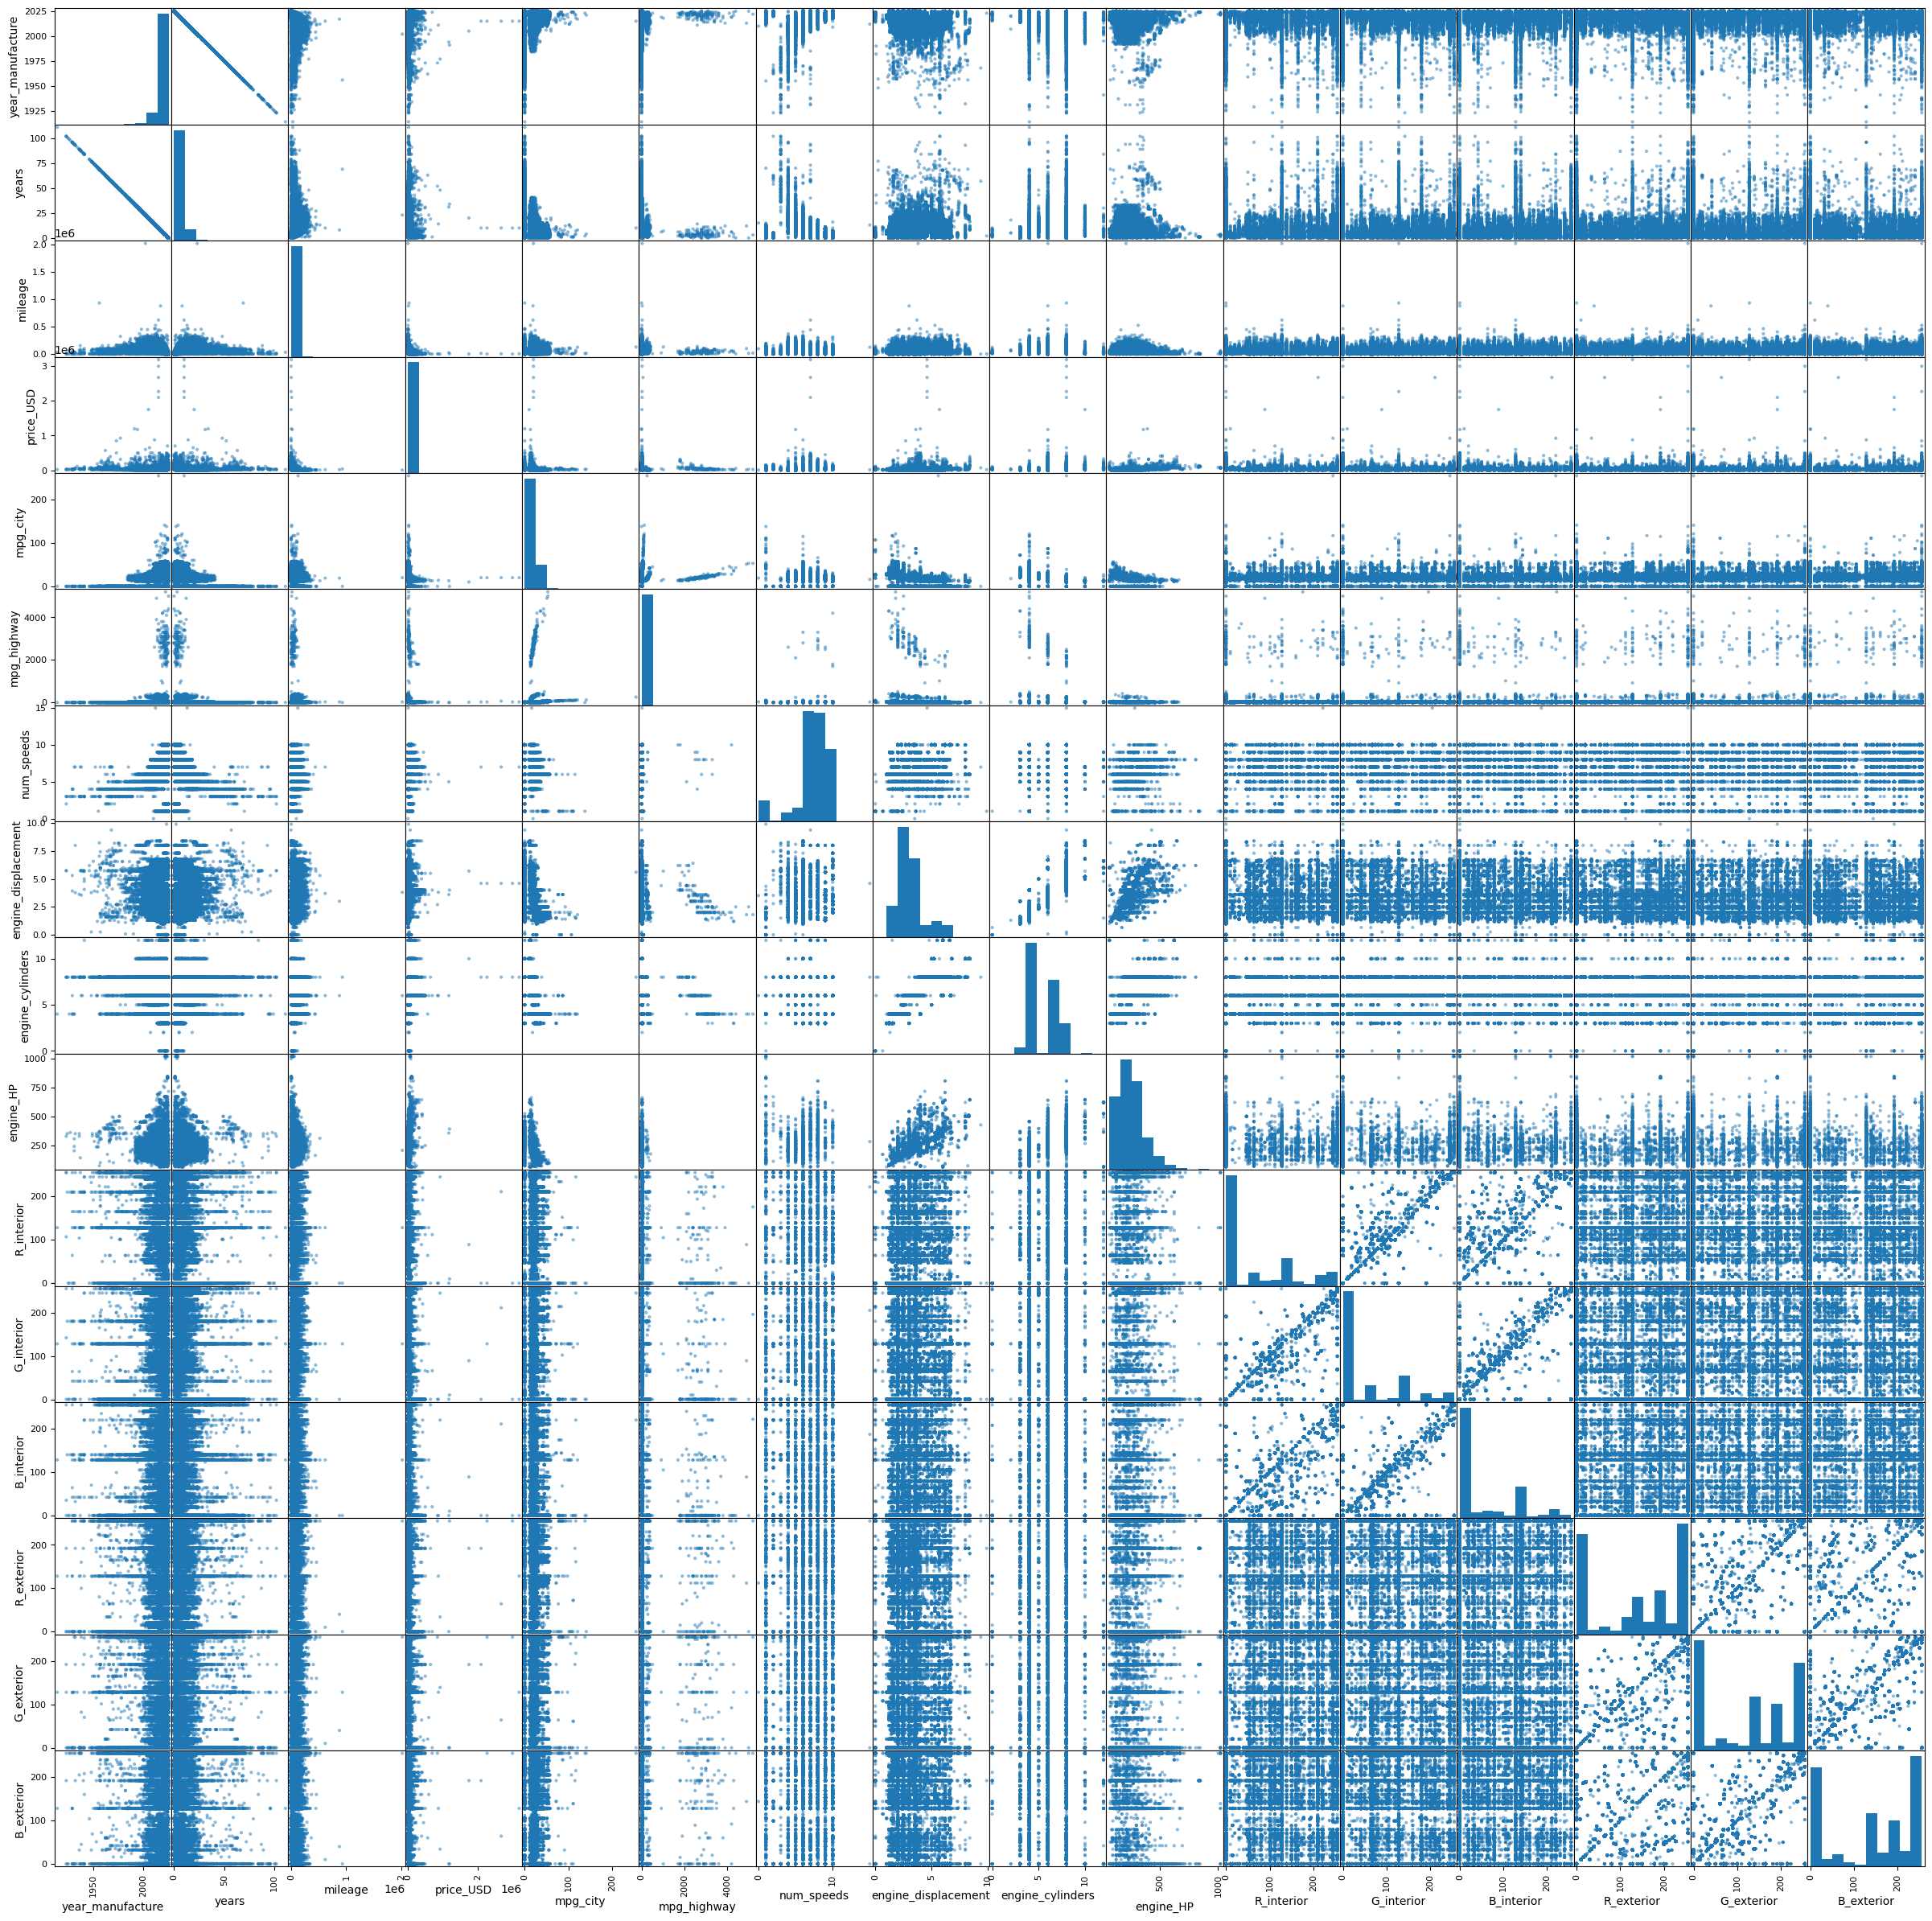

In [62]:
scatter_matrix(df, figsize = (30, 30), diagonal = 'hist')

##### Conclusions

#TODO

#### 3.2.2.- Categorical variables

##### Distribution of the target variable by category

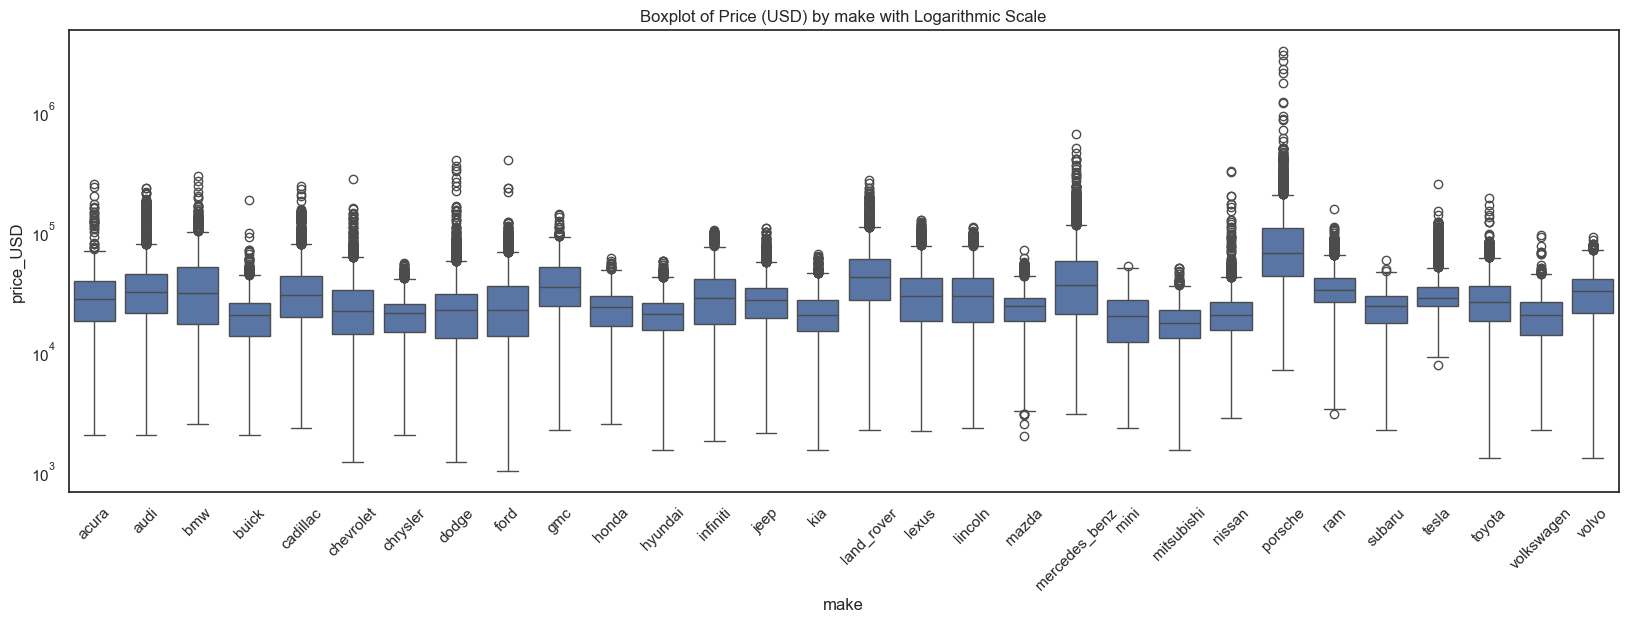

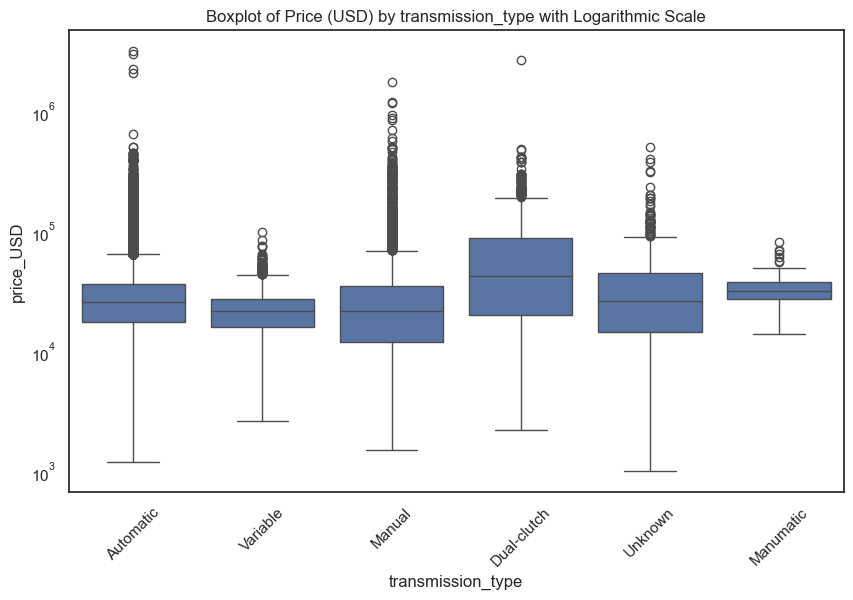

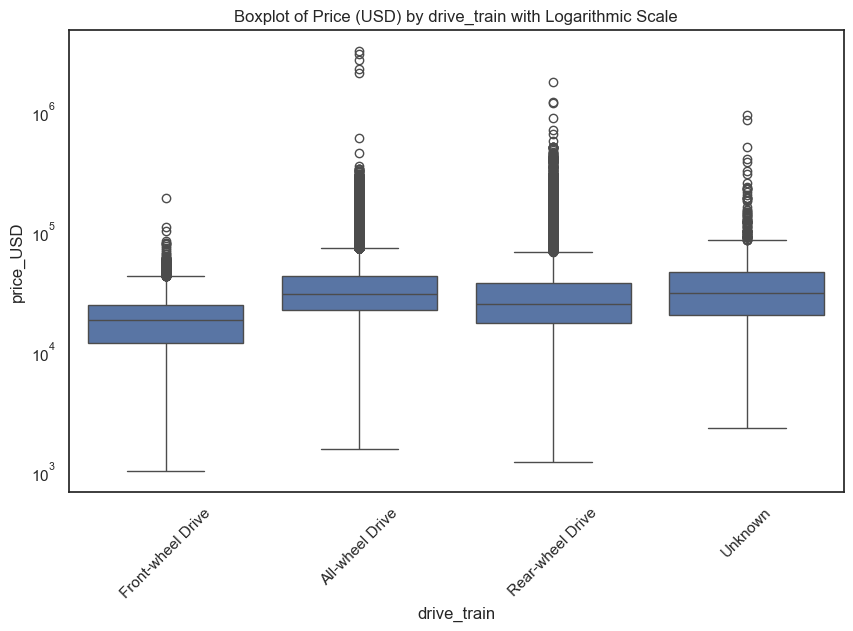

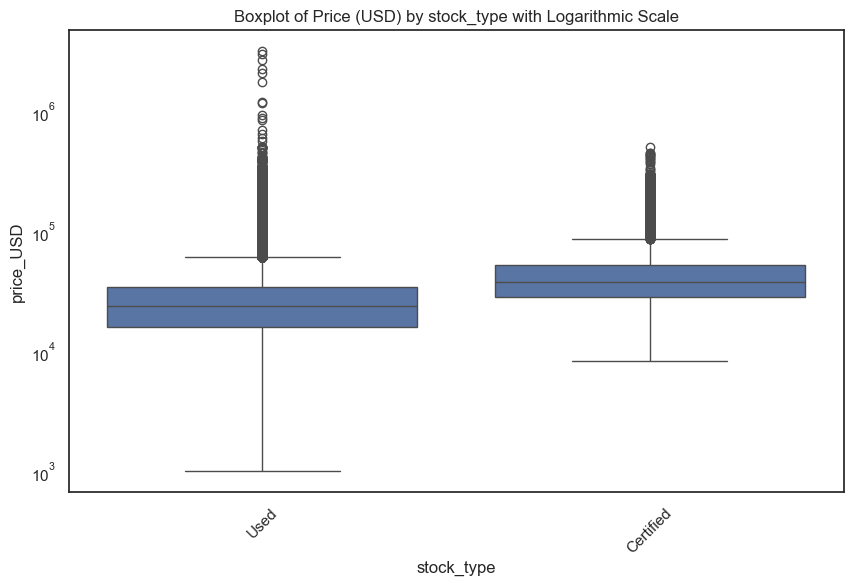

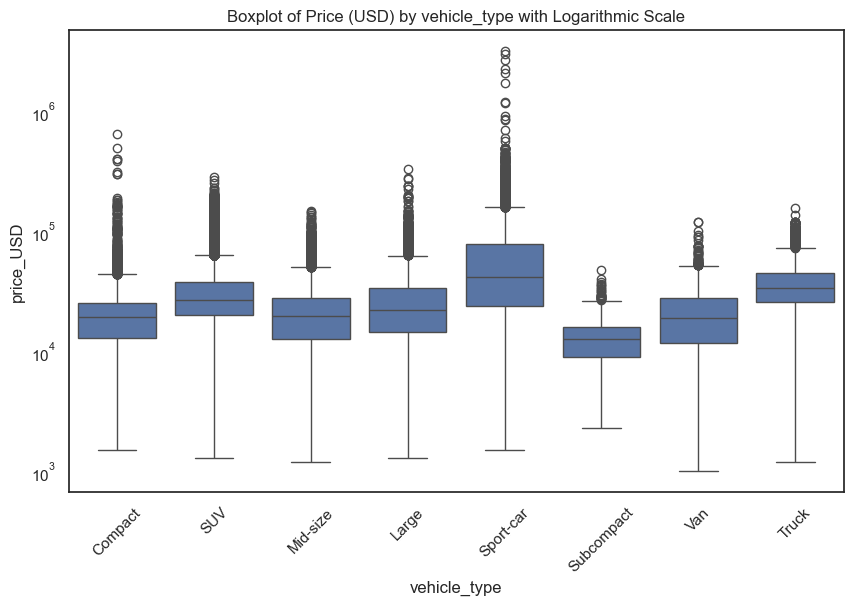

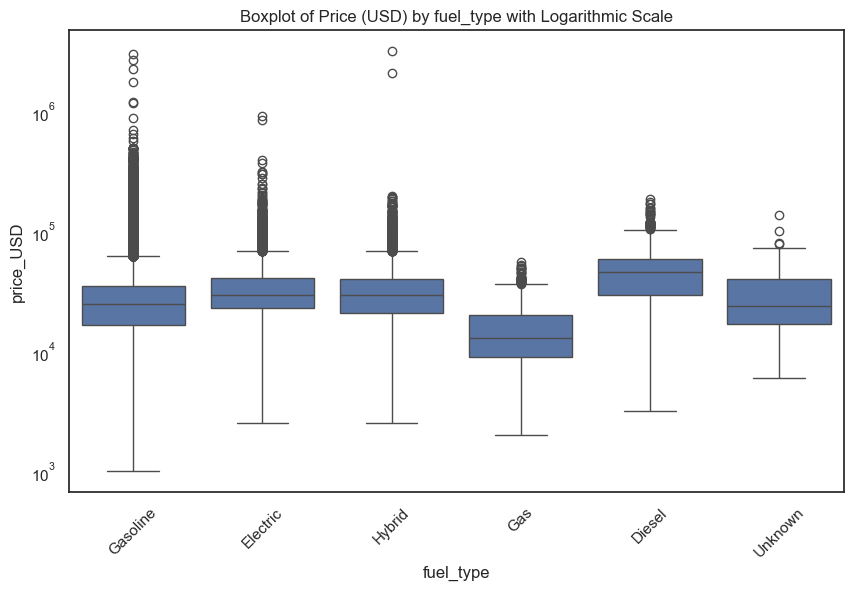

In [67]:
cat_variables_to_remove=['url','model']
for categorical_variable in [x for x in cat_col if x not in cat_variables_to_remove]:
    # Create a working copy of the DataFrame
    df_plot = df.copy()
    # Replace missing 'make' values with a label for plotting only
    df_plot[categorical_variable] = df_plot[categorical_variable].fillna('Unknown')
    plt.figure(figsize=(max(len(df_plot[categorical_variable].unique())*20/30,10), 6))  # Adjust the width (12) and height (6) to your preference
    # Create the boxplot
    sns.boxplot(x=categorical_variable, y='price_USD', data=df_plot, dodge=False)
    plt.xticks(rotation=45)
    # Set the y-axis to a logarithmic scale
    plt.yscale('log')
    # Add a title
    plt.title("Boxplot of Price (USD) by "+categorical_variable+" with Logarithmic Scale")
    # Display the plot
    plt.show()

In [64]:
 # Add category labels to each subplot
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, 0.2, label, fontweight="bold", color=color,
            ha="right", va="center", transform=ax.transAxes)

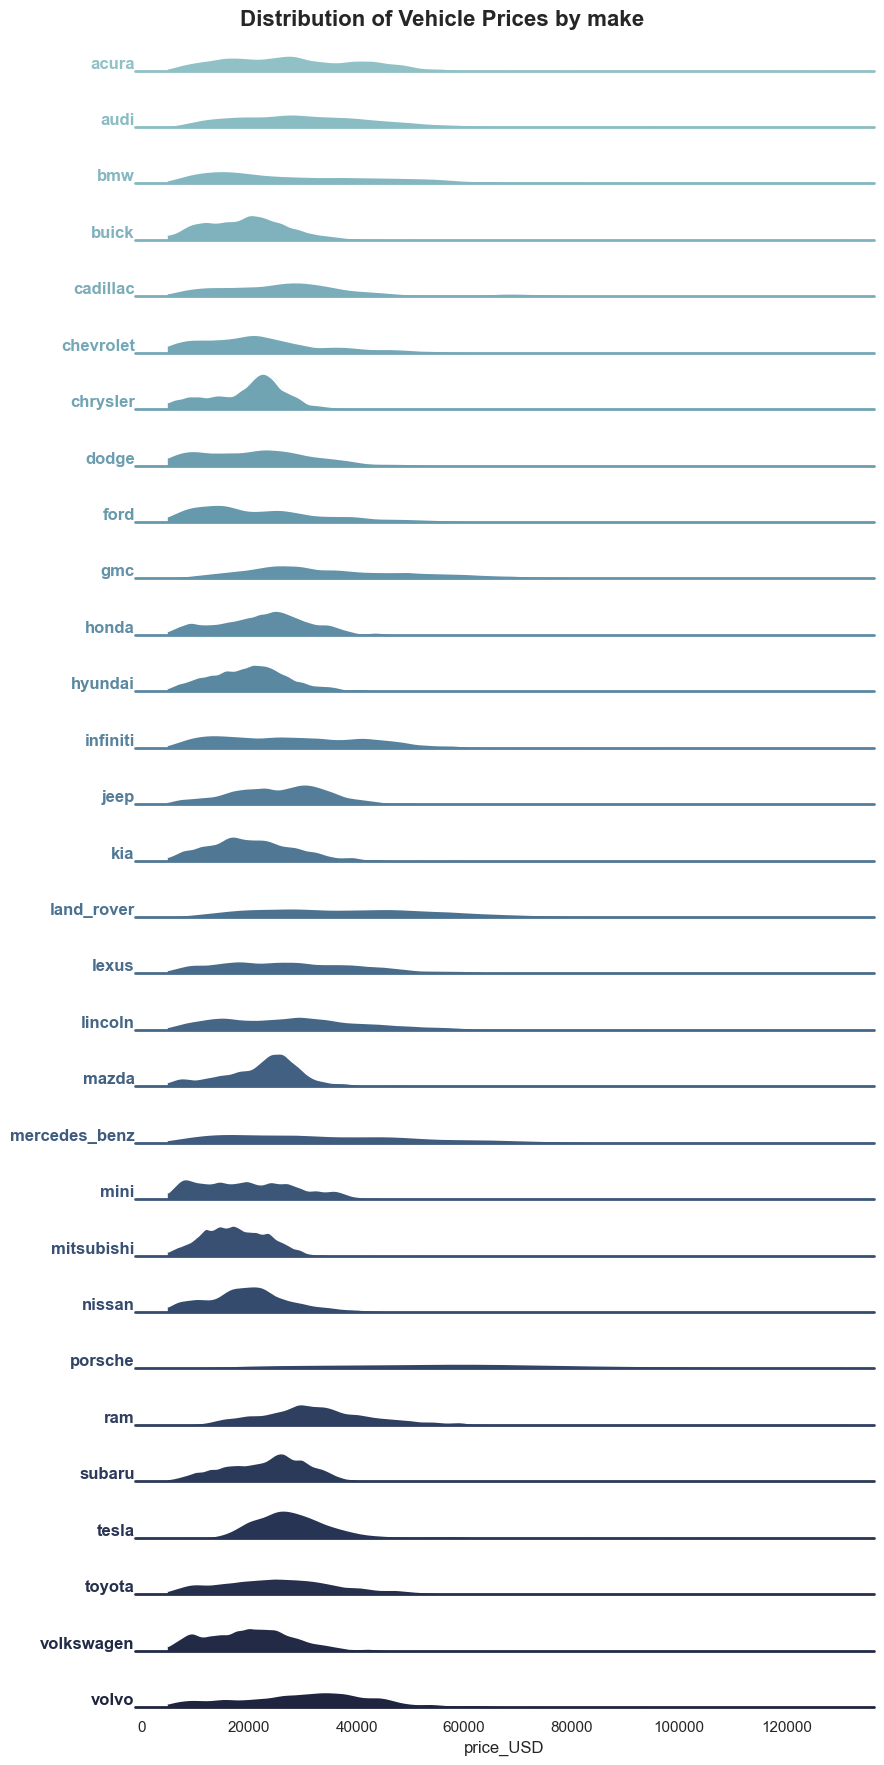

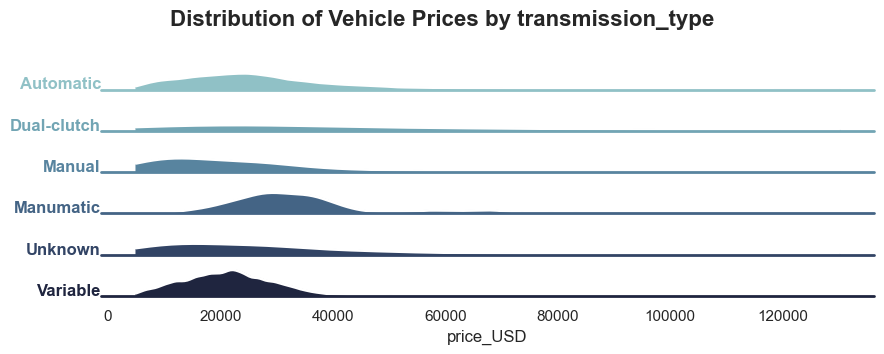

C:\Users\llama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\seaborn\axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.

C:\Users\llama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\seaborn\axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.

C:\Users\llama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\seaborn\axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.

C:\Users\llama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313

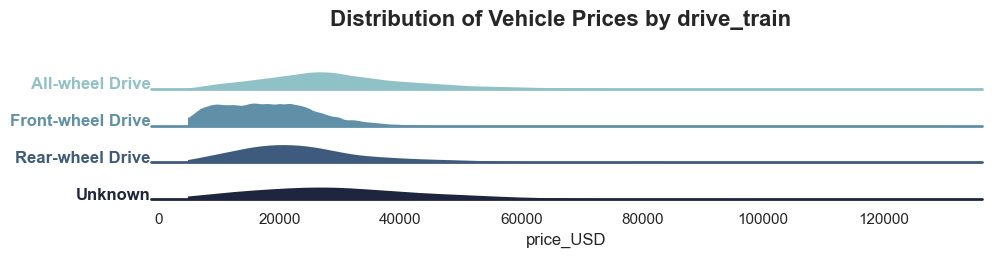

C:\Users\llama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\seaborn\axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.

C:\Users\llama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\seaborn\axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.

C:\Users\llama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\seaborn\axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.

C:\Users\llama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313

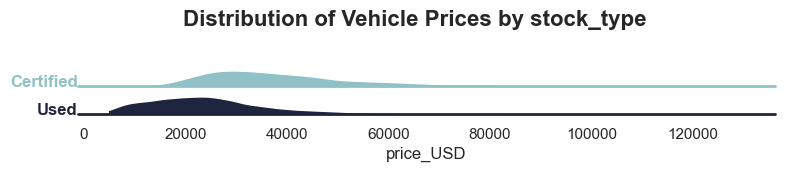

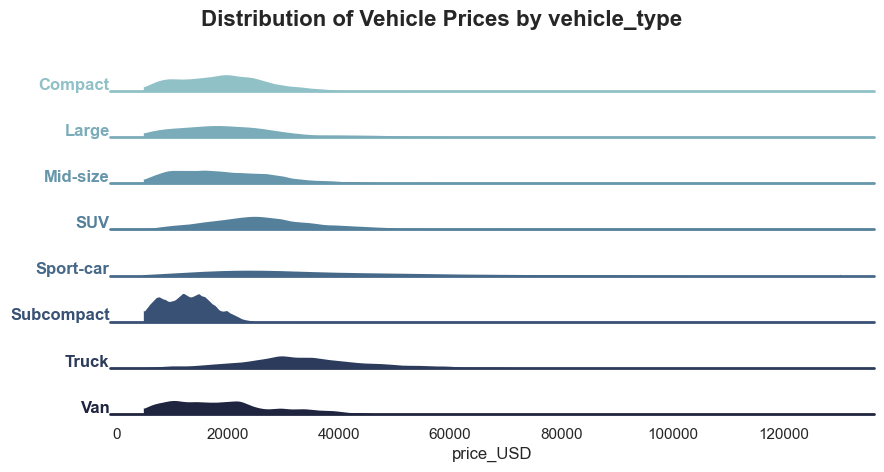

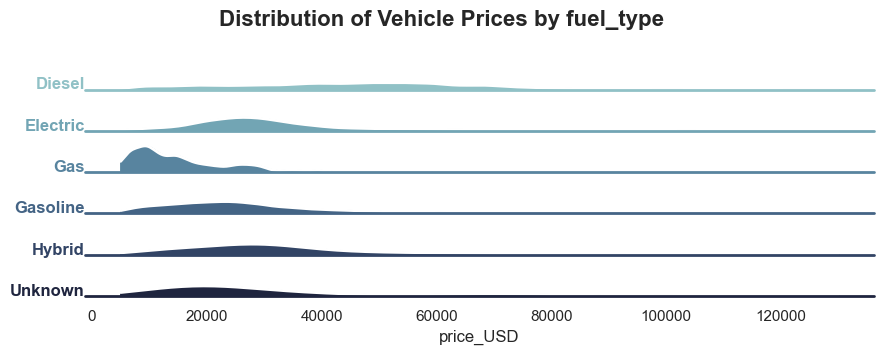

In [65]:
# cat_col=['make', 'url', 'transmission_type', 'drive_train', 'stock_type', 'model', 'vehicle_type', 'fuel_type']
cat_variables_to_remove=['url','model']      
for categorical_variable in [x for x in cat_col if x not in cat_variables_to_remove]:
      # Set visual theme
      sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

      # Create a working copy of the DataFrame
      df_plot = df.copy()

      # Replace missing 'make' values with a label for plotting only
      df_plot[categorical_variable] = df_plot[categorical_variable].fillna('Unknown')

      # Make 'make' categorical and sorted alphabetically
      df_plot[categorical_variable] = pd.Categorical(df_plot[categorical_variable], categories=sorted(df_plot[categorical_variable].unique()), ordered=True)

      # Limit x-axis to avoid extreme outliers
      lower, upper = df_plot['price_USD'].quantile([0.01, 0.99])

      # Create a color palette
      palette = sns.cubehelix_palette(len(df_plot[categorical_variable].unique()), rot=-.25, light=.7)

      # Initialize the FacetGrid
      g = sns.FacetGrid(df_plot, row=categorical_variable, hue=categorical_variable, aspect=15, height=.6, palette=palette)

      # Plot filled KDE curves
      g.map(sns.kdeplot, "price_USD",
            bw_adjust=.5, clip=(lower, upper),
            fill=True, alpha=1, linewidth=1.5)

      # Overlay white outline
      g.map(sns.kdeplot, "price_USD",
            clip=(lower, upper), color="w", lw=2, bw_adjust=.5)

      # Reference line
      g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

      # Add labels
      g.map(label, "price_USD")

      # Adjust subplot spacing
      g.figure.subplots_adjust(hspace=0.5)

      # Clean up appearance
      g.set_titles("")
      g.set(yticks=[], ylabel="")
      g.despine(bottom=True, left=True)

      plt.suptitle(
      "Distribution of Vehicle Prices by " + categorical_variable,
      fontsize=16,
      fontweight='bold',
      ha='center'
      )

      # Add padding between title and plot area
      plt.subplots_adjust(top=1-1/(len(df_plot[categorical_variable].unique())))

      # Show plot
      plt.show()
      plt.clf()
      plt.close()

In [66]:
cat_variables_to_remove=['url', 'model']      
for categorical_variable in [x for x in cat_col if x not in cat_variables_to_remove]:
    display(df.groupby(categorical_variable, dropna=False)['price_USD'].agg(['mean', 'median', 'std', 'count']))
display(df.groupby(['make','model'], dropna=False)['price_USD'].agg(['mean', 'median', 'std', 'count']))

mean   median            std  count
make                                                      
acura          29259.644533  27591.5   15905.683555   4518
audi           36903.663551  31400.0   25910.403515   4815
bmw            37075.538492  30990.0   26074.064171   4975
buick          20309.600438  19990.0    9531.570331   4570
cadillac       35657.865720  29688.5   24517.770684   4930
chevrolet      25599.176254  21975.0   17173.623910   4885
chrysler       20179.690012  21100.0    8064.297872   4155
dodge          24770.438780  21999.0   20165.275795   4492
ford           26734.607808  21999.0   19507.605292   4457
gmc            38532.087569  34486.0   19696.304585   4899
honda          23010.437730  23463.5    9363.754981   4898
hyundai        20822.780952  20579.0    8322.486468   4935
infiniti       29770.080940  27995.0   15907.854797   4596
jeep           27748.441933  26995.0   12969.963238   4779
kia            21229.971301  20095.0    9246.750042   4913
land_rover     48209.305099  41987.0   31014.767067   4923
lexus          31927.761046  28900.0   18880.306534   4549
lincoln        31370.605699  28939.5   17821.068353   4948
mazda          23189.791951  23969.0    8867.927743   4398
mercedes_benz  46378.335271  35995.5   41731.343885   4644
mini           20290.793799  19614.5    9646.779745   4806
mitsubishi     17679.339986  17197.0    6488.500545   4409
nissan         21387.993711  19998.0   13253.252117   4929
porsche        91058.763482  66801.0  114897.809249   4951
ram            34532.020773  32500.0   13835.111474   4140
subaru         23320.716290  24097.0    8098.269226   4917
tesla          32380.699864  28000.0   16398.986873   4398
toyota         27865.689481  25999.0   14792.145991   4953
volkswagen     20527.819166  20000.0    9022.709398   4435
volvo          31582.524577  31793.5   14622.625478   4964

mean   median            std   count
transmission_type                                              
Automatic          30627.445724  25499.0   27839.532406  129726
Dual-clutch        74404.322793  41995.0  122189.967304     759
Manual             35663.257584  21789.0   60685.137784    5637
Manumatic          35178.372549  31675.0   14311.806195      51
Variable           21866.594663  21492.0    8908.607531    4347
NaN                38530.316188  26000.0   45400.491204     661

mean   median           std  count
drive_train                                                  
All-wheel Drive    35509.474625  29900.0  31967.362376  79625
Front-wheel Drive  18691.446308  17985.0   9031.918571  39531
Rear-wheel Drive   35455.720521  24600.0  44208.316088  20667
NaN                39692.602356  30252.5  48547.548766   1358

mean   median           std   count
stock_type                                             
Certified   46389.755000  37500.0  34288.569835   13449
Used        29194.748348  23998.0  30250.978760  127732

mean   median           std  count
vehicle_type                                            
Compact       20639.578979  19359.5  14463.305038  18258
Large         28619.408624  21998.0  23355.291380   7398
Mid-size      22247.568911  19887.5  13589.535121  14468
SUV           31437.568859  27000.0  18919.093745  72547
Sport-car     64903.876719  41884.5  91065.387527   9596
Subcompact    12785.863027  12597.0   4971.857853   4030
Truck         36753.243197  33995.0  17354.990352  11135
Van           20876.091224  18991.0  12026.616612   3749

mean   median           std   count
fuel_type                                             
Diesel     45515.640083  45990.0  22197.107289    2884
Electric   36903.149163  29488.5  28374.408149    8722
Gas        15345.787640  12990.0   8825.464018    1521
Gasoline   30059.253012  24675.5  29918.484307  122196
Hybrid     34725.620120  29500.0  53846.832761    5815
NaN        34235.651163  23998.0  27512.571807      43

mean   median           std  count
make  model                                              
acura CL        7517.800000   7995.0   3245.437829      5
      ILX      19110.585714  19803.5   5209.405772    350
      INTEGRA  30591.270588  29990.0   5082.868547    340
      LEGEND   11612.666667  13888.0   3994.806795      3
      MDX      33600.691624  35992.5  14355.872231   1576
...                     ...      ...           ...    ...
volvo V60      25171.552147  20777.0  13484.317327    163
      V70       5548.117647   4888.0   3027.349271     17
      V90      35536.911765  30992.0  13188.673966     34
      XC60     32175.769386  32992.0  12719.841091   1483
      XC90     39454.475823  40997.0  15543.087989   1427

[721 rows x 4 columns]

##### Categorical correlation

In [ ]:
#TODO

##### Conclusions

#TODO

## 4.- Definition of training and test samples

Reordenar y muestra estratificada

## 5.- Training sample preprocessing

### 5.1.- Imputation for missing data

La imputación se deriva solo de la muestra de entrenamiento y se aplica tanto a entrenamiento como a test

### 5.2.- Categorical variable codification

### 5.3.- EDA-based transformations

Log, Box-Cox, capar outliers

### 5.4.- Normalization / Sandardization of numerical variables

Solo con los parametros de training

### 5.5.- Dimensionality reduction

PCA, entrenados con los datos de entrenamiento y aplicado a entrenamiento y test

## 6.- Modelling

### 6.1.- Model selection

### 6.2.- Cross-validation and hyperparameter selection

## 7.- Testing